# <입원 기간 예측 알고리즘>

**이화여자대학교  
윤하영 이선민 이진솔 조은서**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import xgboost
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from lightgbm import plot_importance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import optimizers
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures) 
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv("train_data.csv")

# 1. 데이터분석

### 상관관계

<AxesSubplot:>

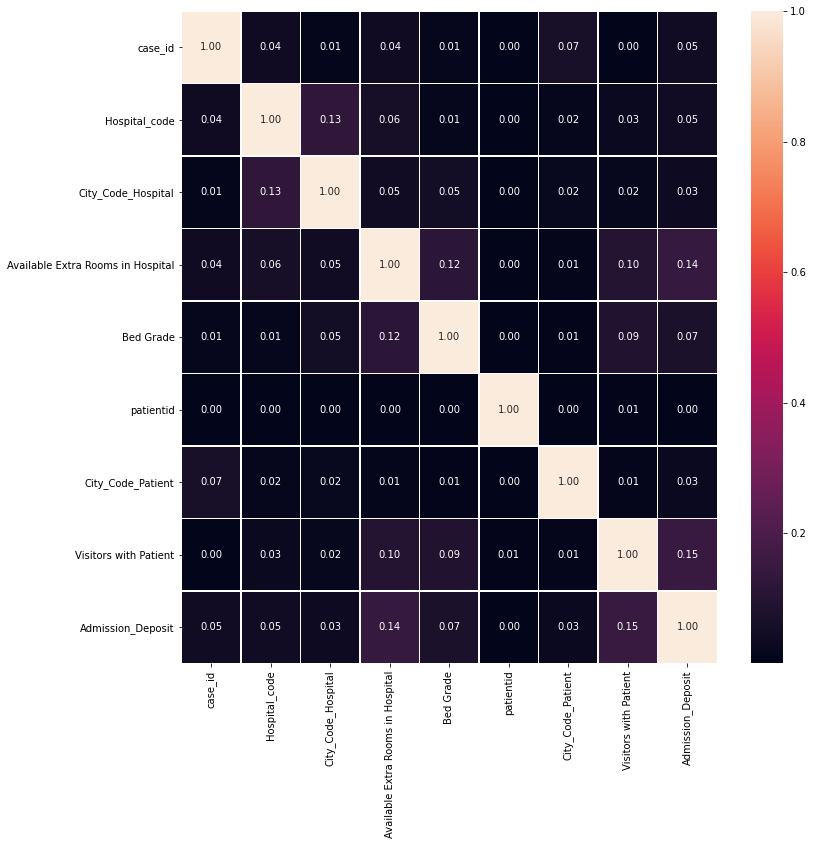

In [33]:
# Stay와 VIsitors with Patient 간의 높은 상관관계 확인
plt.figure(figsize=(12,12))
sns.heatmap(data=df.corr().abs(), annot=True, fmt='.2f', linewidths=.5)

# 2. 전처리

In [10]:
df2 = df.copy()

In [11]:
# 범주형 변수 원핫인코딩

illness_mapping = {'Extreme':2, 'Minor':0, 'Moderate':1}
df2['Severity of Illness'] = df['Severity of Illness'].map(illness_mapping)

type_mapping = {'Emergency': 2, 'Trauma':0, 'Urgent':1 }
df2['Type of Admission'] = df['Type of Admission'].map(type_mapping)

department_mapping = {'radiotherapy': 0, 'anesthesia':1, 'gynecology':2, 'TB & Chest disease': 3, 'surgery':4}
df2['Department'] = df['Department'].map(department_mapping)


# Stay 중간값 처리 - 'Stay More than 100 Days'는 105로 처리
stay_mapping = {'0-10':5, '11-20':15, '21-30':25, '31-40':35, '41-50':45, '51-60':55, '61-70':65, '71-80':75, '81-90':85, '91-100':95, 'More than 100 Days':105}
df2['Stay'] = df['Stay'].map(stay_mapping)

# Age 처리
age_mapping = {'0-10':5, '11-20':15, '21-30':25, '31-40':35, '41-50':45, '51-60':55, '61-70':65, '71-80':75, '81-90':85, '91-100':95}
df2['Age'] = df['Age'].map(age_mapping)


df2 = df2.loc[:, ['Department','Type of Admission','Visitors with Patient', 'Severity of Illness','Available Extra Rooms in Hospital','Age','Admission_Deposit','Stay']]


In [12]:
df2.head(5)

,Department,Type of Admission,Visitors with Patient,Severity of Illness,Available Extra Rooms in Hospital,Age,Admission_Deposit,Stay
0,0,2,2,2,3,55,4911.0,5
1,0,0,2,2,2,55,5954.0,45
2,1,0,2,2,2,55,4745.0,35
3,0,0,2,2,2,55,7272.0,45
4,0,0,2,2,2,55,5558.0,45


In [13]:
# 결측치 처리
print("Data set의 결측치: ")
print(df2.isna().sum().sum())

Data set의 결측치: 
0


In [14]:
# 31만개의 data set에 비해 결측치가 매우 적다고 판단하여 결측치 모두 삭제
df3 = df2.dropna()

# 3. 모델링

In [16]:
X_data = df3.drop(['Stay'], axis=1)
y_data = df3['Stay']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.1, random_state=777)

In [17]:
# 정답값에 +- 15일 오차를 허용한 새로운 정확도 산출 함수
def new_accuracy(y_test, pred):
    accuracy_count=0
    for label,y in zip(y_test, pred):
        if ((y >= label-15) & (y <= label+15)):
            accuracy_count += 1
    return accuracy_count/len(pred)

## 1) 방문자수 예측 

In [18]:
V_X_data =  df3.drop(['Stay', 'Visitors with Patient'], axis=1)
V_y_data = df3['Visitors with Patient']
V_X_train, V_X_test, V_y_train, V_y_test = train_test_split(V_X_data, V_y_data, test_size = 0.1, random_state=777)

In [19]:
V_X_train.head()

,Department,Type of Admission,Severity of Illness,Available Extra Rooms in Hospital,Age,Admission_Deposit
314293,2,2,2,6,15,7731.0
86058,1,2,2,4,45,4401.0
170972,2,0,1,3,65,4355.0
161774,3,2,1,4,55,6155.0
14123,2,0,1,2,35,7404.0


In [20]:
from sklearn.preprocessing import StandardScaler
V_sc = StandardScaler()
scaled_V_X_train = V_sc.fit_transform(V_X_train)
scaled_V_X_test = V_sc.transform(V_X_test)

In [21]:
hyper_params = {
    'objective': 'regression',
    'metric':{'rmse', 'mean_absolute_error'},
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 6,
    "num_leaves": 64,
    "num_iterations":2000
}

V_lgb_train = lgb.Dataset(scaled_V_X_train, V_y_train)
V_lgb_eval = lgb.Dataset(scaled_V_X_test, V_y_test, reference = V_lgb_train)
V_lgbm = lgb.train(hyper_params, V_lgb_train, num_boost_round=1000, valid_sets = V_lgb_eval, early_stopping_rounds =200)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's rmse: 1.79171	valid_0's l1: 1.24489
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmse: 1.79077	valid_0's l1: 1.24408
[3]	valid_0's rmse: 1.78991	valid_0's l1: 1.24332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 1.78906	valid_0's l1: 1.24258
[5]	valid_0's rmse: 1.78815	valid_0's l1: 1.24179
[6]	valid_0's rmse: 1.78724	valid_0's l1: 1.24099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 1.78643	valid_0's l1: 1.24027
[8]	valid_0's rmse: 1.7856	valid_0's l1: 1.23953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's rmse: 1.78479	valid_0's l1: 1.23881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 1.7

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's rmse: 1.73397	valid_0's l1: 1.18594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's rmse: 1.73378	valid_0's l1: 1.18565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's rmse: 1.73336	valid_0's l1: 1.18516
[106]	valid_0's rmse: 1.73298	valid_0's l1: 1.18471
[107]	valid_0's rmse: 1.73261	valid_0's l1: 1.18427
[108]	valid_0's rmse: 1.73224	valid_0's l1: 1.18384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's rmse: 1.73184	valid_0's l1: 1.18335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	valid_0's rmse: 1.73142	valid_0's l1: 1.18285
[111]	valid_0's rmse: 1.73102	valid_0's l1: 1.18235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's rmse: 1.73065	valid_0's l1: 1.18191
[LightGBM] [Warning] No furthe

[194]	valid_0's rmse: 1.70919	valid_0's l1: 1.15616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's rmse: 1.70899	valid_0's l1: 1.15594
[196]	valid_0's rmse: 1.70879	valid_0's l1: 1.1557
[197]	valid_0's rmse: 1.70859	valid_0's l1: 1.15546
[198]	valid_0's rmse: 1.70848	valid_0's l1: 1.15531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's rmse: 1.70826	valid_0's l1: 1.15506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's rmse: 1.70807	valid_0's l1: 1.15485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's rmse: 1.70787	valid_0's l1: 1.1546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's rmse: 1.70777	valid_0's l1: 1.15445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's rmse: 1.70757	valid_0's l1: 1.15421
[LightGBM] [Warning] No further 

[279]	valid_0's rmse: 1.69703	valid_0's l1: 1.14087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[280]	valid_0's rmse: 1.69692	valid_0's l1: 1.14071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's rmse: 1.6968	valid_0's l1: 1.14056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	valid_0's rmse: 1.69668	valid_0's l1: 1.1404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's rmse: 1.69662	valid_0's l1: 1.14031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's rmse: 1.69651	valid_0's l1: 1.14019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	valid_0's rmse: 1.69645	valid_0's l1: 1.1401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[286]	valid_0's rmse: 1.69635	valid_0's l1: 1.13997
[LightGBM] [Warning] No further splits with positive gain, bes

[364]	valid_0's rmse: 1.68981	valid_0's l1: 1.13127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[365]	valid_0's rmse: 1.68977	valid_0's l1: 1.13118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[366]	valid_0's rmse: 1.6897	valid_0's l1: 1.13109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[367]	valid_0's rmse: 1.68964	valid_0's l1: 1.131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[368]	valid_0's rmse: 1.68957	valid_0's l1: 1.1309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[369]	valid_0's rmse: 1.6895	valid_0's l1: 1.13083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's rmse: 1.68946	valid_0's l1: 1.13075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's rmse: 1.68939	valid_0's l1: 1.13065
[LightGBM] [Warning] No further splits with positive gain, best 

[436]	valid_0's rmse: 1.68609	valid_0's l1: 1.12609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[437]	valid_0's rmse: 1.68606	valid_0's l1: 1.12604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[438]	valid_0's rmse: 1.68602	valid_0's l1: 1.12599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[439]	valid_0's rmse: 1.68597	valid_0's l1: 1.12593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's rmse: 1.68593	valid_0's l1: 1.12587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's rmse: 1.68589	valid_0's l1: 1.12581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[442]	valid_0's rmse: 1.68586	valid_0's l1: 1.12575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[443]	valid_0's rmse: 1.68582	valid_0's l1: 1.1257
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's rmse: 1.68328	valid_0's l1: 1.12194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's rmse: 1.68325	valid_0's l1: 1.1219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's rmse: 1.68323	valid_0's l1: 1.12186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's rmse: 1.68319	valid_0's l1: 1.12182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[519]	valid_0's rmse: 1.68317	valid_0's l1: 1.12177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's rmse: 1.68314	valid_0's l1: 1.12175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[521]	valid_0's rmse: 1.68311	valid_0's l1: 1.1217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[522]	valid_0's rmse: 1.68308	valid_0'

[582]	valid_0's rmse: 1.68166	valid_0's l1: 1.11937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[583]	valid_0's rmse: 1.68164	valid_0's l1: 1.11935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[584]	valid_0's rmse: 1.68162	valid_0's l1: 1.11932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[585]	valid_0's rmse: 1.68159	valid_0's l1: 1.11928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[586]	valid_0's rmse: 1.68157	valid_0's l1: 1.11924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	valid_0's rmse: 1.68156	valid_0's l1: 1.11921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[588]	valid_0's rmse: 1.68154	valid_0's l1: 1.11917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[589]	valid_0's rmse: 1.68152	valid_0's l1: 1.11914
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[648]	valid_0's rmse: 1.68056	valid_0's l1: 1.11746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[649]	valid_0's rmse: 1.68054	valid_0's l1: 1.11743
[650]	valid_0's rmse: 1.68053	valid_0's l1: 1.11742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[651]	valid_0's rmse: 1.68051	valid_0's l1: 1.11738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[652]	valid_0's rmse: 1.6805	valid_0's l1: 1.11735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[653]	valid_0's rmse: 1.68048	valid_0's l1: 1.11732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[654]	valid_0's rmse: 1.68046	valid_0's l1: 1.11729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[655]	valid_0's rmse: 1.68043	valid_0's l1: 1.11725
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[717]	valid_0's rmse: 1.67961	valid_0's l1: 1.11573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[718]	valid_0's rmse: 1.67961	valid_0's l1: 1.11571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[719]	valid_0's rmse: 1.67959	valid_0's l1: 1.11567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[720]	valid_0's rmse: 1.67957	valid_0's l1: 1.11564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[721]	valid_0's rmse: 1.67956	valid_0's l1: 1.11561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[722]	valid_0's rmse: 1.67956	valid_0's l1: 1.11559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[723]	valid_0's rmse: 1.67955	valid_0's l1: 1.11556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[724]	valid_0's rmse: 1.67954	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[787]	valid_0's rmse: 1.6788	valid_0's l1: 1.11426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[788]	valid_0's rmse: 1.67879	valid_0's l1: 1.11425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[789]	valid_0's rmse: 1.67879	valid_0's l1: 1.11424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[790]	valid_0's rmse: 1.67878	valid_0's l1: 1.11423
[791]	valid_0's rmse: 1.67878	valid_0's l1: 1.11421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[792]	valid_0's rmse: 1.67876	valid_0's l1: 1.11419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[793]	valid_0's rmse: 1.67876	valid_0's l1: 1.11419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[794]	valid_0's rmse: 1.67875	valid_0's l1: 1.11418
[795]	valid_0's rmse: 1.67875	valid_0's l1: 1.11416
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[853]	valid_0's rmse: 1.67838	valid_0's l1: 1.11343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[854]	valid_0's rmse: 1.67838	valid_0's l1: 1.11342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[855]	valid_0's rmse: 1.67838	valid_0's l1: 1.11341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[856]	valid_0's rmse: 1.67837	valid_0's l1: 1.1134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[857]	valid_0's rmse: 1.67837	valid_0's l1: 1.1134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[858]	valid_0's rmse: 1.67836	valid_0's l1: 1.11339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[859]	valid_0's rmse: 1.67836	valid_0's l1: 1.11339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[860]	valid_0's rmse: 1.67835	valid_0'

[920]	valid_0's rmse: 1.67805	valid_0's l1: 1.11259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[921]	valid_0's rmse: 1.67804	valid_0's l1: 1.11258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[922]	valid_0's rmse: 1.67803	valid_0's l1: 1.11258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[923]	valid_0's rmse: 1.67803	valid_0's l1: 1.11257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[924]	valid_0's rmse: 1.67803	valid_0's l1: 1.11256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[925]	valid_0's rmse: 1.67803	valid_0's l1: 1.11256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[926]	valid_0's rmse: 1.67802	valid_0's l1: 1.11254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[927]	valid_0's rmse: 1.67801	valid_0's l1: 1.11253
[LightGBM] [Warning] No further splits with positive gain, 

[989]	valid_0's rmse: 1.67768	valid_0's l1: 1.11182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	valid_0's rmse: 1.67767	valid_0's l1: 1.11181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[991]	valid_0's rmse: 1.67767	valid_0's l1: 1.1118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[992]	valid_0's rmse: 1.67767	valid_0's l1: 1.11179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[993]	valid_0's rmse: 1.67766	valid_0's l1: 1.11178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[994]	valid_0's rmse: 1.67765	valid_0's l1: 1.11177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[995]	valid_0's rmse: 1.67765	valid_0's l1: 1.11176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[996]	valid_0's rmse: 1.67765	valid_0's l1: 1.11175
[LightGBM] [Warning] No further splits with positive gain, b

[1055]	valid_0's rmse: 1.67751	valid_0's l1: 1.11119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1056]	valid_0's rmse: 1.6775	valid_0's l1: 1.11118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1057]	valid_0's rmse: 1.6775	valid_0's l1: 1.11117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1058]	valid_0's rmse: 1.67749	valid_0's l1: 1.11116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1059]	valid_0's rmse: 1.67749	valid_0's l1: 1.11115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1060]	valid_0's rmse: 1.67748	valid_0's l1: 1.11114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1061]	valid_0's rmse: 1.67748	valid_0's l1: 1.11114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1062]	valid_0's rmse: 1.67748	valid_0's l1: 1.11113
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1123]	valid_0's rmse: 1.67739	valid_0's l1: 1.11084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1124]	valid_0's rmse: 1.67739	valid_0's l1: 1.11084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1125]	valid_0's rmse: 1.67738	valid_0's l1: 1.11084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1126]	valid_0's rmse: 1.67738	valid_0's l1: 1.11084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1127]	valid_0's rmse: 1.67737	valid_0's l1: 1.11083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1128]	valid_0's rmse: 1.67737	valid_0's l1: 1.11083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1129]	valid_0's rmse: 1.67736	valid_0's l1: 1.11084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1130]	valid_0's rmse: 1.6773

[1190]	valid_0's rmse: 1.67721	valid_0's l1: 1.11046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1191]	valid_0's rmse: 1.67721	valid_0's l1: 1.11044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1192]	valid_0's rmse: 1.67721	valid_0's l1: 1.11044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1193]	valid_0's rmse: 1.67721	valid_0's l1: 1.11044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1194]	valid_0's rmse: 1.6772	valid_0's l1: 1.11043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1195]	valid_0's rmse: 1.6772	valid_0's l1: 1.11043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1196]	valid_0's rmse: 1.67719	valid_0's l1: 1.11042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1197]	valid_0's rmse: 1.67718	valid_0's l1: 1.11042
[LightGBM] [Warning] No further splits with positive 

[1256]	valid_0's rmse: 1.67705	valid_0's l1: 1.1101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1257]	valid_0's rmse: 1.67705	valid_0's l1: 1.11009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1258]	valid_0's rmse: 1.67705	valid_0's l1: 1.11007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1259]	valid_0's rmse: 1.67705	valid_0's l1: 1.11007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1260]	valid_0's rmse: 1.67704	valid_0's l1: 1.11006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1261]	valid_0's rmse: 1.67704	valid_0's l1: 1.11006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1262]	valid_0's rmse: 1.67704	valid_0's l1: 1.11005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1263]	valid_0's rmse: 1.67704	valid_0's l1: 1.11005
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1321]	valid_0's rmse: 1.67704	valid_0's l1: 1.10976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1322]	valid_0's rmse: 1.67705	valid_0's l1: 1.10976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1323]	valid_0's rmse: 1.67705	valid_0's l1: 1.10976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1324]	valid_0's rmse: 1.67705	valid_0's l1: 1.10976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1325]	valid_0's rmse: 1.67705	valid_0's l1: 1.10976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1326]	valid_0's rmse: 1.67705	valid_0's l1: 1.10976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1327]	valid_0's rmse: 1.67704	valid_0's l1: 1.10976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1328]	valid_0's rmse: 1.6770

[1388]	valid_0's rmse: 1.67696	valid_0's l1: 1.10945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1389]	valid_0's rmse: 1.67695	valid_0's l1: 1.10944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1390]	valid_0's rmse: 1.67695	valid_0's l1: 1.10944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1391]	valid_0's rmse: 1.67695	valid_0's l1: 1.10945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1392]	valid_0's rmse: 1.67696	valid_0's l1: 1.10945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1393]	valid_0's rmse: 1.67697	valid_0's l1: 1.10946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1394]	valid_0's rmse: 1.67697	valid_0's l1: 1.10946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1395]	valid_0's rmse: 1.67697	valid_0's l1: 1.10946
[LightGBM] [Warning] No further splits with positiv

[1453]	valid_0's rmse: 1.6769	valid_0's l1: 1.10924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1454]	valid_0's rmse: 1.6769	valid_0's l1: 1.10924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1455]	valid_0's rmse: 1.67689	valid_0's l1: 1.10923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1456]	valid_0's rmse: 1.6769	valid_0's l1: 1.10922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1457]	valid_0's rmse: 1.67689	valid_0's l1: 1.10922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1458]	valid_0's rmse: 1.67688	valid_0's l1: 1.10921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1459]	valid_0's rmse: 1.67688	valid_0's l1: 1.1092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1460]	valid_0's rmse: 1.67688	valid_0's l1: 1.1092
[LightGBM] [Warning] No further splits with positive gai

[1518]	valid_0's rmse: 1.67685	valid_0's l1: 1.10908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1519]	valid_0's rmse: 1.67684	valid_0's l1: 1.10908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1520]	valid_0's rmse: 1.67684	valid_0's l1: 1.10907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1521]	valid_0's rmse: 1.67684	valid_0's l1: 1.10907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1522]	valid_0's rmse: 1.67685	valid_0's l1: 1.10908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1523]	valid_0's rmse: 1.67684	valid_0's l1: 1.10907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1524]	valid_0's rmse: 1.67685	valid_0's l1: 1.10907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1525]	valid_0's rmse: 1.67685	valid_0's l1: 1.10907
[LightGBM] [Warning] No further splits with positiv

[1583]	valid_0's rmse: 1.67689	valid_0's l1: 1.10901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1584]	valid_0's rmse: 1.67689	valid_0's l1: 1.109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1585]	valid_0's rmse: 1.67689	valid_0's l1: 1.109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1586]	valid_0's rmse: 1.67688	valid_0's l1: 1.109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1587]	valid_0's rmse: 1.67688	valid_0's l1: 1.10899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1588]	valid_0's rmse: 1.67688	valid_0's l1: 1.10899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1589]	valid_0's rmse: 1.67688	valid_0's l1: 1.10899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1590]	valid_0's rmse: 1.67687	valid_0's l1: 1.10899
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1653]	valid_0's rmse: 1.6768	valid_0's l1: 1.10879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1654]	valid_0's rmse: 1.6768	valid_0's l1: 1.10879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1655]	valid_0's rmse: 1.6768	valid_0's l1: 1.10878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1656]	valid_0's rmse: 1.6768	valid_0's l1: 1.10877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1657]	valid_0's rmse: 1.6768	valid_0's l1: 1.10877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1658]	valid_0's rmse: 1.67679	valid_0's l1: 1.10876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1659]	valid_0's rmse: 1.6768	valid_0's l1: 1.10876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1660]	valid_0's rmse: 1.6768	valid

[1720]	valid_0's rmse: 1.67675	valid_0's l1: 1.10861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1721]	valid_0's rmse: 1.67675	valid_0's l1: 1.10861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1722]	valid_0's rmse: 1.67675	valid_0's l1: 1.1086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1723]	valid_0's rmse: 1.67675	valid_0's l1: 1.1086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1724]	valid_0's rmse: 1.67676	valid_0's l1: 1.1086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1725]	valid_0's rmse: 1.67676	valid_0's l1: 1.10859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1726]	valid_0's rmse: 1.67675	valid_0's l1: 1.10858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1727]	valid_0's rmse: 1.67675	valid_0's l1: 1.10857
[LightGBM] [Warning] No further splits with positive g

[1786]	valid_0's rmse: 1.67679	valid_0's l1: 1.10851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1787]	valid_0's rmse: 1.67679	valid_0's l1: 1.10851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1788]	valid_0's rmse: 1.67679	valid_0's l1: 1.10851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1789]	valid_0's rmse: 1.67679	valid_0's l1: 1.10851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1790]	valid_0's rmse: 1.67678	valid_0's l1: 1.10851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1791]	valid_0's rmse: 1.67678	valid_0's l1: 1.10851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1792]	valid_0's rmse: 1.67678	valid_0's l1: 1.1085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1793]	valid_0's rmse: 1.67678	valid_0's l1: 1.1085
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1853]	valid_0's rmse: 1.67687	valid_0's l1: 1.10839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1854]	valid_0's rmse: 1.67687	valid_0's l1: 1.1084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1855]	valid_0's rmse: 1.67687	valid_0's l1: 1.1084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1856]	valid_0's rmse: 1.67687	valid_0's l1: 1.10841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1857]	valid_0's rmse: 1.67687	valid_0's l1: 1.10841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1858]	valid_0's rmse: 1.67687	valid_0's l1: 1.10841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1859]	valid_0's rmse: 1.67688	valid_0's l1: 1.10841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1860]	valid_0's rmse: 1.67688	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1920]	valid_0's rmse: 1.67685	valid_0's l1: 1.10827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1921]	valid_0's rmse: 1.67686	valid_0's l1: 1.10827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1922]	valid_0's rmse: 1.67686	valid_0's l1: 1.10828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1923]	valid_0's rmse: 1.67687	valid_0's l1: 1.10828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1924]	valid_0's rmse: 1.67687	valid_0's l1: 1.10828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1925]	valid_0's rmse: 1.67688	valid_0's l1: 1.10828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1926]	valid_0's rmse: 1.67689	valid_0's l1: 1.10828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1927]	valid_0's rmse: 1.6769

In [22]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics

mae = metrics.mean_absolute_error(V_y_test, V_lgbm_pred)
V_lgbm_pred = V_lgbm.predict(scaled_V_X_test)
print("Lightgbm Regressor Model")
print("RMSE: ", np.round(np.sqrt(mean_squared_error(V_y_test, V_lgbm_pred)),3))
print("r2 score: ",np.round(r2_score(V_y_test, V_lgbm_pred),3))
print("MAE: ", mae)

Lightgbm Regressor Model
RMSE:  1.677
r2 score:  0.125


In [23]:
print("new accuracy: ", np.round(new_accuracy(V_y_test, V_lgbm_pred),5))

new accuracy:  0.99934


In [24]:
scaled_V_X_test

array([[-1.15220374, -0.97504549,  0.13720764, -0.16890599, -0.5963106 ,
         0.20119   ],
       [ 0.35277395, -0.97504549,  1.64521831, -1.02423671,  0.99172938,
         1.15758432],
       [ 0.35277395,  1.21220623,  1.64521831, -0.16890599, -0.06696394,
        -1.47871341],
       ...,
       [ 0.35277395,  1.21220623, -1.37080303, -0.16890599,  0.99172938,
        -0.75244284],
       [ 0.35277395, -0.97504549,  0.13720764,  1.54175546, -0.5963106 ,
        -0.54901344],
       [ 0.35277395,  1.21220623,  0.13720764,  0.68642473,  1.52107604,
         0.78018136]])

### 방문자수 잘 예측하는지 샘플 테스트 

In [25]:
ex = [[1, 1, 1, 1, 13, 6000]]
ex_scaled = V_sc.transform(ex)
ex_scaled

array([[-1.15220374,  0.11858037,  0.13720764, -1.87956743, -1.76087325,
         1.03055601]])

In [26]:
V_lgbm.predict(ex_scaled)

array([2.41062702])

### 학습된 방문자수 시각화 

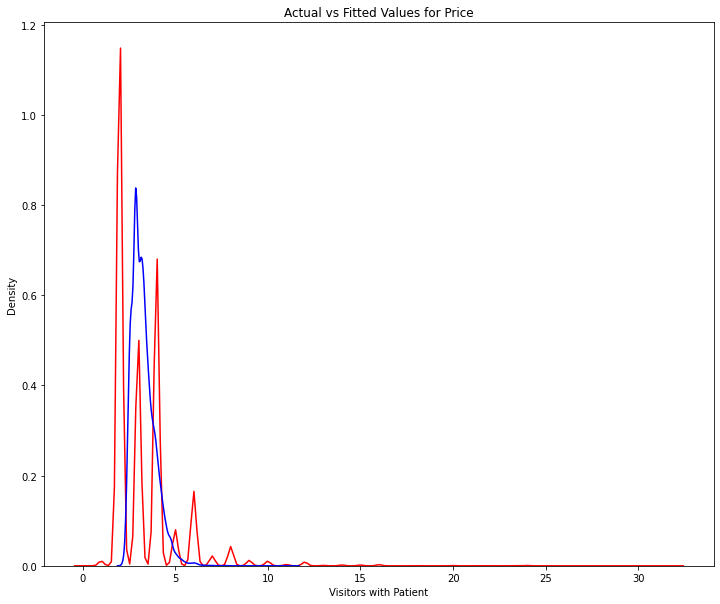

In [30]:
width = 12
height = 10
plt.figure(figsize=(width, height))

ax1 = sns.distplot(V_y_train, hist=False, color="r", label="Actual Value")
sns.distplot(V_lgbm_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Price')


plt.show()
plt.close()

## 2) 입원기간 예측

In [24]:
X_train.head()

,Department,Type of Admission,Visitors with Patient,Severity of Illness,Available Extra Rooms in Hospital,Age,Admission_Deposit
314293,2,2,2,2,6,15,7731.0
86058,1,2,4,2,4,45,4401.0
170972,2,0,2,1,3,65,4355.0
161774,3,2,4,1,4,55,6155.0
14123,2,0,2,1,2,35,7404.0


In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_X_train = sc.fit_transform(X_train)
scaled_X_test = sc.transform(X_test)

In [26]:
hyper_params = {
    'objective': 'regression',
    'metric':{'rmse', 'mean_absolute_error'},
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 6,
    "num_leaves": 64,
    "num_iterations":2000
}

lgb_train = lgb.Dataset(scaled_X_train, y_train)
lgb_eval = lgb.Dataset(scaled_X_test, y_test, reference = lgb_train)
lgbm = lgb.train(hyper_params, lgb_train, num_boost_round=1000, valid_sets = lgb_eval, early_stopping_rounds =200)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 16.2664	valid_0's rmse: 21.6657
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l1: 16.2342	valid_0's rmse: 21.6248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l1: 16.2021	valid_0's rmse: 21.5843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l1: 16.1702	valid_0's rmse: 21.5441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l1: 16.1391	valid_0's rmse: 21.505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's l1: 16.1076	valid_0's rmse: 21.4655
[LightGBM] [Warning] No 

[100]	valid_0's l1: 14.3436	valid_0's rmse: 19.1511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[101]	valid_0's l1: 14.3285	valid_0's rmse: 19.1311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[102]	valid_0's l1: 14.3135	valid_0's rmse: 19.1113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's l1: 14.2986	valid_0's rmse: 19.0917
[104]	valid_0's l1: 14.2837	valid_0's rmse: 19.0722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's l1: 14.2689	valid_0's rmse: 19.0528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's l1: 14.2547	valid_0's rmse: 19.0343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's l1: 14.2401	valid_0's rmse: 19.0154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's l1: 14.2257	valid_0's rmse: 18.9966
[LightG

[203]	valid_0's l1: 13.258	valid_0's rmse: 17.878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's l1: 13.2498	valid_0's rmse: 17.8695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's l1: 13.2415	valid_0's rmse: 17.861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's l1: 13.2335	valid_0's rmse: 17.8527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's l1: 13.2255	valid_0's rmse: 17.8444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's l1: 13.2175	valid_0's rmse: 17.8361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's l1: 13.2096	valid_0's rmse: 17.8279
[210]	valid_0's l1: 13.2024	valid_0's rmse: 17.8208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's l1: 13.1945	valid_0's rmse: 17.8127
[212]	vali

[309]	valid_0's l1: 12.7247	valid_0's rmse: 17.3354
[310]	valid_0's l1: 12.7211	valid_0's rmse: 17.3316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[311]	valid_0's l1: 12.7175	valid_0's rmse: 17.3279
[312]	valid_0's l1: 12.714	valid_0's rmse: 17.3242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[313]	valid_0's l1: 12.7105	valid_0's rmse: 17.3205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[314]	valid_0's l1: 12.7071	valid_0's rmse: 17.3168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[315]	valid_0's l1: 12.7037	valid_0's rmse: 17.3133
[316]	valid_0's l1: 12.7004	valid_0's rmse: 17.3098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[317]	valid_0's l1: 12.697	valid_0's rmse: 17.3062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[318]	valid_0's l1: 12.6965	valid_0's rmse: 17.3053
[LightGBM] [Warning] No further 

[400]	valid_0's l1: 12.5121	valid_0's rmse: 17.1102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[401]	valid_0's l1: 12.5104	valid_0's rmse: 17.1086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[402]	valid_0's l1: 12.5085	valid_0's rmse: 17.1068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	valid_0's l1: 12.5065	valid_0's rmse: 17.105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	valid_0's l1: 12.5062	valid_0's rmse: 17.1043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	valid_0's l1: 12.5045	valid_0's rmse: 17.1027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	valid_0's l1: 12.5029	valid_0's rmse: 17.1011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	valid_0's l1: 12.5013	valid_0's rmse: 17.0996
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[467]	valid_0's l1: 12.4252	valid_0's rmse: 17.02
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[468]	valid_0's l1: 12.4238	valid_0's rmse: 17.0186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[469]	valid_0's l1: 12.4225	valid_0's rmse: 17.0173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	valid_0's l1: 12.4215	valid_0's rmse: 17.0163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	valid_0's l1: 12.4204	valid_0's rmse: 17.0154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	valid_0's l1: 12.4192	valid_0's rmse: 17.0142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	valid_0's l1: 12.419	valid_0's rmse: 17.0137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	valid_0's l1: 12.4178	valid_0's r

[539]	valid_0's l1: 12.3614	valid_0's rmse: 16.9572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	valid_0's l1: 12.3607	valid_0's rmse: 16.9566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	valid_0's l1: 12.36	valid_0's rmse: 16.9558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	valid_0's l1: 12.3591	valid_0's rmse: 16.9551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	valid_0's l1: 12.3582	valid_0's rmse: 16.9543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	valid_0's l1: 12.3574	valid_0's rmse: 16.9536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[545]	valid_0's l1: 12.3566	valid_0's rmse: 16.9529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[546]	valid_0's l1: 12.3566	valid_0's rmse: 16.9526
[LightGBM] [Warning] No further splits with positive gain, be

[610]	valid_0's l1: 12.3224	valid_0's rmse: 16.9169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	valid_0's l1: 12.3218	valid_0's rmse: 16.9164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[612]	valid_0's l1: 12.3212	valid_0's rmse: 16.9159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[613]	valid_0's l1: 12.3206	valid_0's rmse: 16.9154
[614]	valid_0's l1: 12.32	valid_0's rmse: 16.9149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[615]	valid_0's l1: 12.3198	valid_0's rmse: 16.9147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[616]	valid_0's l1: 12.3193	valid_0's rmse: 16.9143
[617]	valid_0's l1: 12.3187	valid_0's rmse: 16.9138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[618]	valid_0's l1: 12.3182	valid_0's rmse: 16.9134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[619]	val

[680]	valid_0's l1: 12.291	valid_0's rmse: 16.8878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[681]	valid_0's l1: 12.2906	valid_0's rmse: 16.8874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[682]	valid_0's l1: 12.2901	valid_0's rmse: 16.8869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	valid_0's l1: 12.2901	valid_0's rmse: 16.8868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	valid_0's l1: 12.2897	valid_0's rmse: 16.8864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[685]	valid_0's l1: 12.2897	valid_0's rmse: 16.8862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	valid_0's l1: 12.2893	valid_0's rmse: 16.8859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[687]	valid_0's l1: 12.2889	valid_0's rmse: 16.8855
[LightGBM] [Warning] No further splits with positive gain, b

[751]	valid_0's l1: 12.272	valid_0's rmse: 16.8697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's l1: 12.2718	valid_0's rmse: 16.8695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's l1: 12.2715	valid_0's rmse: 16.8693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[754]	valid_0's l1: 12.2714	valid_0's rmse: 16.8691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[755]	valid_0's l1: 12.2711	valid_0's rmse: 16.8689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[756]	valid_0's l1: 12.2711	valid_0's rmse: 16.8688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[757]	valid_0's l1: 12.2708	valid_0's rmse: 16.8685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[758]	valid_0's l1: 12.2705	valid_0's rmse: 16.8683
[LightGBM] [Warning] No further splits with positive gain, b

[820]	valid_0's l1: 12.2568	valid_0's rmse: 16.8543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	valid_0's l1: 12.2567	valid_0's rmse: 16.8542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[822]	valid_0's l1: 12.2566	valid_0's rmse: 16.854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[823]	valid_0's l1: 12.2565	valid_0's rmse: 16.8538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[824]	valid_0's l1: 12.2564	valid_0's rmse: 16.8537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[825]	valid_0's l1: 12.2565	valid_0's rmse: 16.8536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[826]	valid_0's l1: 12.2563	valid_0's rmse: 16.8534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[827]	valid_0's l1: 12.2562	valid_0's rmse: 16.8533
[LightGBM] [Warning] No further splits with positive gain, b

[887]	valid_0's l1: 12.2488	valid_0's rmse: 16.8446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[888]	valid_0's l1: 12.2487	valid_0's rmse: 16.8445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[889]	valid_0's l1: 12.2487	valid_0's rmse: 16.8444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[890]	valid_0's l1: 12.2487	valid_0's rmse: 16.8443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[891]	valid_0's l1: 12.2485	valid_0's rmse: 16.8441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[892]	valid_0's l1: 12.2483	valid_0's rmse: 16.8439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[893]	valid_0's l1: 12.2483	valid_0's rmse: 16.8438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[894]	valid_0's l1: 12.2482	valid_0's rmse: 16.8437
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[955]	valid_0's l1: 12.2406	valid_0's rmse: 16.8357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[956]	valid_0's l1: 12.2405	valid_0's rmse: 16.8356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[957]	valid_0's l1: 12.2403	valid_0's rmse: 16.8354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[958]	valid_0's l1: 12.24	valid_0's rmse: 16.8352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[959]	valid_0's l1: 12.2398	valid_0's rmse: 16.8351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[960]	valid_0's l1: 12.2396	valid_0's rmse: 16.8349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[961]	valid_0's l1: 12.2394	valid_0's rmse: 16.8348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[962]	valid_0's l1: 12.2393	valid_0's 

[1025]	valid_0's l1: 12.2339	valid_0's rmse: 16.8295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1026]	valid_0's l1: 12.2338	valid_0's rmse: 16.8294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1027]	valid_0's l1: 12.2338	valid_0's rmse: 16.8293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1028]	valid_0's l1: 12.2337	valid_0's rmse: 16.8292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1029]	valid_0's l1: 12.2336	valid_0's rmse: 16.8291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1030]	valid_0's l1: 12.2336	valid_0's rmse: 16.8291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1031]	valid_0's l1: 12.2335	valid_0's rmse: 16.8289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1032]	valid_0's l1: 12.2335	valid_0's rmse: 16.8287
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1092]	valid_0's l1: 12.2303	valid_0's rmse: 16.8225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1093]	valid_0's l1: 12.2302	valid_0's rmse: 16.8225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1094]	valid_0's l1: 12.2301	valid_0's rmse: 16.8224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1095]	valid_0's l1: 12.2301	valid_0's rmse: 16.8223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1096]	valid_0's l1: 12.23	valid_0's rmse: 16.8223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1097]	valid_0's l1: 12.23	valid_0's rmse: 16.8222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1098]	valid_0's l1: 12.23	valid_0's rmse: 16.8221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1099]	valid_0's l1: 12.2299	valid_

[1156]	valid_0's l1: 12.2269	valid_0's rmse: 16.8174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1157]	valid_0's l1: 12.2269	valid_0's rmse: 16.8173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1158]	valid_0's l1: 12.2268	valid_0's rmse: 16.8172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1159]	valid_0's l1: 12.2268	valid_0's rmse: 16.8171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1160]	valid_0's l1: 12.2268	valid_0's rmse: 16.8171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1161]	valid_0's l1: 12.2266	valid_0's rmse: 16.8169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1162]	valid_0's l1: 12.2265	valid_0's rmse: 16.8169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1163]	valid_0's l1: 12.2265	valid_0's rmse: 16.8168
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1226]	valid_0's l1: 12.2241	valid_0's rmse: 16.8134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1227]	valid_0's l1: 12.2241	valid_0's rmse: 16.8133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1228]	valid_0's l1: 12.224	valid_0's rmse: 16.8133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1229]	valid_0's l1: 12.224	valid_0's rmse: 16.8133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1230]	valid_0's l1: 12.224	valid_0's rmse: 16.8133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1231]	valid_0's l1: 12.224	valid_0's rmse: 16.8132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1232]	valid_0's l1: 12.2239	valid_0's rmse: 16.8132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1233]	valid_0's l1: 12.2239	vali

[1293]	valid_0's l1: 12.2229	valid_0's rmse: 16.811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1294]	valid_0's l1: 12.2228	valid_0's rmse: 16.811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1295]	valid_0's l1: 12.2228	valid_0's rmse: 16.811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1296]	valid_0's l1: 12.2227	valid_0's rmse: 16.811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1297]	valid_0's l1: 12.2227	valid_0's rmse: 16.8109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1298]	valid_0's l1: 12.2226	valid_0's rmse: 16.8109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1299]	valid_0's l1: 12.2225	valid_0's rmse: 16.8109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1300]	valid_0's l1: 12.2225	valid_0's rmse: 16.8108
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1363]	valid_0's l1: 12.2206	valid_0's rmse: 16.8087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1364]	valid_0's l1: 12.2205	valid_0's rmse: 16.8086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1365]	valid_0's l1: 12.2205	valid_0's rmse: 16.8086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1366]	valid_0's l1: 12.2205	valid_0's rmse: 16.8085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1367]	valid_0's l1: 12.2205	valid_0's rmse: 16.8086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1368]	valid_0's l1: 12.2205	valid_0's rmse: 16.8085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1369]	valid_0's l1: 12.2205	valid_0's rmse: 16.8085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1370]	valid_0's l1: 12.2205	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1431]	valid_0's l1: 12.2198	valid_0's rmse: 16.807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1432]	valid_0's l1: 12.2198	valid_0's rmse: 16.807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1433]	valid_0's l1: 12.2197	valid_0's rmse: 16.807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1434]	valid_0's l1: 12.2197	valid_0's rmse: 16.8069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1435]	valid_0's l1: 12.2196	valid_0's rmse: 16.8069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1436]	valid_0's l1: 12.2196	valid_0's rmse: 16.8069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1437]	valid_0's l1: 12.2196	valid_0's rmse: 16.8068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1438]	valid_0's l1: 12.2195	val

[1498]	valid_0's l1: 12.2176	valid_0's rmse: 16.8047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1499]	valid_0's l1: 12.2175	valid_0's rmse: 16.8046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	valid_0's l1: 12.2175	valid_0's rmse: 16.8046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1501]	valid_0's l1: 12.2175	valid_0's rmse: 16.8044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1502]	valid_0's l1: 12.2175	valid_0's rmse: 16.8044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1503]	valid_0's l1: 12.2174	valid_0's rmse: 16.8043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1504]	valid_0's l1: 12.2174	valid_0's rmse: 16.8042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1505]	valid_0's l1: 12.2175	valid_0's rmse: 16.8042
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1563]	valid_0's l1: 12.2166	valid_0's rmse: 16.8023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1564]	valid_0's l1: 12.2166	valid_0's rmse: 16.8023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1565]	valid_0's l1: 12.2166	valid_0's rmse: 16.8022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1566]	valid_0's l1: 12.2166	valid_0's rmse: 16.8022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1567]	valid_0's l1: 12.2165	valid_0's rmse: 16.8022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1568]	valid_0's l1: 12.2165	valid_0's rmse: 16.8022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1569]	valid_0's l1: 12.2165	valid_0's rmse: 16.8021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1570]	valid_0's l1: 12.2165	

[1629]	valid_0's l1: 12.217	valid_0's rmse: 16.801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1630]	valid_0's l1: 12.2171	valid_0's rmse: 16.801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1631]	valid_0's l1: 12.217	valid_0's rmse: 16.801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1632]	valid_0's l1: 12.217	valid_0's rmse: 16.801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1633]	valid_0's l1: 12.2169	valid_0's rmse: 16.8009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1634]	valid_0's l1: 12.2169	valid_0's rmse: 16.8009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1635]	valid_0's l1: 12.2169	valid_0's rmse: 16.8009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1636]	valid_0's l1: 12.2168	valid_0's rmse: 16.8009
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1696]	valid_0's l1: 12.2161	valid_0's rmse: 16.7997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1697]	valid_0's l1: 12.216	valid_0's rmse: 16.7996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1698]	valid_0's l1: 12.2159	valid_0's rmse: 16.7996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1699]	valid_0's l1: 12.2159	valid_0's rmse: 16.7995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1700]	valid_0's l1: 12.2158	valid_0's rmse: 16.7995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1701]	valid_0's l1: 12.2158	valid_0's rmse: 16.7995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1702]	valid_0's l1: 12.2158	valid_0's rmse: 16.7995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1703]	valid_0's l1: 12.2158	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1765]	valid_0's l1: 12.2147	valid_0's rmse: 16.7981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1766]	valid_0's l1: 12.2147	valid_0's rmse: 16.7981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1767]	valid_0's l1: 12.2147	valid_0's rmse: 16.7981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1768]	valid_0's l1: 12.2147	valid_0's rmse: 16.798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1769]	valid_0's l1: 12.2146	valid_0's rmse: 16.798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1770]	valid_0's l1: 12.2146	valid_0's rmse: 16.7979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1771]	valid_0's l1: 12.2146	valid_0's rmse: 16.7979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1772]	valid_0's l1: 12.2146	va

[1829]	valid_0's l1: 12.2138	valid_0's rmse: 16.7972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1830]	valid_0's l1: 12.2138	valid_0's rmse: 16.7972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1831]	valid_0's l1: 12.2138	valid_0's rmse: 16.7971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1832]	valid_0's l1: 12.2138	valid_0's rmse: 16.7971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1833]	valid_0's l1: 12.2138	valid_0's rmse: 16.7971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1834]	valid_0's l1: 12.2137	valid_0's rmse: 16.7971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1835]	valid_0's l1: 12.2137	valid_0's rmse: 16.797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1836]	valid_0's l1: 12.2137	valid_0's rmse: 16.797
[LightGBM] [Warning] No further splits with positive 

[1895]	valid_0's l1: 12.2129	valid_0's rmse: 16.7961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1896]	valid_0's l1: 12.2129	valid_0's rmse: 16.7961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1897]	valid_0's l1: 12.2129	valid_0's rmse: 16.7962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1898]	valid_0's l1: 12.2129	valid_0's rmse: 16.7962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1899]	valid_0's l1: 12.2129	valid_0's rmse: 16.7962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1900]	valid_0's l1: 12.213	valid_0's rmse: 16.7961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1901]	valid_0's l1: 12.213	valid_0's rmse: 16.7961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1902]	valid_0's l1: 12.213	valid_0's rmse: 16.7961
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1961]	valid_0's l1: 12.2131	valid_0's rmse: 16.7959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1962]	valid_0's l1: 12.2131	valid_0's rmse: 16.7959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1963]	valid_0's l1: 12.2131	valid_0's rmse: 16.7959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1964]	valid_0's l1: 12.2132	valid_0's rmse: 16.7959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1965]	valid_0's l1: 12.2132	valid_0's rmse: 16.7959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1966]	valid_0's l1: 12.2132	valid_0's rmse: 16.7959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1967]	valid_0's l1: 12.2132	valid_0's rmse: 16.7958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1968]	valid_0's l1: 12.2132	

In [27]:
lgbm_pred = lgbm.predict(scaled_X_test)
mae = metrics.mean_absolute_error(y_test, lgbm_pred)
print("Lightgbm Regressor Model")
print("RMSE: ", np.round(np.sqrt(mean_squared_error(y_test, lgbm_pred)),3))
print("r2 score: ",np.round(r2_score(y_test, lgbm_pred),3))
print("MAE: ", mae)

Lightgbm Regressor Model
RMSE:  16.796
r2 score:  0.401


In [29]:
print("new accuracy: ", np.round(new_accuracy(y_test, lgbm_pred),5))

new accuracy:  0.70987


In [30]:
ex2 = [[1, 1, 2.4937412 , 1, 1, 13, 6000]]
ex2_scaled = sc.transform(ex2)
lgbm.predict(ex2_scaled)

array([27.2710498])

### 변수 중요도

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

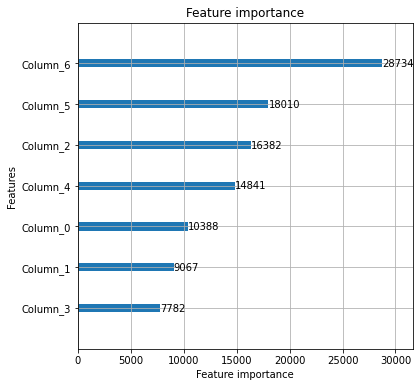

In [32]:
# Feature Importance
#column_4: Admission_deposit column_2: visitors with patients
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=(6,6))
plot_importance(lgbm, max_num_features=15, ax=ax)

### 학습된 입원기간 시각화

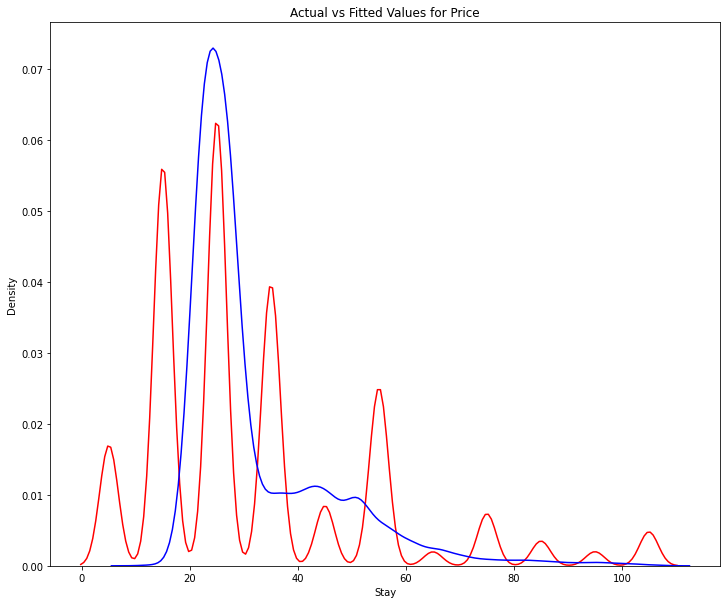

In [33]:
# DISTRIBUTION PLOT Training

plt.figure(figsize=(width, height))

ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(lgbm_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values for Price')


plt.show()
plt.close()



# 4. 성능 개선하기

In [39]:

kf = KFold(n_splits = 10)
df = pd.DataFrame(columns = ['Department', 'Type of Admission','Visitors with Patient', 'Severity of Illness', 
                                 'Available Extra Rooms in Hospital', 'Age','Admission_Deposit','mae','Stay'])
for train_index, test_index in kf.split(X_data):
    X_train, X_test = X_data.loc[train_index,:],X_data.loc[test_index,:]
    y_train, y_test = y_data.loc[train_index], y_data.loc[test_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference = lgb_train)
    lgbm = lgb.train(hyper_params, lgb_train, num_boost_round=1000, valid_sets = lgb_eval, early_stopping_rounds =200)
    lgb_val_pred = lgbm.predict(X_test)
   
    
     #for 돌면서 mae 추가하기 
    difference = y_test - lgb_val_pred 
    abs_diff = abs(difference)
    
    mae_test = pd.concat([X_test, abs_diff], axis = 1)
    mae_test.rename(columns = {'Stay':'mae'}, inplace = True)
    
    mae_test = pd.concat([mae_test, y_test], axis=1)
    small_mae = mae_test[mae_test['mae'] < 40]
    df = pd.concat([df, small_mae], axis=0)

small_mae_final = df

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 21.5764	valid_0's l1: 15.9909
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 21.5342	valid_0's l1: 15.958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 21.4924	valid_0's l1: 15.9252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 21.4509	valid_0's l1: 15.8926
[5]	valid_0's rmse: 21.4104	valid_0's l1: 15.8605
[LightGBM] [Warning] No further splits with positive gain, best 

[98]	valid_0's rmse: 19.0196	valid_0's l1: 14.068
[99]	valid_0's rmse: 18.9982	valid_0's l1: 14.0521
[100]	valid_0's rmse: 18.977	valid_0's l1: 14.0362
[101]	valid_0's rmse: 18.956	valid_0's l1: 14.0205
[102]	valid_0's rmse: 18.9356	valid_0's l1: 14.0055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[103]	valid_0's rmse: 18.9151	valid_0's l1: 13.99
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[104]	valid_0's rmse: 18.895	valid_0's l1: 13.9752
[105]	valid_0's rmse: 18.8751	valid_0's l1: 13.9605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's rmse: 18.8557	valid_0's l1: 13.9458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's rmse: 18.8358	valid_0's l1: 13.9308
[108]	valid_0's rmse: 18.8164	valid_0's l1: 13.9163
[109]	valid_0's rmse: 18.7971	valid_0's l1: 13.9021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	val

[189]	valid_0's rmse: 17.758	valid_0's l1: 13.0569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's rmse: 17.7472	valid_0's l1: 13.0472
[191]	valid_0's rmse: 17.7366	valid_0's l1: 13.0376
[192]	valid_0's rmse: 17.726	valid_0's l1: 13.0279
[193]	valid_0's rmse: 17.7156	valid_0's l1: 13.0185
[194]	valid_0's rmse: 17.7054	valid_0's l1: 13.0091
[195]	valid_0's rmse: 17.7034	valid_0's l1: 13.0075
[196]	valid_0's rmse: 17.6932	valid_0's l1: 12.9982
[197]	valid_0's rmse: 17.6831	valid_0's l1: 12.9889
[198]	valid_0's rmse: 17.6731	valid_0's l1: 12.9797
[199]	valid_0's rmse: 17.6636	valid_0's l1: 12.971
[200]	valid_0's rmse: 17.6537	valid_0's l1: 12.962
[201]	valid_0's rmse: 17.6441	valid_0's l1: 12.9531
[202]	valid_0's rmse: 17.636	valid_0's l1: 12.9454
[203]	valid_0's rmse: 17.6267	valid_0's l1: 12.9369
[204]	valid_0's rmse: 17.6176	valid_0's l1: 12.9285
[205]	valid_0's rmse: 17.6084	valid_0's l1: 12.9199
[206]	valid_0's rmse: 17.5989	valid_0's l1: 12

[281]	valid_0's rmse: 17.1492	valid_0's l1: 12.4848
[282]	valid_0's rmse: 17.144	valid_0's l1: 12.4799
[283]	valid_0's rmse: 17.1388	valid_0's l1: 12.4751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's rmse: 17.1337	valid_0's l1: 12.4702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	valid_0's rmse: 17.1287	valid_0's l1: 12.4655
[286]	valid_0's rmse: 17.1237	valid_0's l1: 12.4609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[287]	valid_0's rmse: 17.1185	valid_0's l1: 12.4561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[288]	valid_0's rmse: 17.1133	valid_0's l1: 12.4511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[289]	valid_0's rmse: 17.1085	valid_0's l1: 12.4467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[290]	valid_0's rmse: 17.1037	valid_0's l1: 12.4421
[291]	valid_0's rmse: 17.0996	v

[369]	valid_0's rmse: 16.8546	valid_0's l1: 12.2248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's rmse: 16.852	valid_0's l1: 12.2224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's rmse: 16.8514	valid_0's l1: 12.2223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's rmse: 16.8488	valid_0's l1: 12.22
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's rmse: 16.8466	valid_0's l1: 12.2181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's rmse: 16.844	valid_0's l1: 12.2157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's rmse: 16.8414	valid_0's l1: 12.2134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's rmse: 16.8393	valid_0's l1: 12.2115
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[448]	valid_0's rmse: 16.7118	valid_0's l1: 12.0928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[449]	valid_0's rmse: 16.7103	valid_0's l1: 12.0914
[450]	valid_0's rmse: 16.7091	valid_0's l1: 12.0901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[451]	valid_0's rmse: 16.7078	valid_0's l1: 12.089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[452]	valid_0's rmse: 16.7066	valid_0's l1: 12.0879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[453]	valid_0's rmse: 16.7054	valid_0's l1: 12.0868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's rmse: 16.705	valid_0's l1: 12.0869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's rmse: 16.7038	valid_0's l1: 12.0859
[456]	valid_0's rmse: 16.7024	valid_0's l1: 12.0844
[457]	val

[521]	valid_0's rmse: 16.6317	valid_0's l1: 12.0193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[522]	valid_0's rmse: 16.6306	valid_0's l1: 12.0182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[523]	valid_0's rmse: 16.6295	valid_0's l1: 12.017
[524]	valid_0's rmse: 16.6288	valid_0's l1: 12.0163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[525]	valid_0's rmse: 16.6277	valid_0's l1: 12.0152
[526]	valid_0's rmse: 16.6267	valid_0's l1: 12.0141
[527]	valid_0's rmse: 16.6256	valid_0's l1: 12.0129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[528]	valid_0's rmse: 16.6252	valid_0's l1: 12.013
[529]	valid_0's rmse: 16.6242	valid_0's l1: 12.0119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[530]	valid_0's rmse: 16.6238	valid_0's l1: 12.0119
[531]	valid_0's rmse: 16.6229	valid_0's l1: 12.011
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[597]	valid_0's rmse: 16.5779	valid_0's l1: 11.9687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[598]	valid_0's rmse: 16.5772	valid_0's l1: 11.9679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[599]	valid_0's rmse: 16.5765	valid_0's l1: 11.967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's rmse: 16.5765	valid_0's l1: 11.9672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[601]	valid_0's rmse: 16.5762	valid_0's l1: 11.9672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's rmse: 16.5759	valid_0's l1: 11.9673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid_0's rmse: 16.5753	valid_0's l1: 11.9667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	valid_0's rmse: 16.575	valid_0'

[666]	valid_0's rmse: 16.5459	valid_0's l1: 11.938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[667]	valid_0's rmse: 16.5454	valid_0's l1: 11.9376
[668]	valid_0's rmse: 16.545	valid_0's l1: 11.9371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[669]	valid_0's rmse: 16.5446	valid_0's l1: 11.9367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[670]	valid_0's rmse: 16.5442	valid_0's l1: 11.9362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	valid_0's rmse: 16.5438	valid_0's l1: 11.9357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	valid_0's rmse: 16.5435	valid_0's l1: 11.9354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	valid_0's rmse: 16.5431	valid_0's l1: 11.9349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	valid_0's rmse: 16.543	valid_0's l1: 11.9351
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[733]	valid_0's rmse: 16.526	valid_0's l1: 11.9171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[734]	valid_0's rmse: 16.5256	valid_0's l1: 11.9167
[735]	valid_0's rmse: 16.5252	valid_0's l1: 11.9163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[736]	valid_0's rmse: 16.5248	valid_0's l1: 11.916
[737]	valid_0's rmse: 16.5244	valid_0's l1: 11.9156
[738]	valid_0's rmse: 16.5241	valid_0's l1: 11.9152
[739]	valid_0's rmse: 16.5237	valid_0's l1: 11.9149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	valid_0's rmse: 16.5233	valid_0's l1: 11.9146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	valid_0's rmse: 16.5229	valid_0's l1: 11.9143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	valid_0's rmse: 16.5227	valid_0's l1: 11.914
[LightGBM] [Warning] No further s

[805]	valid_0's rmse: 16.509	valid_0's l1: 11.9046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	valid_0's rmse: 16.5088	valid_0's l1: 11.9045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	valid_0's rmse: 16.5086	valid_0's l1: 11.9043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	valid_0's rmse: 16.5085	valid_0's l1: 11.9044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	valid_0's rmse: 16.5084	valid_0's l1: 11.9043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	valid_0's rmse: 16.5083	valid_0's l1: 11.9042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	valid_0's rmse: 16.508	valid_0's l1: 11.9039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	valid_0's rmse: 16.5078	valid_0's l1: 11.9038
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	valid_0's rmse: 16.499	valid_0's l1: 11.8982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	valid_0's rmse: 16.4989	valid_0's l1: 11.8982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	valid_0's rmse: 16.4988	valid_0's l1: 11.8981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	valid_0's rmse: 16.4988	valid_0's l1: 11.8982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	valid_0's rmse: 16.4988	valid_0's l1: 11.8983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	valid_0's rmse: 16.4986	valid_0's l1: 11.8982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	valid_0's rmse: 16.4985	valid_0's l1: 11.898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	valid_0's rmse: 16.4982	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[937]	valid_0's rmse: 16.4919	valid_0's l1: 11.8937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[938]	valid_0's rmse: 16.4918	valid_0's l1: 11.8937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	valid_0's rmse: 16.4918	valid_0's l1: 11.8937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	valid_0's rmse: 16.4917	valid_0's l1: 11.8937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	valid_0's rmse: 16.4916	valid_0's l1: 11.8936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	valid_0's rmse: 16.4915	valid_0's l1: 11.8934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	valid_0's rmse: 16.4914	valid_0's l1: 11.8933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	valid_0's rmse: 16.4913	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1007]	valid_0's rmse: 16.4859	valid_0's l1: 11.8898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1008]	valid_0's rmse: 16.4859	valid_0's l1: 11.8897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1009]	valid_0's rmse: 16.4859	valid_0's l1: 11.8897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1010]	valid_0's rmse: 16.4858	valid_0's l1: 11.8896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1011]	valid_0's rmse: 16.4857	valid_0's l1: 11.8896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1012]	valid_0's rmse: 16.4855	valid_0's l1: 11.8895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1013]	valid_0's rmse: 16.4853	valid_0's l1: 11.8894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1014]	valid_0's rmse: 16.485

[1075]	valid_0's rmse: 16.4805	valid_0's l1: 11.8884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1076]	valid_0's rmse: 16.4804	valid_0's l1: 11.8882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1077]	valid_0's rmse: 16.4804	valid_0's l1: 11.8883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1078]	valid_0's rmse: 16.4803	valid_0's l1: 11.8882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1079]	valid_0's rmse: 16.4803	valid_0's l1: 11.8882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1080]	valid_0's rmse: 16.4802	valid_0's l1: 11.8881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1081]	valid_0's rmse: 16.4802	valid_0's l1: 11.8881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1082]	valid_0's rmse: 16.4801	valid_0's l1: 11.8881
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1141]	valid_0's rmse: 16.4772	valid_0's l1: 11.8871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1142]	valid_0's rmse: 16.4772	valid_0's l1: 11.8872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1143]	valid_0's rmse: 16.4772	valid_0's l1: 11.8872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1144]	valid_0's rmse: 16.4771	valid_0's l1: 11.8872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1145]	valid_0's rmse: 16.4771	valid_0's l1: 11.8872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1146]	valid_0's rmse: 16.477	valid_0's l1: 11.8872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1147]	valid_0's rmse: 16.477	valid_0's l1: 11.8872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1148]	valid_0's rmse: 16.4769	

[1206]	valid_0's rmse: 16.4736	valid_0's l1: 11.8856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1207]	valid_0's rmse: 16.4735	valid_0's l1: 11.8856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1208]	valid_0's rmse: 16.4734	valid_0's l1: 11.8855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1209]	valid_0's rmse: 16.4734	valid_0's l1: 11.8856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1210]	valid_0's rmse: 16.4733	valid_0's l1: 11.8856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1211]	valid_0's rmse: 16.4732	valid_0's l1: 11.8855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1212]	valid_0's rmse: 16.4731	valid_0's l1: 11.8855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1213]	valid_0's rmse: 16.4729	valid_0's l1: 11.8855
[LightGBM] [Warning] No further splits with positiv

[1272]	valid_0's rmse: 16.4708	valid_0's l1: 11.8859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1273]	valid_0's rmse: 16.4709	valid_0's l1: 11.886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1274]	valid_0's rmse: 16.4709	valid_0's l1: 11.886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1275]	valid_0's rmse: 16.4709	valid_0's l1: 11.886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1276]	valid_0's rmse: 16.4709	valid_0's l1: 11.8861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1277]	valid_0's rmse: 16.4709	valid_0's l1: 11.8862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1278]	valid_0's rmse: 16.4709	valid_0's l1: 11.8862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1279]	valid_0's rmse: 16.4709	valid_0's l1: 11.8861
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1341]	valid_0's rmse: 16.4682	valid_0's l1: 11.8851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1342]	valid_0's rmse: 16.4683	valid_0's l1: 11.8851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1343]	valid_0's rmse: 16.4683	valid_0's l1: 11.8851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1344]	valid_0's rmse: 16.4683	valid_0's l1: 11.8852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1345]	valid_0's rmse: 16.4683	valid_0's l1: 11.8852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1346]	valid_0's rmse: 16.4683	valid_0's l1: 11.8852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1347]	valid_0's rmse: 16.4684	valid_0's l1: 11.8852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1348]	valid_0's rmse: 16.468

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1406]	valid_0's rmse: 16.468	valid_0's l1: 11.8864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1407]	valid_0's rmse: 16.468	valid_0's l1: 11.8863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1408]	valid_0's rmse: 16.468	valid_0's l1: 11.8863
[1409]	valid_0's rmse: 16.4679	valid_0's l1: 11.8863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1410]	valid_0's rmse: 16.4679	valid_0's l1: 11.8863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1411]	valid_0's rmse: 16.4678	valid_0's l1: 11.8862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1412]	valid_0's rmse: 16.4678	valid_0's l1: 11.8861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1413]	valid_0's rmse: 16.4678	valid_0's l1: 11.8861
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1472]	valid_0's rmse: 16.4657	valid_0's l1: 11.8857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1473]	valid_0's rmse: 16.4657	valid_0's l1: 11.8857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1474]	valid_0's rmse: 16.4656	valid_0's l1: 11.8857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1475]	valid_0's rmse: 16.4656	valid_0's l1: 11.8857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1476]	valid_0's rmse: 16.4656	valid_0's l1: 11.8857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1477]	valid_0's rmse: 16.4656	valid_0's l1: 11.8856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1478]	valid_0's rmse: 16.4655	valid_0's l1: 11.8856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1479]	valid_0's rmse: 16.465

[1538]	valid_0's rmse: 16.4654	valid_0's l1: 11.8869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1539]	valid_0's rmse: 16.4654	valid_0's l1: 11.887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1540]	valid_0's rmse: 16.4654	valid_0's l1: 11.887
Early stopping, best iteration is:
[1340]	valid_0's rmse: 16.4682	valid_0's l1: 11.8851
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 21.325	valid_0's l1: 15.931
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further

[87]	valid_0's rmse: 19.1363	valid_0's l1: 14.2417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's rmse: 19.1154	valid_0's l1: 14.2259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's rmse: 19.0944	valid_0's l1: 14.2101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's rmse: 19.0738	valid_0's l1: 14.1946
[91]	valid_0's rmse: 19.0531	valid_0's l1: 14.1789
[92]	valid_0's rmse: 19.0329	valid_0's l1: 14.1636
[93]	valid_0's rmse: 19.0123	valid_0's l1: 14.1479
[94]	valid_0's rmse: 18.9918	valid_0's l1: 14.1323
[95]	valid_0's rmse: 18.9718	valid_0's l1: 14.1171
[96]	valid_0's rmse: 18.9518	valid_0's l1: 14.1018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's rmse: 18.9483	valid_0's l1: 14.099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	valid_0's rmse: 18.9284	valid_0's l1: 14.0836
[99]	valid_0's

[195]	valid_0's rmse: 17.7243	valid_0's l1: 13.065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[196]	valid_0's rmse: 17.7153	valid_0's l1: 13.0562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[197]	valid_0's rmse: 17.7063	valid_0's l1: 13.0474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[198]	valid_0's rmse: 17.6973	valid_0's l1: 13.0388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's rmse: 17.6887	valid_0's l1: 13.0305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's rmse: 17.68	valid_0's l1: 13.0219
[201]	valid_0's rmse: 17.6712	valid_0's l1: 13.0133
[202]	valid_0's rmse: 17.6638	valid_0's l1: 13.006
[203]	valid_0's rmse: 17.6551	valid_0's l1: 12.9975
[204]	valid_0's rmse: 17.647	valid_0's l1: 12.9896
[205]	valid_0's rmse: 17.6385	valid_0's l1: 12.9812
[206]	valid_0's rmse: 17.6301	valid_0's l1: 12.9728
[207]	

[280]	valid_0's rmse: 17.2337	valid_0's l1: 12.5761
[281]	valid_0's rmse: 17.2327	valid_0's l1: 12.5757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	valid_0's rmse: 17.2281	valid_0's l1: 12.571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's rmse: 17.2235	valid_0's l1: 12.5664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's rmse: 17.219	valid_0's l1: 12.5618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	valid_0's rmse: 17.2147	valid_0's l1: 12.5576
[286]	valid_0's rmse: 17.2101	valid_0's l1: 12.5529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[287]	valid_0's rmse: 17.2055	valid_0's l1: 12.5484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[288]	valid_0's rmse: 17.201	valid_0's l1: 12.5438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[289]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's rmse: 16.9618	valid_0's l1: 12.3179
[377]	valid_0's rmse: 16.9596	valid_0's l1: 12.3158
[378]	valid_0's rmse: 16.9574	valid_0's l1: 12.3137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's rmse: 16.9552	valid_0's l1: 12.3116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's rmse: 16.9529	valid_0's l1: 12.3092
[381]	valid_0's rmse: 16.9508	valid_0's l1: 12.3071
[382]	valid_0's rmse: 16.9487	valid_0's l1: 12.305
[383]	valid_0's rmse: 16.9467	valid_0's l1: 12.303
[384]	valid_0's rmse: 16.945	valid_0's l1: 12.3014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[385]	valid_0's rmse: 16.9445	valid_0's l1: 12.3014
[386]	valid_0's rmse: 16.9425	valid_0's l1: 12.2994
[387]	valid_0's rmse: 16.9405	valid_0's l1: 12.2974
[388]	valid_0's rmse: 16.9385	valid_0's l1: 12.2955
[389]	valid_0's rmse: 16.93

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's rmse: 16.847	valid_0's l1: 12.2048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's rmse: 16.8459	valid_0's l1: 12.2037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[456]	valid_0's rmse: 16.8447	valid_0's l1: 12.2023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[457]	valid_0's rmse: 16.8435	valid_0's l1: 12.2011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[458]	valid_0's rmse: 16.8423	valid_0's l1: 12.1998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	valid_0's rmse: 16.8419	valid_0's l1: 12.1997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[460]	valid_0's rmse: 16.8416	valid_0's l1: 12.1997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[461]	valid_0's rmse: 16.8404	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[523]	valid_0's rmse: 16.7841	valid_0's l1: 12.1393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[524]	valid_0's rmse: 16.7834	valid_0's l1: 12.1387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[525]	valid_0's rmse: 16.7825	valid_0's l1: 12.1378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[526]	valid_0's rmse: 16.7817	valid_0's l1: 12.1368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[527]	valid_0's rmse: 16.7809	valid_0's l1: 12.136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[528]	valid_0's rmse: 16.7805	valid_0's l1: 12.1358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[529]	valid_0's rmse: 16.7796	valid_0's l1: 12.135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[530]	valid_0's rmse: 16.7793	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[589]	valid_0's rmse: 16.7425	valid_0's l1: 12.0966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[590]	valid_0's rmse: 16.7421	valid_0's l1: 12.0965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[591]	valid_0's rmse: 16.7419	valid_0's l1: 12.0965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[592]	valid_0's rmse: 16.7413	valid_0's l1: 12.0957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	valid_0's rmse: 16.7411	valid_0's l1: 12.0958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[594]	valid_0's rmse: 16.7409	valid_0's l1: 12.0957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[595]	valid_0's rmse: 16.7402	valid_0's l1: 12.095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	valid_0's rmse: 16.7396	valid_0

[657]	valid_0's rmse: 16.7125	valid_0's l1: 12.0662
[658]	valid_0's rmse: 16.7122	valid_0's l1: 12.0657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[659]	valid_0's rmse: 16.712	valid_0's l1: 12.0658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[660]	valid_0's rmse: 16.7116	valid_0's l1: 12.0654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[661]	valid_0's rmse: 16.7115	valid_0's l1: 12.0655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[662]	valid_0's rmse: 16.7114	valid_0's l1: 12.0657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[663]	valid_0's rmse: 16.7111	valid_0's l1: 12.0653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[664]	valid_0's rmse: 16.7109	valid_0's l1: 12.0649
[665]	valid_0's rmse: 16.7106	valid_0's l1: 12.0645
[666]	valid_0's rmse: 16.7104	valid_0's l1: 12.0641
[LightGBM] [Warning] No further

[725]	valid_0's rmse: 16.6919	valid_0's l1: 12.0447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[726]	valid_0's rmse: 16.6915	valid_0's l1: 12.0443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[727]	valid_0's rmse: 16.6912	valid_0's l1: 12.0442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[728]	valid_0's rmse: 16.6909	valid_0's l1: 12.0439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's rmse: 16.6906	valid_0's l1: 12.0435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's rmse: 16.6903	valid_0's l1: 12.0431
[731]	valid_0's rmse: 16.6899	valid_0's l1: 12.0427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's rmse: 16.6898	valid_0's l1: 12.0429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[733]	valid_0's rmse: 16.6894	valid_0's l1: 12.0427
[LightG

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[793]	valid_0's rmse: 16.6768	valid_0's l1: 12.0317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[794]	valid_0's rmse: 16.6766	valid_0's l1: 12.0315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[795]	valid_0's rmse: 16.6764	valid_0's l1: 12.0313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[796]	valid_0's rmse: 16.6761	valid_0's l1: 12.031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[797]	valid_0's rmse: 16.6758	valid_0's l1: 12.0308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[798]	valid_0's rmse: 16.6755	valid_0's l1: 12.0305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[799]	valid_0's rmse: 16.6751	valid_0's l1: 12.0301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[800]	valid_0's rmse: 16.6749	valid_0

[858]	valid_0's rmse: 16.6655	valid_0's l1: 12.0229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[859]	valid_0's rmse: 16.6653	valid_0's l1: 12.0226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[860]	valid_0's rmse: 16.665	valid_0's l1: 12.0224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[861]	valid_0's rmse: 16.6649	valid_0's l1: 12.0223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[862]	valid_0's rmse: 16.6649	valid_0's l1: 12.0222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[863]	valid_0's rmse: 16.6648	valid_0's l1: 12.022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[864]	valid_0's rmse: 16.6647	valid_0's l1: 12.0219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[865]	valid_0's rmse: 16.6646	valid_0's l1: 12.0217
[LightGBM] [Warning] No further splits with positive gain, be

[923]	valid_0's rmse: 16.6572	valid_0's l1: 12.0155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[924]	valid_0's rmse: 16.6572	valid_0's l1: 12.0154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[925]	valid_0's rmse: 16.6571	valid_0's l1: 12.0152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[926]	valid_0's rmse: 16.6569	valid_0's l1: 12.0152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[927]	valid_0's rmse: 16.6568	valid_0's l1: 12.015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[928]	valid_0's rmse: 16.6567	valid_0's l1: 12.0149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[929]	valid_0's rmse: 16.6566	valid_0's l1: 12.0148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[930]	valid_0's rmse: 16.6565	valid_0's l1: 12.0147
[LightGBM] [Warning] No further splits with positive gain, b

[991]	valid_0's rmse: 16.6509	valid_0's l1: 12.0106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[992]	valid_0's rmse: 16.6508	valid_0's l1: 12.0106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[993]	valid_0's rmse: 16.6507	valid_0's l1: 12.0105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[994]	valid_0's rmse: 16.6507	valid_0's l1: 12.0104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[995]	valid_0's rmse: 16.6506	valid_0's l1: 12.0104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[996]	valid_0's rmse: 16.6505	valid_0's l1: 12.0103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[997]	valid_0's rmse: 16.6504	valid_0's l1: 12.0103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[998]	valid_0's rmse: 16.6503	valid_0's l1: 12.0102
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1058]	valid_0's rmse: 16.6443	valid_0's l1: 12.0067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1059]	valid_0's rmse: 16.6442	valid_0's l1: 12.0066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1060]	valid_0's rmse: 16.644	valid_0's l1: 12.0065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1061]	valid_0's rmse: 16.6441	valid_0's l1: 12.0066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1062]	valid_0's rmse: 16.644	valid_0's l1: 12.0066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1063]	valid_0's rmse: 16.6439	valid_0's l1: 12.0066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1064]	valid_0's rmse: 16.6439	valid_0's l1: 12.0066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1065]	valid_0's rmse: 16.6439	

[1122]	valid_0's rmse: 16.6399	valid_0's l1: 12.0028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1123]	valid_0's rmse: 16.6398	valid_0's l1: 12.0027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1124]	valid_0's rmse: 16.6397	valid_0's l1: 12.0026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1125]	valid_0's rmse: 16.6397	valid_0's l1: 12.0026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1126]	valid_0's rmse: 16.6395	valid_0's l1: 12.0024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1127]	valid_0's rmse: 16.6395	valid_0's l1: 12.0024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1128]	valid_0's rmse: 16.6394	valid_0's l1: 12.0024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1129]	valid_0's rmse: 16.6394	valid_0's l1: 12.0024
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1191]	valid_0's rmse: 16.6361	valid_0's l1: 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1192]	valid_0's rmse: 16.636	valid_0's l1: 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1193]	valid_0's rmse: 16.6359	valid_0's l1: 12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1194]	valid_0's rmse: 16.6357	valid_0's l1: 11.9998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1195]	valid_0's rmse: 16.6355	valid_0's l1: 11.9997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1196]	valid_0's rmse: 16.6353	valid_0's l1: 11.9995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1197]	valid_0's rmse: 16.6351	valid_0's l1: 11.9994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1198]	valid_0's rmse: 16.635	valid_0's l1: 1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1257]	valid_0's rmse: 16.6308	valid_0's l1: 11.9979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1258]	valid_0's rmse: 16.6307	valid_0's l1: 11.9979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1259]	valid_0's rmse: 16.6307	valid_0's l1: 11.9979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1260]	valid_0's rmse: 16.6307	valid_0's l1: 11.9979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1261]	valid_0's rmse: 16.6306	valid_0's l1: 11.9978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1262]	valid_0's rmse: 16.6306	valid_0's l1: 11.9977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1263]	valid_0's rmse: 16.6305	valid_0's l1: 11.9976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1264]	valid_0's rmse: 16.630

[1324]	valid_0's rmse: 16.6272	valid_0's l1: 11.9965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1325]	valid_0's rmse: 16.6272	valid_0's l1: 11.9965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1326]	valid_0's rmse: 16.6271	valid_0's l1: 11.9964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1327]	valid_0's rmse: 16.6271	valid_0's l1: 11.9964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1328]	valid_0's rmse: 16.6271	valid_0's l1: 11.9963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1329]	valid_0's rmse: 16.627	valid_0's l1: 11.9963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1330]	valid_0's rmse: 16.627	valid_0's l1: 11.9963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1331]	valid_0's rmse: 16.6269	valid_0's l1: 11.9962
[LightGBM] [Warning] No further splits with positive 

[1390]	valid_0's rmse: 16.6257	valid_0's l1: 11.996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1391]	valid_0's rmse: 16.6257	valid_0's l1: 11.996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1392]	valid_0's rmse: 16.6257	valid_0's l1: 11.996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1393]	valid_0's rmse: 16.6257	valid_0's l1: 11.9961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1394]	valid_0's rmse: 16.6256	valid_0's l1: 11.9961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1395]	valid_0's rmse: 16.6256	valid_0's l1: 11.9961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1396]	valid_0's rmse: 16.6256	valid_0's l1: 11.9961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1397]	valid_0's rmse: 16.6256	valid_0's l1: 11.9961
[LightGBM] [Warning] No further splits with positive g

[1455]	valid_0's rmse: 16.6229	valid_0's l1: 11.9953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1456]	valid_0's rmse: 16.6229	valid_0's l1: 11.9953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1457]	valid_0's rmse: 16.6229	valid_0's l1: 11.9953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1458]	valid_0's rmse: 16.6229	valid_0's l1: 11.9953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1459]	valid_0's rmse: 16.6229	valid_0's l1: 11.9954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1460]	valid_0's rmse: 16.6229	valid_0's l1: 11.9954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1461]	valid_0's rmse: 16.6228	valid_0's l1: 11.9954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1462]	valid_0's rmse: 16.6228	valid_0's l1: 11.9954
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1523]	valid_0's rmse: 16.6212	valid_0's l1: 11.9955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1524]	valid_0's rmse: 16.6213	valid_0's l1: 11.9955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1525]	valid_0's rmse: 16.6213	valid_0's l1: 11.9955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1526]	valid_0's rmse: 16.6213	valid_0's l1: 11.9955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1527]	valid_0's rmse: 16.6213	valid_0's l1: 11.9955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1528]	valid_0's rmse: 16.6214	valid_0's l1: 11.9955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1529]	valid_0's rmse: 16.6214	valid_0's l1: 11.9955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1530]	valid_0's rmse: 16.621

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1592]	valid_0's rmse: 16.6209	valid_0's l1: 11.9961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1593]	valid_0's rmse: 16.6208	valid_0's l1: 11.996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1594]	valid_0's rmse: 16.6208	valid_0's l1: 11.996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1595]	valid_0's rmse: 16.6207	valid_0's l1: 11.9959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1596]	valid_0's rmse: 16.6207	valid_0's l1: 11.9959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1597]	valid_0's rmse: 16.6206	valid_0's l1: 11.9958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1598]	valid_0's rmse: 16.6206	valid_0's l1: 11.9958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1599]	valid_0's rmse: 16.6205	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1660]	valid_0's rmse: 16.6193	valid_0's l1: 11.9954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1661]	valid_0's rmse: 16.6193	valid_0's l1: 11.9954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1662]	valid_0's rmse: 16.6193	valid_0's l1: 11.9954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1663]	valid_0's rmse: 16.6193	valid_0's l1: 11.9955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1664]	valid_0's rmse: 16.6193	valid_0's l1: 11.9955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1665]	valid_0's rmse: 16.6193	valid_0's l1: 11.9955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1666]	valid_0's rmse: 16.6193	valid_0's l1: 11.9956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1667]	valid_0's rmse: 16.619

[61]	valid_0's rmse: 19.3805	valid_0's l1: 14.451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's rmse: 19.3556	valid_0's l1: 14.4329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's rmse: 19.3309	valid_0's l1: 14.415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's rmse: 19.3072	valid_0's l1: 14.3976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's rmse: 19.2861	valid_0's l1: 14.3829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's rmse: 19.2621	valid_0's l1: 14.3652
[67]	valid_0's rmse: 19.2578	valid_0's l1: 14.3619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's rmse: 19.234	valid_0's l1: 14.3445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's rmse: 19.2103	valid_0's l1: 14.327
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's rmse: 17.8463	valid_0's l1: 13.251
[163]	valid_0's rmse: 17.8349	valid_0's l1: 13.2409
[164]	valid_0's rmse: 17.8236	valid_0's l1: 13.231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[165]	valid_0's rmse: 17.8125	valid_0's l1: 13.2213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[166]	valid_0's rmse: 17.8014	valid_0's l1: 13.2115
[167]	valid_0's rmse: 17.7918	valid_0's l1: 13.2028
[168]	valid_0's rmse: 17.7823	valid_0's l1: 13.1942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's rmse: 17.7712	valid_0's l1: 13.1839
[170]	valid_0's rmse: 17.7618	valid_0's l1: 13.1754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's rmse: 17.7509	valid_0's l1: 13.1653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's rmse: 17.7406	va

[270]	valid_0's rmse: 17.0974	valid_0's l1: 12.5251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	valid_0's rmse: 17.0927	valid_0's l1: 12.5203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	valid_0's rmse: 17.0917	valid_0's l1: 12.5198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	valid_0's rmse: 17.0871	valid_0's l1: 12.5151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	valid_0's rmse: 17.0825	valid_0's l1: 12.5105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	valid_0's rmse: 17.0779	valid_0's l1: 12.5059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	valid_0's rmse: 17.0733	valid_0's l1: 12.5014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[277]	valid_0's rmse: 17.0688	valid_0's l1: 12.4969
[LightGBM] [Warning] No further splits with positive gain, 

[365]	valid_0's rmse: 16.8161	valid_0's l1: 12.2576
[366]	valid_0's rmse: 16.8137	valid_0's l1: 12.2553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[367]	valid_0's rmse: 16.8117	valid_0's l1: 12.2535
[368]	valid_0's rmse: 16.8092	valid_0's l1: 12.2509
[369]	valid_0's rmse: 16.807	valid_0's l1: 12.2489
[370]	valid_0's rmse: 16.8047	valid_0's l1: 12.2466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's rmse: 16.8042	valid_0's l1: 12.2466
[372]	valid_0's rmse: 16.8019	valid_0's l1: 12.2444
[373]	valid_0's rmse: 16.8	valid_0's l1: 12.2427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's rmse: 16.7978	valid_0's l1: 12.2405
[375]	valid_0's rmse: 16.7954	valid_0's l1: 12.2383
[376]	valid_0's rmse: 16.7936	valid_0's l1: 12.2367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's rmse: 16.7914	valid_0's l1: 12.2346
[378]	valid_0's rmse: 16.789

[451]	valid_0's rmse: 16.6858	valid_0's l1: 12.1317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[452]	valid_0's rmse: 16.6847	valid_0's l1: 12.1307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[453]	valid_0's rmse: 16.6836	valid_0's l1: 12.1297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's rmse: 16.6833	valid_0's l1: 12.1297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[455]	valid_0's rmse: 16.6822	valid_0's l1: 12.1288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[456]	valid_0's rmse: 16.681	valid_0's l1: 12.1275
[457]	valid_0's rmse: 16.6799	valid_0's l1: 12.1263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[458]	valid_0's rmse: 16.6787	valid_0's l1: 12.125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	valid_0's rmse: 16.6784	valid_0's l1: 12.125
[LightGBM]

[519]	valid_0's rmse: 16.6258	valid_0's l1: 12.0698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's rmse: 16.625	valid_0's l1: 12.0688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[521]	valid_0's rmse: 16.6241	valid_0's l1: 12.0677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[522]	valid_0's rmse: 16.6231	valid_0's l1: 12.0667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[523]	valid_0's rmse: 16.6222	valid_0's l1: 12.0657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[524]	valid_0's rmse: 16.6215	valid_0's l1: 12.065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[525]	valid_0's rmse: 16.6208	valid_0's l1: 12.0642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[526]	valid_0's rmse: 16.6199	valid_0's l1: 12.0633
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[595]	valid_0's rmse: 16.5807	valid_0's l1: 12.0225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	valid_0's rmse: 16.5801	valid_0's l1: 12.0218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[597]	valid_0's rmse: 16.5794	valid_0's l1: 12.0211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[598]	valid_0's rmse: 16.5788	valid_0's l1: 12.0203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[599]	valid_0's rmse: 16.5782	valid_0's l1: 12.0195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's rmse: 16.578	valid_0's l1: 12.0195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[601]	valid_0's rmse: 16.5777	valid_0's l1: 12.0194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's rmse: 16.5775	valid_0

[663]	valid_0's rmse: 16.5525	valid_0's l1: 11.993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[664]	valid_0's rmse: 16.5521	valid_0's l1: 11.9925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[665]	valid_0's rmse: 16.5518	valid_0's l1: 11.9921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[666]	valid_0's rmse: 16.5515	valid_0's l1: 11.9917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[667]	valid_0's rmse: 16.5512	valid_0's l1: 11.9912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[668]	valid_0's rmse: 16.5509	valid_0's l1: 11.9909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[669]	valid_0's rmse: 16.5506	valid_0's l1: 11.9905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[670]	valid_0's rmse: 16.5503	valid_0's l1: 11.9902
[LightGBM] [Warning] No further splits with positive gain, b

[732]	valid_0's rmse: 16.5332	valid_0's l1: 11.9725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[733]	valid_0's rmse: 16.5329	valid_0's l1: 11.9723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[734]	valid_0's rmse: 16.5325	valid_0's l1: 11.972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[735]	valid_0's rmse: 16.5322	valid_0's l1: 11.9716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[736]	valid_0's rmse: 16.5319	valid_0's l1: 11.9713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[737]	valid_0's rmse: 16.5316	valid_0's l1: 11.971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	valid_0's rmse: 16.5313	valid_0's l1: 11.9707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	valid_0's rmse: 16.531	valid_0's l1: 11.9704
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[800]	valid_0's rmse: 16.5201	valid_0's l1: 11.96
[801]	valid_0's rmse: 16.52	valid_0's l1: 11.9599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[802]	valid_0's rmse: 16.5199	valid_0's l1: 11.9598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[803]	valid_0's rmse: 16.5199	valid_0's l1: 11.96
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[804]	valid_0's rmse: 16.5199	valid_0's l1: 11.9601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	valid_0's rmse: 16.5198	valid_0's l1: 11.9601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	valid_0's rmse: 16.5197	valid_0's l1: 11.96
[807]	valid_0's rmse: 16.5196	valid_0's l1: 11.9599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	valid_0's rmse: 16.5196	valid_0's l1: 11.9601
[809]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[867]	valid_0's rmse: 16.5113	valid_0's l1: 11.9533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[868]	valid_0's rmse: 16.5112	valid_0's l1: 11.9532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[869]	valid_0's rmse: 16.5112	valid_0's l1: 11.9532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[870]	valid_0's rmse: 16.5111	valid_0's l1: 11.9532
[871]	valid_0's rmse: 16.511	valid_0's l1: 11.9531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	valid_0's rmse: 16.5109	valid_0's l1: 11.953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	valid_0's rmse: 16.5108	valid_0's l1: 11.9529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	valid_0's rmse: 16.5107	valid_0's l1: 11.9528
[LightGBM] [Warning] No further splits with positive gain, be

[937]	valid_0's rmse: 16.5038	valid_0's l1: 11.948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[938]	valid_0's rmse: 16.5038	valid_0's l1: 11.948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	valid_0's rmse: 16.5038	valid_0's l1: 11.948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	valid_0's rmse: 16.5038	valid_0's l1: 11.9482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	valid_0's rmse: 16.5037	valid_0's l1: 11.948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	valid_0's rmse: 16.5036	valid_0's l1: 11.9479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	valid_0's rmse: 16.5035	valid_0's l1: 11.9479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	valid_0's rmse: 16.5034	valid_0's l1: 11.9478
[LightGBM] [Warning] No further splits with positive gain, best

[1007]	valid_0's rmse: 16.4976	valid_0's l1: 11.9435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1008]	valid_0's rmse: 16.4975	valid_0's l1: 11.9435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1009]	valid_0's rmse: 16.4975	valid_0's l1: 11.9434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1010]	valid_0's rmse: 16.4973	valid_0's l1: 11.9433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1011]	valid_0's rmse: 16.4972	valid_0's l1: 11.9432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1012]	valid_0's rmse: 16.4971	valid_0's l1: 11.9431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1013]	valid_0's rmse: 16.497	valid_0's l1: 11.9429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1014]	valid_0's rmse: 16.4969	valid_0's l1: 11.9428
[LightGBM] [Warning] No further splits with positive

[1076]	valid_0's rmse: 16.4912	valid_0's l1: 11.9387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1077]	valid_0's rmse: 16.4912	valid_0's l1: 11.9387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1078]	valid_0's rmse: 16.491	valid_0's l1: 11.9386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1079]	valid_0's rmse: 16.4909	valid_0's l1: 11.9385
[1080]	valid_0's rmse: 16.4908	valid_0's l1: 11.9383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1081]	valid_0's rmse: 16.4907	valid_0's l1: 11.9382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1082]	valid_0's rmse: 16.4906	valid_0's l1: 11.9382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1083]	valid_0's rmse: 16.4906	valid_0's l1: 11.9381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1084]	valid_0's rmse: 16.4905	valid_0's l1: 11.9381

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1143]	valid_0's rmse: 16.4862	valid_0's l1: 11.9355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1144]	valid_0's rmse: 16.4862	valid_0's l1: 11.9355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1145]	valid_0's rmse: 16.4861	valid_0's l1: 11.9355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1146]	valid_0's rmse: 16.4861	valid_0's l1: 11.9355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1147]	valid_0's rmse: 16.4861	valid_0's l1: 11.9354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1148]	valid_0's rmse: 16.486	valid_0's l1: 11.9354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1149]	valid_0's rmse: 16.486	valid_0's l1: 11.9353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1150]	valid_0's rmse: 16.4859	

[1207]	valid_0's rmse: 16.4829	valid_0's l1: 11.9325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1208]	valid_0's rmse: 16.4829	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1209]	valid_0's rmse: 16.4829	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1210]	valid_0's rmse: 16.4829	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1211]	valid_0's rmse: 16.4829	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1212]	valid_0's rmse: 16.4828	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1213]	valid_0's rmse: 16.4828	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1214]	valid_0's rmse: 16.4827	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positiv

[1273]	valid_0's rmse: 16.4812	valid_0's l1: 11.9328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1274]	valid_0's rmse: 16.4811	valid_0's l1: 11.9328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1275]	valid_0's rmse: 16.481	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1276]	valid_0's rmse: 16.481	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1277]	valid_0's rmse: 16.4809	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1278]	valid_0's rmse: 16.4809	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1279]	valid_0's rmse: 16.4808	valid_0's l1: 11.9328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1280]	valid_0's rmse: 16.4807	valid_0's l1: 11.9328
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1343]	valid_0's rmse: 16.4786	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1344]	valid_0's rmse: 16.4786	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1345]	valid_0's rmse: 16.4787	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1346]	valid_0's rmse: 16.4787	valid_0's l1: 11.9328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1347]	valid_0's rmse: 16.4787	valid_0's l1: 11.9328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1348]	valid_0's rmse: 16.4787	valid_0's l1: 11.9328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1349]	valid_0's rmse: 16.4787	valid_0's l1: 11.9329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1350]	valid_0's rmse: 16.478

[1411]	valid_0's rmse: 16.4775	valid_0's l1: 11.9334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1412]	valid_0's rmse: 16.4774	valid_0's l1: 11.9334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1413]	valid_0's rmse: 16.4773	valid_0's l1: 11.9333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1414]	valid_0's rmse: 16.4772	valid_0's l1: 11.9331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1415]	valid_0's rmse: 16.4772	valid_0's l1: 11.9332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1416]	valid_0's rmse: 16.4771	valid_0's l1: 11.9331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1417]	valid_0's rmse: 16.4771	valid_0's l1: 11.9332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1418]	valid_0's rmse: 16.477	valid_0's l1: 11.933
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1476]	valid_0's rmse: 16.4747	valid_0's l1: 11.9321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1477]	valid_0's rmse: 16.4746	valid_0's l1: 11.9321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1478]	valid_0's rmse: 16.4746	valid_0's l1: 11.9321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1479]	valid_0's rmse: 16.4746	valid_0's l1: 11.9321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1480]	valid_0's rmse: 16.4746	valid_0's l1: 11.9321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1481]	valid_0's rmse: 16.4746	valid_0's l1: 11.9322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1482]	valid_0's rmse: 16.4746	valid_0's l1: 11.9323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1483]	valid_0's rmse: 16.474

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1541]	valid_0's rmse: 16.4741	valid_0's l1: 11.9324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1542]	valid_0's rmse: 16.4741	valid_0's l1: 11.9324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1543]	valid_0's rmse: 16.4741	valid_0's l1: 11.9324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1544]	valid_0's rmse: 16.4741	valid_0's l1: 11.9324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1545]	valid_0's rmse: 16.4741	valid_0's l1: 11.9323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1546]	valid_0's rmse: 16.4741	valid_0's l1: 11.9324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1547]	valid_0's rmse: 16.4741	valid_0's l1: 11.9323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1548]	valid_0's rmse: 16.474

[1605]	valid_0's rmse: 16.4736	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1606]	valid_0's rmse: 16.4736	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1607]	valid_0's rmse: 16.4736	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1608]	valid_0's rmse: 16.4737	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1609]	valid_0's rmse: 16.4737	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1610]	valid_0's rmse: 16.4736	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1611]	valid_0's rmse: 16.4736	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1612]	valid_0's rmse: 16.4736	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1670]	valid_0's rmse: 16.4732	valid_0's l1: 11.9328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1671]	valid_0's rmse: 16.4732	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1672]	valid_0's rmse: 16.4731	valid_0's l1: 11.9327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1673]	valid_0's rmse: 16.4731	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1674]	valid_0's rmse: 16.4731	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1675]	valid_0's rmse: 16.4731	valid_0's l1: 11.9326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1676]	valid_0's rmse: 16.4731	valid_0's l1: 11.9325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1677]	valid_0's rmse: 16.473

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1740]	valid_0's rmse: 16.4725	valid_0's l1: 11.9323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1741]	valid_0's rmse: 16.4725	valid_0's l1: 11.9322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1742]	valid_0's rmse: 16.4725	valid_0's l1: 11.9323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1743]	valid_0's rmse: 16.4725	valid_0's l1: 11.9322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1744]	valid_0's rmse: 16.4725	valid_0's l1: 11.9322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1745]	valid_0's rmse: 16.4725	valid_0's l1: 11.9322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1746]	valid_0's rmse: 16.4725	valid_0's l1: 11.9322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1747]	valid_0's rmse: 16.472

[86]	valid_0's rmse: 19.7523	valid_0's l1: 14.6351
[87]	valid_0's rmse: 19.7319	valid_0's l1: 14.6207
[88]	valid_0's rmse: 19.7092	valid_0's l1: 14.604
[89]	valid_0's rmse: 19.6866	valid_0's l1: 14.5873
[90]	valid_0's rmse: 19.6643	valid_0's l1: 14.5708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's rmse: 19.6418	valid_0's l1: 14.5539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's rmse: 19.62	valid_0's l1: 14.5378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's rmse: 19.5978	valid_0's l1: 14.5212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's rmse: 19.5758	valid_0's l1: 14.5047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's rmse: 19.554	valid_0's l1: 14.4884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's rmse: 19.5325	valid_0's l1: 1

[182]	valid_0's rmse: 18.3141	valid_0's l1: 13.4893
[183]	valid_0's rmse: 18.3033	valid_0's l1: 13.4799
[184]	valid_0's rmse: 18.2936	valid_0's l1: 13.4712
[185]	valid_0's rmse: 18.2829	valid_0's l1: 13.4616
[186]	valid_0's rmse: 18.2721	valid_0's l1: 13.4519
[187]	valid_0's rmse: 18.2616	valid_0's l1: 13.4424
[188]	valid_0's rmse: 18.2513	valid_0's l1: 13.4332
[189]	valid_0's rmse: 18.241	valid_0's l1: 13.4241
[190]	valid_0's rmse: 18.2303	valid_0's l1: 13.4142
[191]	valid_0's rmse: 18.2199	valid_0's l1: 13.4045
[192]	valid_0's rmse: 18.2095	valid_0's l1: 13.3948
[193]	valid_0's rmse: 18.1993	valid_0's l1: 13.3853
[194]	valid_0's rmse: 18.1891	valid_0's l1: 13.3758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's rmse: 18.1872	valid_0's l1: 13.374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[196]	valid_0's rmse: 18.1771	valid_0's l1: 13.3646
[197]	valid_0's rmse: 18.1671	valid_0's l1: 13.3553
[LightGBM] [Warning]

[280]	valid_0's rmse: 17.6348	valid_0's l1: 12.8597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's rmse: 17.6337	valid_0's l1: 12.8591
[282]	valid_0's rmse: 17.6286	valid_0's l1: 12.8545
[283]	valid_0's rmse: 17.6235	valid_0's l1: 12.8499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's rmse: 17.6185	valid_0's l1: 12.8454
[285]	valid_0's rmse: 17.6134	valid_0's l1: 12.8409
[286]	valid_0's rmse: 17.6085	valid_0's l1: 12.8364
[287]	valid_0's rmse: 17.6034	valid_0's l1: 12.8317
[288]	valid_0's rmse: 17.5984	valid_0's l1: 12.8269
[289]	valid_0's rmse: 17.5936	valid_0's l1: 12.8226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[290]	valid_0's rmse: 17.5888	valid_0's l1: 12.8182
[291]	valid_0's rmse: 17.5846	valid_0's l1: 12.8144
[292]	valid_0's rmse: 17.5798	valid_0's l1: 12.81
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[293]	valid_0's rmse: 17.5

[374]	valid_0's rmse: 17.3246	valid_0's l1: 12.5866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's rmse: 17.3219	valid_0's l1: 12.5842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's rmse: 17.3196	valid_0's l1: 12.5823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's rmse: 17.317	valid_0's l1: 12.58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's rmse: 17.3144	valid_0's l1: 12.5778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's rmse: 17.3119	valid_0's l1: 12.5755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's rmse: 17.3092	valid_0's l1: 12.573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	valid_0's rmse: 17.3068	valid_0's l1: 12.5709
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[443]	valid_0's rmse: 17.1934	valid_0's l1: 12.4709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[444]	valid_0's rmse: 17.1929	valid_0's l1: 12.4707
[445]	valid_0's rmse: 17.1913	valid_0's l1: 12.4694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[446]	valid_0's rmse: 17.1908	valid_0's l1: 12.4692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[447]	valid_0's rmse: 17.1891	valid_0's l1: 12.4676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[448]	valid_0's rmse: 17.1875	valid_0's l1: 12.4659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[449]	valid_0's rmse: 17.1859	valid_0's l1: 12.4644
[450]	valid_0's rmse: 17.1844	valid_0's l1: 12.4631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[451]	valid_0's rmse: 17.1831	valid_0's l1: 12.4619
[LightG

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	valid_0's rmse: 17.1134	valid_0's l1: 12.397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's rmse: 17.1123	valid_0's l1: 12.396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's rmse: 17.1113	valid_0's l1: 12.3951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's rmse: 17.1104	valid_0's l1: 12.3943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's rmse: 17.1094	valid_0's l1: 12.3932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's rmse: 17.1084	valid_0's l1: 12.3922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[519]	valid_0's rmse: 17.1075	valid_0's l1: 12.3913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's rmse: 17.1064	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[587]	valid_0's rmse: 17.0534	valid_0's l1: 12.34
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[588]	valid_0's rmse: 17.0526	valid_0's l1: 12.3393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[589]	valid_0's rmse: 17.0519	valid_0's l1: 12.3385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[590]	valid_0's rmse: 17.0516	valid_0's l1: 12.3384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[591]	valid_0's rmse: 17.0514	valid_0's l1: 12.3383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[592]	valid_0's rmse: 17.0506	valid_0's l1: 12.3375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[593]	valid_0's rmse: 17.0502	valid_0's l1: 12.3374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[594]	valid_0's rmse: 17.0499	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[657]	valid_0's rmse: 17.017	valid_0's l1: 12.304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[658]	valid_0's rmse: 17.0164	valid_0's l1: 12.3034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[659]	valid_0's rmse: 17.0162	valid_0's l1: 12.3035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[660]	valid_0's rmse: 17.0157	valid_0's l1: 12.303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[661]	valid_0's rmse: 17.0156	valid_0's l1: 12.3031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[662]	valid_0's rmse: 17.0155	valid_0's l1: 12.3032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[663]	valid_0's rmse: 17.0151	valid_0's l1: 12.3027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[664]	valid_0's rmse: 17.0148	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's rmse: 16.9915	valid_0's l1: 12.2783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's rmse: 16.9913	valid_0's l1: 12.2781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's rmse: 16.9909	valid_0's l1: 12.2777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's rmse: 16.9908	valid_0's l1: 12.2778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[733]	valid_0's rmse: 16.9905	valid_0's l1: 12.2776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[734]	valid_0's rmse: 16.9902	valid_0's l1: 12.2772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[735]	valid_0's rmse: 16.9898	valid_0's l1: 12.2768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[736]	valid_0's rmse: 16.9895	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[798]	valid_0's rmse: 16.9745	valid_0's l1: 12.2637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[799]	valid_0's rmse: 16.9741	valid_0's l1: 12.2634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[800]	valid_0's rmse: 16.9739	valid_0's l1: 12.2632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[801]	valid_0's rmse: 16.9737	valid_0's l1: 12.2631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[802]	valid_0's rmse: 16.9735	valid_0's l1: 12.2629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[803]	valid_0's rmse: 16.9734	valid_0's l1: 12.2629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[804]	valid_0's rmse: 16.9733	valid_0's l1: 12.263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	valid_0's rmse: 16.9732	valid_0

[867]	valid_0's rmse: 16.9621	valid_0's l1: 12.2529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[868]	valid_0's rmse: 16.962	valid_0's l1: 12.2527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[869]	valid_0's rmse: 16.9619	valid_0's l1: 12.2526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[870]	valid_0's rmse: 16.9617	valid_0's l1: 12.2525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[871]	valid_0's rmse: 16.9616	valid_0's l1: 12.2524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	valid_0's rmse: 16.9615	valid_0's l1: 12.2523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	valid_0's rmse: 16.9614	valid_0's l1: 12.2521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	valid_0's rmse: 16.9612	valid_0's l1: 12.252
[LightGBM] [Warning] No further splits with positive gain, be

[932]	valid_0's rmse: 16.9531	valid_0's l1: 12.2453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[933]	valid_0's rmse: 16.953	valid_0's l1: 12.2452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[934]	valid_0's rmse: 16.9529	valid_0's l1: 12.2452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[935]	valid_0's rmse: 16.9528	valid_0's l1: 12.2451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[936]	valid_0's rmse: 16.9527	valid_0's l1: 12.2452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[937]	valid_0's rmse: 16.9525	valid_0's l1: 12.2451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[938]	valid_0's rmse: 16.9524	valid_0's l1: 12.245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	valid_0's rmse: 16.9523	valid_0's l1: 12.2449
[LightGBM] [Warning] No further splits with positive gain, be

[1001]	valid_0's rmse: 16.946	valid_0's l1: 12.2399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1002]	valid_0's rmse: 16.9459	valid_0's l1: 12.2397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1003]	valid_0's rmse: 16.9458	valid_0's l1: 12.2396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1004]	valid_0's rmse: 16.9456	valid_0's l1: 12.2395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1005]	valid_0's rmse: 16.9455	valid_0's l1: 12.2394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1006]	valid_0's rmse: 16.9454	valid_0's l1: 12.2392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1007]	valid_0's rmse: 16.9453	valid_0's l1: 12.2391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1008]	valid_0's rmse: 16.9452	valid_0's l1: 12.239
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1069]	valid_0's rmse: 16.9391	valid_0's l1: 12.2353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1070]	valid_0's rmse: 16.939	valid_0's l1: 12.2352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1071]	valid_0's rmse: 16.939	valid_0's l1: 12.2352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1072]	valid_0's rmse: 16.9389	valid_0's l1: 12.2351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1073]	valid_0's rmse: 16.9389	valid_0's l1: 12.235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1074]	valid_0's rmse: 16.9388	valid_0's l1: 12.2349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1075]	valid_0's rmse: 16.9386	valid_0's l1: 12.2348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1076]	valid_0's rmse: 16.9385	v

[1139]	valid_0's rmse: 16.9344	valid_0's l1: 12.2314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1140]	valid_0's rmse: 16.9344	valid_0's l1: 12.2313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1141]	valid_0's rmse: 16.9343	valid_0's l1: 12.2313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1142]	valid_0's rmse: 16.9343	valid_0's l1: 12.2312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1143]	valid_0's rmse: 16.9342	valid_0's l1: 12.2311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1144]	valid_0's rmse: 16.9342	valid_0's l1: 12.2311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1145]	valid_0's rmse: 16.9341	valid_0's l1: 12.231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1146]	valid_0's rmse: 16.9341	valid_0's l1: 12.231
[LightGBM] [Warning] No further splits with positive 

[1205]	valid_0's rmse: 16.9311	valid_0's l1: 12.2275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1206]	valid_0's rmse: 16.9311	valid_0's l1: 12.2275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1207]	valid_0's rmse: 16.9311	valid_0's l1: 12.2275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1208]	valid_0's rmse: 16.9311	valid_0's l1: 12.2275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1209]	valid_0's rmse: 16.931	valid_0's l1: 12.2275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1210]	valid_0's rmse: 16.931	valid_0's l1: 12.2275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1211]	valid_0's rmse: 16.9309	valid_0's l1: 12.2275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1212]	valid_0's rmse: 16.9309	valid_0's l1: 12.2275
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1271]	valid_0's rmse: 16.9288	valid_0's l1: 12.2274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1272]	valid_0's rmse: 16.9287	valid_0's l1: 12.2273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1273]	valid_0's rmse: 16.9287	valid_0's l1: 12.2274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1274]	valid_0's rmse: 16.9287	valid_0's l1: 12.2274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1275]	valid_0's rmse: 16.9286	valid_0's l1: 12.2274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1276]	valid_0's rmse: 16.9286	valid_0's l1: 12.2274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1277]	valid_0's rmse: 16.9286	valid_0's l1: 12.2275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1278]	valid_0's rmse: 16.928

[1335]	valid_0's rmse: 16.9262	valid_0's l1: 12.2264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1336]	valid_0's rmse: 16.9262	valid_0's l1: 12.2264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1337]	valid_0's rmse: 16.9261	valid_0's l1: 12.2264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1338]	valid_0's rmse: 16.9261	valid_0's l1: 12.2264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1339]	valid_0's rmse: 16.9261	valid_0's l1: 12.2264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1340]	valid_0's rmse: 16.9261	valid_0's l1: 12.2264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1341]	valid_0's rmse: 16.926	valid_0's l1: 12.2263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1342]	valid_0's rmse: 16.926	valid_0's l1: 12.2263
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1401]	valid_0's rmse: 16.9242	valid_0's l1: 12.2262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1402]	valid_0's rmse: 16.9242	valid_0's l1: 12.2262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1403]	valid_0's rmse: 16.9242	valid_0's l1: 12.2262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1404]	valid_0's rmse: 16.9242	valid_0's l1: 12.2262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1405]	valid_0's rmse: 16.9241	valid_0's l1: 12.2261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1406]	valid_0's rmse: 16.9241	valid_0's l1: 12.2261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1407]	valid_0's rmse: 16.924	valid_0's l1: 12.226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1408]	valid_0's rmse: 16.9241	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1469]	valid_0's rmse: 16.9215	valid_0's l1: 12.2252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1470]	valid_0's rmse: 16.9215	valid_0's l1: 12.2252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1471]	valid_0's rmse: 16.9214	valid_0's l1: 12.2251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1472]	valid_0's rmse: 16.9214	valid_0's l1: 12.2251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1473]	valid_0's rmse: 16.9214	valid_0's l1: 12.2251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1474]	valid_0's rmse: 16.9214	valid_0's l1: 12.2251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1475]	valid_0's rmse: 16.9214	valid_0's l1: 12.2251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1476]	valid_0's rmse: 16.921

[1535]	valid_0's rmse: 16.9202	valid_0's l1: 12.225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1536]	valid_0's rmse: 16.9202	valid_0's l1: 12.225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1537]	valid_0's rmse: 16.9202	valid_0's l1: 12.225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1538]	valid_0's rmse: 16.9202	valid_0's l1: 12.2251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1539]	valid_0's rmse: 16.9202	valid_0's l1: 12.225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1540]	valid_0's rmse: 16.9202	valid_0's l1: 12.225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1541]	valid_0's rmse: 16.9202	valid_0's l1: 12.225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1542]	valid_0's rmse: 16.9201	valid_0's l1: 12.225
[LightGBM] [Warning] No further splits with positive gain,

[1599]	valid_0's rmse: 16.9179	valid_0's l1: 12.2234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1600]	valid_0's rmse: 16.9179	valid_0's l1: 12.2234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1601]	valid_0's rmse: 16.9178	valid_0's l1: 12.2233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1602]	valid_0's rmse: 16.9178	valid_0's l1: 12.2233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1603]	valid_0's rmse: 16.9177	valid_0's l1: 12.2233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1604]	valid_0's rmse: 16.9177	valid_0's l1: 12.2232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1605]	valid_0's rmse: 16.9177	valid_0's l1: 12.2232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1606]	valid_0's rmse: 16.9176	valid_0's l1: 12.2232
[LightGBM] [Warning] No further splits with positiv

[1667]	valid_0's rmse: 16.917	valid_0's l1: 12.2223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1668]	valid_0's rmse: 16.917	valid_0's l1: 12.2223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1669]	valid_0's rmse: 16.9169	valid_0's l1: 12.2223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1670]	valid_0's rmse: 16.9169	valid_0's l1: 12.2224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1671]	valid_0's rmse: 16.9169	valid_0's l1: 12.2224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1672]	valid_0's rmse: 16.9169	valid_0's l1: 12.2224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1673]	valid_0's rmse: 16.9169	valid_0's l1: 12.2224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1674]	valid_0's rmse: 16.9169	valid_0's l1: 12.2224
[LightGBM] [Warning] No further splits with positive 

[1737]	valid_0's rmse: 16.916	valid_0's l1: 12.2217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1738]	valid_0's rmse: 16.916	valid_0's l1: 12.2218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1739]	valid_0's rmse: 16.916	valid_0's l1: 12.2218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1740]	valid_0's rmse: 16.9161	valid_0's l1: 12.2218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1741]	valid_0's rmse: 16.9161	valid_0's l1: 12.2218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1742]	valid_0's rmse: 16.9161	valid_0's l1: 12.2219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1743]	valid_0's rmse: 16.9161	valid_0's l1: 12.2219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1744]	valid_0's rmse: 16.9161	valid_0's l1: 12.2219
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1807]	valid_0's rmse: 16.9153	valid_0's l1: 12.2219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1808]	valid_0's rmse: 16.9153	valid_0's l1: 12.2219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1809]	valid_0's rmse: 16.9153	valid_0's l1: 12.2219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1810]	valid_0's rmse: 16.9153	valid_0's l1: 12.2218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1811]	valid_0's rmse: 16.9152	valid_0's l1: 12.2218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1812]	valid_0's rmse: 16.9152	valid_0's l1: 12.2218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1813]	valid_0's rmse: 16.9152	valid_0's l1: 12.2218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1814]	valid_0's rmse: 16.915

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1875]	valid_0's rmse: 16.9147	valid_0's l1: 12.2211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1876]	valid_0's rmse: 16.9147	valid_0's l1: 12.2211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1877]	valid_0's rmse: 16.9147	valid_0's l1: 12.2211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1878]	valid_0's rmse: 16.9147	valid_0's l1: 12.2211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1879]	valid_0's rmse: 16.9147	valid_0's l1: 12.2211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1880]	valid_0's rmse: 16.9147	valid_0's l1: 12.2211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1881]	valid_0's rmse: 16.9147	valid_0's l1: 12.2211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1882]	valid_0's rmse: 16.914

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1943]	valid_0's rmse: 16.9142	valid_0's l1: 12.2209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1944]	valid_0's rmse: 16.9142	valid_0's l1: 12.2209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1945]	valid_0's rmse: 16.9141	valid_0's l1: 12.2208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1946]	valid_0's rmse: 16.9141	valid_0's l1: 12.2208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1947]	valid_0's rmse: 16.9141	valid_0's l1: 12.2208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1948]	valid_0's rmse: 16.9141	valid_0's l1: 12.2207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1949]	valid_0's rmse: 16.9141	valid_0's l1: 12.2207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1950]	valid_0's rmse: 16.914

[9]	valid_0's rmse: 22.1711	valid_0's l1: 16.4362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 22.1644	valid_0's l1: 16.4305
[11]	valid_0's rmse: 22.1265	valid_0's l1: 16.4022
[12]	valid_0's rmse: 22.0889	valid_0's l1: 16.374
[13]	valid_0's rmse: 22.0517	valid_0's l1: 16.346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	valid_0's rmse: 22.01	valid_0's l1: 16.313
[15]	valid_0's rmse: 21.9734	valid_0's l1: 16.2854
[16]	valid_0's rmse: 21.9322	valid_0's l1: 16.2524
[17]	valid_0's rmse: 21.8922	valid_0's l1: 16.2207
[18]	valid_0's rmse: 21.8525	valid_0's l1: 16.1892
[19]	valid_0's rmse: 21.8123	valid_0's l1: 16.157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's rmse: 21.7725	valid_0's l1: 16.1253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's rmse: 21.7332	valid_0's l1: 16.0939
[LightGBM] [Warning] No further splits with 

[110]	valid_0's rmse: 19.4957	valid_0's l1: 14.4938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[111]	valid_0's rmse: 19.4749	valid_0's l1: 14.4788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's rmse: 19.4543	valid_0's l1: 14.4639
[113]	valid_0's rmse: 19.4365	valid_0's l1: 14.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	valid_0's rmse: 19.4331	valid_0's l1: 14.4484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	valid_0's rmse: 19.4128	valid_0's l1: 14.4336
[116]	valid_0's rmse: 19.3928	valid_0's l1: 14.4189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's rmse: 19.3728	valid_0's l1: 14.4043
[118]	valid_0's rmse: 19.3531	valid_0's l1: 14.3898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's rmse: 19.3336	valid_0's l1: 14.3753
[120]	valid_0's rmse: 19.3167	

[208]	valid_0's rmse: 18.2155	valid_0's l1: 13.4739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's rmse: 18.206	valid_0's l1: 13.4654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's rmse: 18.1979	valid_0's l1: 13.4579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's rmse: 18.1888	valid_0's l1: 13.4499
[212]	valid_0's rmse: 18.1808	valid_0's l1: 13.4427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[213]	valid_0's rmse: 18.1719	valid_0's l1: 13.4347
[214]	valid_0's rmse: 18.1702	valid_0's l1: 13.4334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's rmse: 18.1612	valid_0's l1: 13.4255
[216]	valid_0's rmse: 18.1595	valid_0's l1: 13.4241
[217]	valid_0's rmse: 18.1518	valid_0's l1: 13.417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's rmse: 18.143	val

[295]	valid_0's rmse: 17.7071	valid_0's l1: 13.0124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	valid_0's rmse: 17.7024	valid_0's l1: 13.0081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's rmse: 17.6978	valid_0's l1: 13.0039
[298]	valid_0's rmse: 17.6931	valid_0's l1: 12.9996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's rmse: 17.6921	valid_0's l1: 12.999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's rmse: 17.6874	valid_0's l1: 12.9948
[301]	valid_0's rmse: 17.6834	valid_0's l1: 12.9911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[302]	valid_0's rmse: 17.6788	valid_0's l1: 12.987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[303]	valid_0's rmse: 17.674	valid_0's l1: 12.9827
[304]	valid_0's rmse: 17.6694	valid_0's l1: 12.9788
[305]	valid_0's rmse: 17.6654	val

[391]	valid_0's rmse: 17.4102	valid_0's l1: 12.7533
[392]	valid_0's rmse: 17.4081	valid_0's l1: 12.7514
[393]	valid_0's rmse: 17.4061	valid_0's l1: 12.7496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[394]	valid_0's rmse: 17.4037	valid_0's l1: 12.7473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[395]	valid_0's rmse: 17.4014	valid_0's l1: 12.7451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[396]	valid_0's rmse: 17.3991	valid_0's l1: 12.7429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[397]	valid_0's rmse: 17.3968	valid_0's l1: 12.7407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[398]	valid_0's rmse: 17.3962	valid_0's l1: 12.7404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[399]	valid_0's rmse: 17.3939	valid_0's l1: 12.7383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	v

[469]	valid_0's rmse: 17.2935	valid_0's l1: 12.6441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	valid_0's rmse: 17.2924	valid_0's l1: 12.6429
[471]	valid_0's rmse: 17.2912	valid_0's l1: 12.6419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	valid_0's rmse: 17.2898	valid_0's l1: 12.6407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	valid_0's rmse: 17.2894	valid_0's l1: 12.6406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	valid_0's rmse: 17.2881	valid_0's l1: 12.6393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	valid_0's rmse: 17.2866	valid_0's l1: 12.638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	valid_0's rmse: 17.2853	valid_0's l1: 12.6367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	valid_0's rmse: 17.2841	valid_0's l1: 12.6357
[LightGB

[537]	valid_0's rmse: 17.2297	valid_0's l1: 12.5823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[538]	valid_0's rmse: 17.2289	valid_0's l1: 12.5814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[539]	valid_0's rmse: 17.2281	valid_0's l1: 12.5805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	valid_0's rmse: 17.2272	valid_0's l1: 12.5796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[541]	valid_0's rmse: 17.2264	valid_0's l1: 12.5788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	valid_0's rmse: 17.2256	valid_0's l1: 12.578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	valid_0's rmse: 17.2249	valid_0's l1: 12.5772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	valid_0's rmse: 17.2241	valid_0's l1: 12.5764
[LightGBM] [Warning] No further splits with positive gain, b

[607]	valid_0's rmse: 17.186	valid_0's l1: 12.5388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's rmse: 17.1853	valid_0's l1: 12.5381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's rmse: 17.1847	valid_0's l1: 12.5374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	valid_0's rmse: 17.1841	valid_0's l1: 12.5367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	valid_0's rmse: 17.1836	valid_0's l1: 12.5361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[612]	valid_0's rmse: 17.1831	valid_0's l1: 12.5354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[613]	valid_0's rmse: 17.1827	valid_0's l1: 12.5348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[614]	valid_0's rmse: 17.1822	valid_0's l1: 12.5343
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[680]	valid_0's rmse: 17.1573	valid_0's l1: 12.5083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[681]	valid_0's rmse: 17.1568	valid_0's l1: 12.5078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[682]	valid_0's rmse: 17.1565	valid_0's l1: 12.5074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	valid_0's rmse: 17.1565	valid_0's l1: 12.5075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	valid_0's rmse: 17.1561	valid_0's l1: 12.507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[685]	valid_0's rmse: 17.1561	valid_0's l1: 12.5071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	valid_0's rmse: 17.1556	valid_0's l1: 12.5066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[687]	valid_0's rmse: 17.1552	valid_0

[748]	valid_0's rmse: 17.1388	valid_0's l1: 12.4895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[749]	valid_0's rmse: 17.1387	valid_0's l1: 12.4894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	valid_0's rmse: 17.1386	valid_0's l1: 12.4895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[751]	valid_0's rmse: 17.1384	valid_0's l1: 12.4893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's rmse: 17.1381	valid_0's l1: 12.4892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's rmse: 17.1378	valid_0's l1: 12.489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[754]	valid_0's rmse: 17.1376	valid_0's l1: 12.489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[755]	valid_0's rmse: 17.1374	valid_0's l1: 12.4888
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[816]	valid_0's rmse: 17.126	valid_0's l1: 12.479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[817]	valid_0's rmse: 17.1257	valid_0's l1: 12.4787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's rmse: 17.1255	valid_0's l1: 12.4784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's rmse: 17.1252	valid_0's l1: 12.4781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[820]	valid_0's rmse: 17.1249	valid_0's l1: 12.4778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	valid_0's rmse: 17.1248	valid_0's l1: 12.4777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[822]	valid_0's rmse: 17.1247	valid_0's l1: 12.4776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[823]	valid_0's rmse: 17.1246	valid_0'

[887]	valid_0's rmse: 17.116	valid_0's l1: 12.4705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[888]	valid_0's rmse: 17.1159	valid_0's l1: 12.4704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[889]	valid_0's rmse: 17.1157	valid_0's l1: 12.4702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[890]	valid_0's rmse: 17.1156	valid_0's l1: 12.4702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[891]	valid_0's rmse: 17.1154	valid_0's l1: 12.47
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[892]	valid_0's rmse: 17.1152	valid_0's l1: 12.4698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[893]	valid_0's rmse: 17.1152	valid_0's l1: 12.4699
[894]	valid_0's rmse: 17.115	valid_0's l1: 12.4697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[895]	valid_0's rmse: 17.1149	valid_0's l1: 12.4697
[896]	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[960]	valid_0's rmse: 17.1086	valid_0's l1: 12.4641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[961]	valid_0's rmse: 17.1085	valid_0's l1: 12.4639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[962]	valid_0's rmse: 17.1084	valid_0's l1: 12.4639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[963]	valid_0's rmse: 17.1083	valid_0's l1: 12.4639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[964]	valid_0's rmse: 17.1081	valid_0's l1: 12.4638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[965]	valid_0's rmse: 17.108	valid_0's l1: 12.4638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[966]	valid_0's rmse: 17.1079	valid_0's l1: 12.4638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[967]	valid_0's rmse: 17.1077	valid_0

[1029]	valid_0's rmse: 17.1029	valid_0's l1: 12.4599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1030]	valid_0's rmse: 17.1029	valid_0's l1: 12.4599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1031]	valid_0's rmse: 17.1028	valid_0's l1: 12.4599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1032]	valid_0's rmse: 17.1027	valid_0's l1: 12.4599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1033]	valid_0's rmse: 17.1027	valid_0's l1: 12.4597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1034]	valid_0's rmse: 17.1025	valid_0's l1: 12.4597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1035]	valid_0's rmse: 17.1025	valid_0's l1: 12.4596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1036]	valid_0's rmse: 17.1024	valid_0's l1: 12.4595
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1099]	valid_0's rmse: 17.0978	valid_0's l1: 12.4555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1100]	valid_0's rmse: 17.0978	valid_0's l1: 12.4555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1101]	valid_0's rmse: 17.0978	valid_0's l1: 12.4555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1102]	valid_0's rmse: 17.0977	valid_0's l1: 12.4554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1103]	valid_0's rmse: 17.0977	valid_0's l1: 12.4554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1104]	valid_0's rmse: 17.0976	valid_0's l1: 12.4553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1105]	valid_0's rmse: 17.0975	valid_0's l1: 12.4553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1106]	valid_0's rmse: 17.097

[1165]	valid_0's rmse: 17.0957	valid_0's l1: 12.4537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1166]	valid_0's rmse: 17.0957	valid_0's l1: 12.4537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1167]	valid_0's rmse: 17.0957	valid_0's l1: 12.4537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1168]	valid_0's rmse: 17.0957	valid_0's l1: 12.4537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1169]	valid_0's rmse: 17.0958	valid_0's l1: 12.4537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1170]	valid_0's rmse: 17.0957	valid_0's l1: 12.4537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1171]	valid_0's rmse: 17.0957	valid_0's l1: 12.4537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1172]	valid_0's rmse: 17.0957	valid_0's l1: 12.4537
[LightGBM] [Warning] No further splits with positiv

[1234]	valid_0's rmse: 17.094	valid_0's l1: 12.4524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1235]	valid_0's rmse: 17.094	valid_0's l1: 12.4524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1236]	valid_0's rmse: 17.094	valid_0's l1: 12.4523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1237]	valid_0's rmse: 17.094	valid_0's l1: 12.4523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1238]	valid_0's rmse: 17.094	valid_0's l1: 12.4523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1239]	valid_0's rmse: 17.094	valid_0's l1: 12.4524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1240]	valid_0's rmse: 17.0939	valid_0's l1: 12.4523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1241]	valid_0's rmse: 17.0939	valid_0's l1: 12.4523
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1303]	valid_0's rmse: 17.0919	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1304]	valid_0's rmse: 17.0919	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1305]	valid_0's rmse: 17.0918	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1306]	valid_0's rmse: 17.0918	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1307]	valid_0's rmse: 17.0918	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1308]	valid_0's rmse: 17.0917	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1309]	valid_0's rmse: 17.0917	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1310]	valid_0's rmse: 17.091

[1371]	valid_0's rmse: 17.0908	valid_0's l1: 12.4519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1372]	valid_0's rmse: 17.0908	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1373]	valid_0's rmse: 17.0908	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1374]	valid_0's rmse: 17.0908	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1375]	valid_0's rmse: 17.0907	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1376]	valid_0's rmse: 17.0908	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1377]	valid_0's rmse: 17.0908	valid_0's l1: 12.4517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1378]	valid_0's rmse: 17.0908	valid_0's l1: 12.4517
[LightGBM] [Warning] No further splits with positiv

[1438]	valid_0's rmse: 17.0895	valid_0's l1: 12.4516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1439]	valid_0's rmse: 17.0894	valid_0's l1: 12.4516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1440]	valid_0's rmse: 17.0893	valid_0's l1: 12.4515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1441]	valid_0's rmse: 17.0893	valid_0's l1: 12.4515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1442]	valid_0's rmse: 17.0892	valid_0's l1: 12.4515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1443]	valid_0's rmse: 17.0892	valid_0's l1: 12.4515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1444]	valid_0's rmse: 17.0892	valid_0's l1: 12.4514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1445]	valid_0's rmse: 17.0892	valid_0's l1: 12.4515
[LightGBM] [Warning] No further splits with positiv

[1506]	valid_0's rmse: 17.0883	valid_0's l1: 12.4519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1507]	valid_0's rmse: 17.0883	valid_0's l1: 12.4519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1508]	valid_0's rmse: 17.0884	valid_0's l1: 12.4519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1509]	valid_0's rmse: 17.0884	valid_0's l1: 12.4519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1510]	valid_0's rmse: 17.0884	valid_0's l1: 12.4519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1511]	valid_0's rmse: 17.0884	valid_0's l1: 12.4519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1512]	valid_0's rmse: 17.0884	valid_0's l1: 12.4519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1513]	valid_0's rmse: 17.0884	valid_0's l1: 12.4519
[LightGBM] [Warning] No further splits with positiv

[1570]	valid_0's rmse: 17.0883	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1571]	valid_0's rmse: 17.0882	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1572]	valid_0's rmse: 17.0882	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1573]	valid_0's rmse: 17.0882	valid_0's l1: 12.4518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1574]	valid_0's rmse: 17.0882	valid_0's l1: 12.4517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1575]	valid_0's rmse: 17.0882	valid_0's l1: 12.4517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1576]	valid_0's rmse: 17.0882	valid_0's l1: 12.4517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1577]	valid_0's rmse: 17.0881	valid_0's l1: 12.4516
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1637]	valid_0's rmse: 17.0878	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1638]	valid_0's rmse: 17.0878	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1639]	valid_0's rmse: 17.0878	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1640]	valid_0's rmse: 17.0879	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1641]	valid_0's rmse: 17.0879	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1642]	valid_0's rmse: 17.0879	valid_0's l1: 12.4508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1643]	valid_0's rmse: 17.0879	valid_0's l1: 12.4508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1644]	valid_0's rmse: 17.087

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1705]	valid_0's rmse: 17.088	valid_0's l1: 12.4506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1706]	valid_0's rmse: 17.088	valid_0's l1: 12.4507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1707]	valid_0's rmse: 17.0881	valid_0's l1: 12.4507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1708]	valid_0's rmse: 17.0881	valid_0's l1: 12.4507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1709]	valid_0's rmse: 17.0881	valid_0's l1: 12.4507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1710]	valid_0's rmse: 17.0881	valid_0's l1: 12.4507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1711]	valid_0's rmse: 17.0881	valid_0's l1: 12.4507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1712]	valid_0's rmse: 17.0881	

[1771]	valid_0's rmse: 17.0877	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1772]	valid_0's rmse: 17.0878	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1773]	valid_0's rmse: 17.0878	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1774]	valid_0's rmse: 17.0878	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1775]	valid_0's rmse: 17.0878	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1776]	valid_0's rmse: 17.0877	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1777]	valid_0's rmse: 17.0877	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1778]	valid_0's rmse: 17.0878	valid_0's l1: 12.4509
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1837]	valid_0's rmse: 17.0876	valid_0's l1: 12.451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1838]	valid_0's rmse: 17.0876	valid_0's l1: 12.4511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1839]	valid_0's rmse: 17.0876	valid_0's l1: 12.4511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1840]	valid_0's rmse: 17.0877	valid_0's l1: 12.4512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1841]	valid_0's rmse: 17.0877	valid_0's l1: 12.4512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1842]	valid_0's rmse: 17.0877	valid_0's l1: 12.4511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1843]	valid_0's rmse: 17.0877	valid_0's l1: 12.4511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1844]	valid_0's rmse: 17.0877

[60]	valid_0's rmse: 19.2797	valid_0's l1: 14.4608
[61]	valid_0's rmse: 19.2554	valid_0's l1: 14.443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[62]	valid_0's rmse: 19.2313	valid_0's l1: 14.4253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's rmse: 19.2075	valid_0's l1: 14.408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[64]	valid_0's rmse: 19.1842	valid_0's l1: 14.3909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's rmse: 19.164	valid_0's l1: 14.3768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's rmse: 19.1408	valid_0's l1: 14.3598
[67]	valid_0's rmse: 19.1362	valid_0's l1: 14.3564
[68]	valid_0's rmse: 19.1132	valid_0's l1: 14.3395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's rmse: 19.0903	valid_0's l1: 14.3225
[LightGBM] [Warning] No further splits with

[147]	valid_0's rmse: 17.9528	valid_0's l1: 13.4533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	valid_0's rmse: 17.94	valid_0's l1: 13.4424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	valid_0's rmse: 17.9274	valid_0's l1: 13.4315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's rmse: 17.9148	valid_0's l1: 13.4206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's rmse: 17.9027	valid_0's l1: 13.4105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's rmse: 17.8907	valid_0's l1: 13.4002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's rmse: 17.8789	valid_0's l1: 13.3903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's rmse: 17.8689	valid_0's l1: 13.3816
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[232]	valid_0's rmse: 17.2384	valid_0's l1: 12.7938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[233]	valid_0's rmse: 17.237	valid_0's l1: 12.7925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[234]	valid_0's rmse: 17.2311	valid_0's l1: 12.7866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[235]	valid_0's rmse: 17.2253	valid_0's l1: 12.7807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's rmse: 17.2195	valid_0's l1: 12.7748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's rmse: 17.2138	valid_0's l1: 12.7689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's rmse: 17.2122	valid_0's l1: 12.7676
[239]	valid_0's rmse: 17.2074	valid_0's l1: 12.7624
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[308]	valid_0's rmse: 16.9443	valid_0's l1: 12.5016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[309]	valid_0's rmse: 16.941	valid_0's l1: 12.4985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[310]	valid_0's rmse: 16.9378	valid_0's l1: 12.4954
[311]	valid_0's rmse: 16.9344	valid_0's l1: 12.492
[312]	valid_0's rmse: 16.931	valid_0's l1: 12.4887
[313]	valid_0's rmse: 16.9277	valid_0's l1: 12.4855
[314]	valid_0's rmse: 16.9244	valid_0's l1: 12.4822
[315]	valid_0's rmse: 16.9212	valid_0's l1: 12.4791
[316]	valid_0's rmse: 16.918	valid_0's l1: 12.4761
[317]	valid_0's rmse: 16.9149	valid_0's l1: 12.4732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[318]	valid_0's rmse: 16.914	valid_0's l1: 12.4729
[319]	valid_0's rmse: 16.9109	valid_0's l1: 12.4699
[320]	valid_0's rmse: 16.9079	valid_0's l1: 12.4668
[LightGBM] [Warning] No furth

[397]	valid_0's rmse: 16.7528	valid_0's l1: 12.3185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[398]	valid_0's rmse: 16.7521	valid_0's l1: 12.3182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[399]	valid_0's rmse: 16.7503	valid_0's l1: 12.3164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's rmse: 16.7485	valid_0's l1: 12.3145
[401]	valid_0's rmse: 16.7472	valid_0's l1: 12.3132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[402]	valid_0's rmse: 16.7457	valid_0's l1: 12.3116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	valid_0's rmse: 16.7441	valid_0's l1: 12.3098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	valid_0's rmse: 16.7435	valid_0's l1: 12.3096
[405]	valid_0's rmse: 16.7422	valid_0's l1: 12.3083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	valid_0's rmse: 16.6733	valid_0's l1: 12.2403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	valid_0's rmse: 16.6725	valid_0's l1: 12.2395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	valid_0's rmse: 16.6715	valid_0's l1: 12.2385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	valid_0's rmse: 16.6711	valid_0's l1: 12.2383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	valid_0's rmse: 16.6702	valid_0's l1: 12.2373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	valid_0's rmse: 16.6692	valid_0's l1: 12.2362
[476]	valid_0's rmse: 16.6683	valid_0's l1: 12.2353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	valid_0's rmse: 16.6675	valid_0's l1: 12.2345
[478]	valid_0's rmse: 16.6667	valid_0's l1: 12.2336
[479]	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	valid_0's rmse: 16.6222	valid_0's l1: 12.1866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	valid_0's rmse: 16.6217	valid_0's l1: 12.186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	valid_0's rmse: 16.6212	valid_0's l1: 12.1853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[545]	valid_0's rmse: 16.6207	valid_0's l1: 12.1848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[546]	valid_0's rmse: 16.6205	valid_0's l1: 12.1848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[547]	valid_0's rmse: 16.6202	valid_0's l1: 12.1848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[548]	valid_0's rmse: 16.6197	valid_0's l1: 12.1842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[549]	valid_0's rmse: 16.6193	valid_0

[611]	valid_0's rmse: 16.5924	valid_0's l1: 12.1547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[612]	valid_0's rmse: 16.592	valid_0's l1: 12.1542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[613]	valid_0's rmse: 16.5916	valid_0's l1: 12.1537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[614]	valid_0's rmse: 16.5912	valid_0's l1: 12.1532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[615]	valid_0's rmse: 16.5911	valid_0's l1: 12.1533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[616]	valid_0's rmse: 16.5908	valid_0's l1: 12.1529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[617]	valid_0's rmse: 16.5904	valid_0's l1: 12.1524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[618]	valid_0's rmse: 16.59	valid_0's l1: 12.1519
[LightGBM] [Warning] No further splits with positive gain, bes

[676]	valid_0's rmse: 16.5718	valid_0's l1: 12.1316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	valid_0's rmse: 16.5717	valid_0's l1: 12.1318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	valid_0's rmse: 16.5714	valid_0's l1: 12.1315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[679]	valid_0's rmse: 16.5711	valid_0's l1: 12.1311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[680]	valid_0's rmse: 16.5708	valid_0's l1: 12.1307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[681]	valid_0's rmse: 16.5705	valid_0's l1: 12.1302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[682]	valid_0's rmse: 16.5702	valid_0's l1: 12.1298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	valid_0's rmse: 16.57	valid_0's l1: 12.1297
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's rmse: 16.5549	valid_0's l1: 12.1122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	valid_0's rmse: 16.5547	valid_0's l1: 12.112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[748]	valid_0's rmse: 16.5545	valid_0's l1: 12.1118
[749]	valid_0's rmse: 16.5543	valid_0's l1: 12.1117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	valid_0's rmse: 16.5541	valid_0's l1: 12.1116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[751]	valid_0's rmse: 16.5539	valid_0's l1: 12.1115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's rmse: 16.5537	valid_0's l1: 12.1113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[753]	valid_0's rmse: 16.5535	valid_0's l1: 12.1112
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	valid_0's rmse: 16.5451	valid_0's l1: 12.1039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	valid_0's rmse: 16.5449	valid_0's l1: 12.1038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[814]	valid_0's rmse: 16.5448	valid_0's l1: 12.1037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[815]	valid_0's rmse: 16.5446	valid_0's l1: 12.1035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[816]	valid_0's rmse: 16.5445	valid_0's l1: 12.1033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[817]	valid_0's rmse: 16.5443	valid_0's l1: 12.1031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's rmse: 16.5442	valid_0's l1: 12.103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's rmse: 16.5441	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	valid_0's rmse: 16.5367	valid_0's l1: 12.0965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[881]	valid_0's rmse: 16.5366	valid_0's l1: 12.0964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	valid_0's rmse: 16.5365	valid_0's l1: 12.0962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[883]	valid_0's rmse: 16.5364	valid_0's l1: 12.0962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[884]	valid_0's rmse: 16.5363	valid_0's l1: 12.0961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[885]	valid_0's rmse: 16.5362	valid_0's l1: 12.096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[886]	valid_0's rmse: 16.5362	valid_0's l1: 12.096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[887]	valid_0's rmse: 16.5361	valid_0'

[945]	valid_0's rmse: 16.5317	valid_0's l1: 12.0933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	valid_0's rmse: 16.5317	valid_0's l1: 12.0932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[947]	valid_0's rmse: 16.5316	valid_0's l1: 12.0932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[948]	valid_0's rmse: 16.5315	valid_0's l1: 12.0932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[949]	valid_0's rmse: 16.5315	valid_0's l1: 12.0931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[950]	valid_0's rmse: 16.5314	valid_0's l1: 12.0931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[951]	valid_0's rmse: 16.5313	valid_0's l1: 12.093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[952]	valid_0's rmse: 16.5312	valid_0's l1: 12.093
[LightGBM] [Warning] No further splits with positive gain, be

[1014]	valid_0's rmse: 16.5261	valid_0's l1: 12.0888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1015]	valid_0's rmse: 16.5261	valid_0's l1: 12.0887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1016]	valid_0's rmse: 16.526	valid_0's l1: 12.0886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1017]	valid_0's rmse: 16.5259	valid_0's l1: 12.0886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1018]	valid_0's rmse: 16.5259	valid_0's l1: 12.0886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1019]	valid_0's rmse: 16.5258	valid_0's l1: 12.0885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1020]	valid_0's rmse: 16.5258	valid_0's l1: 12.0884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1021]	valid_0's rmse: 16.5256	valid_0's l1: 12.0884
[LightGBM] [Warning] No further splits with positive

[1084]	valid_0's rmse: 16.5218	valid_0's l1: 12.0854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1085]	valid_0's rmse: 16.5217	valid_0's l1: 12.0854
[1086]	valid_0's rmse: 16.5216	valid_0's l1: 12.0852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1087]	valid_0's rmse: 16.5215	valid_0's l1: 12.0852
[1088]	valid_0's rmse: 16.5214	valid_0's l1: 12.0851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1089]	valid_0's rmse: 16.5212	valid_0's l1: 12.085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1090]	valid_0's rmse: 16.5212	valid_0's l1: 12.0849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1091]	valid_0's rmse: 16.5211	valid_0's l1: 12.0849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1092]	valid_0's rmse: 16.5211	valid_0's l1: 12.0849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[1150]	valid_0's rmse: 16.5187	valid_0's l1: 12.084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1151]	valid_0's rmse: 16.5187	valid_0's l1: 12.084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1152]	valid_0's rmse: 16.5187	valid_0's l1: 12.0841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1153]	valid_0's rmse: 16.5186	valid_0's l1: 12.0841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1154]	valid_0's rmse: 16.5186	valid_0's l1: 12.0841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1155]	valid_0's rmse: 16.5186	valid_0's l1: 12.0841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1156]	valid_0's rmse: 16.5186	valid_0's l1: 12.0842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1157]	valid_0's rmse: 16.5186	valid_0's l1: 12.0842
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1218]	valid_0's rmse: 16.5168	valid_0's l1: 12.0833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1219]	valid_0's rmse: 16.5168	valid_0's l1: 12.0833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1220]	valid_0's rmse: 16.5168	valid_0's l1: 12.0833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1221]	valid_0's rmse: 16.5168	valid_0's l1: 12.0833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1222]	valid_0's rmse: 16.5168	valid_0's l1: 12.0833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1223]	valid_0's rmse: 16.5167	valid_0's l1: 12.0834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1224]	valid_0's rmse: 16.5167	valid_0's l1: 12.0834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1225]	valid_0's rmse: 16.516

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1284]	valid_0's rmse: 16.515	valid_0's l1: 12.0838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1285]	valid_0's rmse: 16.5149	valid_0's l1: 12.0837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1286]	valid_0's rmse: 16.5149	valid_0's l1: 12.0837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1287]	valid_0's rmse: 16.5148	valid_0's l1: 12.0837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1288]	valid_0's rmse: 16.5148	valid_0's l1: 12.0837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1289]	valid_0's rmse: 16.5147	valid_0's l1: 12.0836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1290]	valid_0's rmse: 16.5147	valid_0's l1: 12.0836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1291]	valid_0's rmse: 16.5146

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1349]	valid_0's rmse: 16.5135	valid_0's l1: 12.0837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1350]	valid_0's rmse: 16.5136	valid_0's l1: 12.0837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1351]	valid_0's rmse: 16.5135	valid_0's l1: 12.0837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1352]	valid_0's rmse: 16.5135	valid_0's l1: 12.0837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1353]	valid_0's rmse: 16.5134	valid_0's l1: 12.0837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1354]	valid_0's rmse: 16.5134	valid_0's l1: 12.0836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1355]	valid_0's rmse: 16.5134	valid_0's l1: 12.0836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1356]	valid_0's rmse: 16.513

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1413]	valid_0's rmse: 16.5121	valid_0's l1: 12.0842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1414]	valid_0's rmse: 16.5121	valid_0's l1: 12.0842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1415]	valid_0's rmse: 16.5121	valid_0's l1: 12.0842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1416]	valid_0's rmse: 16.5122	valid_0's l1: 12.0842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1417]	valid_0's rmse: 16.5122	valid_0's l1: 12.0842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1418]	valid_0's rmse: 16.5122	valid_0's l1: 12.0842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1419]	valid_0's rmse: 16.5122	valid_0's l1: 12.0842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1420]	valid_0's rmse: 16.512

[50]	valid_0's rmse: 20.0362	valid_0's l1: 15.1061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	valid_0's rmse: 20.0077	valid_0's l1: 15.0851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[52]	valid_0's rmse: 19.9801	valid_0's l1: 15.0647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[53]	valid_0's rmse: 19.9526	valid_0's l1: 15.0446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[54]	valid_0's rmse: 19.9255	valid_0's l1: 15.0246
[55]	valid_0's rmse: 19.8979	valid_0's l1: 15.0045
[56]	valid_0's rmse: 19.8925	valid_0's l1: 15.0004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[57]	valid_0's rmse: 19.8652	valid_0's l1: 14.9806
[58]	valid_0's rmse: 19.8599	valid_0's l1: 14.9765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's rmse: 19.833	valid_0's l1: 14.957
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's rmse: 18.3825	valid_0's l1: 13.8569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's rmse: 18.3677	valid_0's l1: 13.8444
[145]	valid_0's rmse: 18.353	valid_0's l1: 13.832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's rmse: 18.3385	valid_0's l1: 13.8198
[147]	valid_0's rmse: 18.3356	valid_0's l1: 13.8172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	valid_0's rmse: 18.3213	valid_0's l1: 13.805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	valid_0's rmse: 18.307	valid_0's l1: 13.7929
[150]	valid_0's rmse: 18.2929	valid_0's l1: 13.7808
[151]	valid_0's rmse: 18.2793	valid_0's l1: 13.7694
[152]	valid_0's rmse: 18.2659	valid_0's l1: 13.7581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's rmse: 18.2527	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's rmse: 17.4796	valid_0's l1: 13.031
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's rmse: 17.4731	valid_0's l1: 13.0245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's rmse: 17.4664	valid_0's l1: 13.0178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's rmse: 17.4608	valid_0's l1: 13.0121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's rmse: 17.4543	valid_0's l1: 13.0056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's rmse: 17.449	valid_0's l1: 13.0001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's rmse: 17.4436	valid_0's l1: 12.9946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	valid_0's rmse: 17.4373	valid_0'

[323]	valid_0's rmse: 17.1266	valid_0's l1: 12.6896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's rmse: 17.1231	valid_0's l1: 12.6862
[325]	valid_0's rmse: 17.1196	valid_0's l1: 12.6829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's rmse: 17.1167	valid_0's l1: 12.68
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's rmse: 17.1132	valid_0's l1: 12.6766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's rmse: 17.1098	valid_0's l1: 12.6733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[329]	valid_0's rmse: 17.1069	valid_0's l1: 12.6705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[330]	valid_0's rmse: 17.1036	valid_0's l1: 12.6674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[331]	valid_0's rmse: 17.1008	valid_0's l1: 12.6646
[332]	val

[397]	valid_0's rmse: 16.944	valid_0's l1: 12.5112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[398]	valid_0's rmse: 16.9432	valid_0's l1: 12.5107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[399]	valid_0's rmse: 16.9411	valid_0's l1: 12.5085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's rmse: 16.939	valid_0's l1: 12.5064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[401]	valid_0's rmse: 16.9374	valid_0's l1: 12.5048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[402]	valid_0's rmse: 16.9354	valid_0's l1: 12.5029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	valid_0's rmse: 16.9334	valid_0's l1: 12.5007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[404]	valid_0's rmse: 16.9326	valid_0's l1: 12.5002
[LightGBM] [Warning] No further splits with positive gain, be

[468]	valid_0's rmse: 16.8468	valid_0's l1: 12.4147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[469]	valid_0's rmse: 16.8457	valid_0's l1: 12.4134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	valid_0's rmse: 16.8447	valid_0's l1: 12.4124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	valid_0's rmse: 16.8436	valid_0's l1: 12.4113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	valid_0's rmse: 16.8424	valid_0's l1: 12.41
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	valid_0's rmse: 16.8418	valid_0's l1: 12.4097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	valid_0's rmse: 16.8406	valid_0's l1: 12.4084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	valid_0's rmse: 16.8394	valid_0's l1: 12.407
[LightGBM] [Warning] No further splits with positive gain, bes

[538]	valid_0's rmse: 16.7819	valid_0's l1: 12.3455
[539]	valid_0's rmse: 16.781	valid_0's l1: 12.3444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[540]	valid_0's rmse: 16.7801	valid_0's l1: 12.3434
[541]	valid_0's rmse: 16.7794	valid_0's l1: 12.3426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	valid_0's rmse: 16.7786	valid_0's l1: 12.3417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	valid_0's rmse: 16.7778	valid_0's l1: 12.3408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	valid_0's rmse: 16.777	valid_0's l1: 12.3399
[545]	valid_0's rmse: 16.7763	valid_0's l1: 12.3391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[546]	valid_0's rmse: 16.776	valid_0's l1: 12.3391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[547]	valid_0's rmse: 16.7757	valid_0's l1: 12.339
[LightGBM] [Warning] No further sp

[605]	valid_0's rmse: 16.7412	valid_0's l1: 12.3008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's rmse: 16.7409	valid_0's l1: 12.3007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's rmse: 16.7403	valid_0's l1: 12.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's rmse: 16.7396	valid_0's l1: 12.2992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's rmse: 16.739	valid_0's l1: 12.2985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	valid_0's rmse: 16.7383	valid_0's l1: 12.2978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	valid_0's rmse: 16.7378	valid_0's l1: 12.2972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[612]	valid_0's rmse: 16.7373	valid_0's l1: 12.2966
[LightGBM] [Warning] No further splits with positive gain, best

[673]	valid_0's rmse: 16.7113	valid_0's l1: 12.2667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	valid_0's rmse: 16.711	valid_0's l1: 12.2666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[675]	valid_0's rmse: 16.7107	valid_0's l1: 12.2662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	valid_0's rmse: 16.7104	valid_0's l1: 12.2658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	valid_0's rmse: 16.7101	valid_0's l1: 12.2658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	valid_0's rmse: 16.7098	valid_0's l1: 12.2654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[679]	valid_0's rmse: 16.7094	valid_0's l1: 12.2649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[680]	valid_0's rmse: 16.709	valid_0's l1: 12.2645
[LightGBM] [Warning] No further splits with positive gain, be

[739]	valid_0's rmse: 16.6885	valid_0's l1: 12.2409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	valid_0's rmse: 16.6882	valid_0's l1: 12.2405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	valid_0's rmse: 16.6879	valid_0's l1: 12.2402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	valid_0's rmse: 16.6877	valid_0's l1: 12.2399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	valid_0's rmse: 16.6874	valid_0's l1: 12.2396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	valid_0's rmse: 16.6871	valid_0's l1: 12.2394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	valid_0's rmse: 16.6869	valid_0's l1: 12.2391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's rmse: 16.6866	valid_0's l1: 12.2388
[LightGBM] [Warning] No further splits with positive gain, 

[808]	valid_0's rmse: 16.6735	valid_0's l1: 12.2254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	valid_0's rmse: 16.6733	valid_0's l1: 12.2251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	valid_0's rmse: 16.673	valid_0's l1: 12.2248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	valid_0's rmse: 16.6728	valid_0's l1: 12.2247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	valid_0's rmse: 16.6726	valid_0's l1: 12.2245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	valid_0's rmse: 16.6725	valid_0's l1: 12.2243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[814]	valid_0's rmse: 16.6723	valid_0's l1: 12.2242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[815]	valid_0's rmse: 16.6722	valid_0's l1: 12.2241
[LightGBM] [Warning] No further splits with positive gain, b

[877]	valid_0's rmse: 16.6624	valid_0's l1: 12.2147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	valid_0's rmse: 16.6622	valid_0's l1: 12.2145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	valid_0's rmse: 16.662	valid_0's l1: 12.2143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	valid_0's rmse: 16.6619	valid_0's l1: 12.2141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[881]	valid_0's rmse: 16.6617	valid_0's l1: 12.2139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	valid_0's rmse: 16.6615	valid_0's l1: 12.2137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[883]	valid_0's rmse: 16.6614	valid_0's l1: 12.2136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[884]	valid_0's rmse: 16.6612	valid_0's l1: 12.2135
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	valid_0's rmse: 16.654	valid_0's l1: 12.2067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	valid_0's rmse: 16.6539	valid_0's l1: 12.2066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	valid_0's rmse: 16.6538	valid_0's l1: 12.2065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[947]	valid_0's rmse: 16.6537	valid_0's l1: 12.2064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[948]	valid_0's rmse: 16.6536	valid_0's l1: 12.2063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[949]	valid_0's rmse: 16.6535	valid_0's l1: 12.2061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[950]	valid_0's rmse: 16.6533	valid_0's l1: 12.206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[951]	valid_0's rmse: 16.6531	valid_0'

[1009]	valid_0's rmse: 16.6469	valid_0's l1: 12.1997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1010]	valid_0's rmse: 16.6468	valid_0's l1: 12.1996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1011]	valid_0's rmse: 16.6467	valid_0's l1: 12.1994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1012]	valid_0's rmse: 16.6465	valid_0's l1: 12.1993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1013]	valid_0's rmse: 16.6464	valid_0's l1: 12.1991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1014]	valid_0's rmse: 16.6462	valid_0's l1: 12.199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1015]	valid_0's rmse: 16.6461	valid_0's l1: 12.1988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1016]	valid_0's rmse: 16.646	valid_0's l1: 12.1987
[LightGBM] [Warning] No further splits with positive 

[1073]	valid_0's rmse: 16.6405	valid_0's l1: 12.1933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1074]	valid_0's rmse: 16.6404	valid_0's l1: 12.1933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1075]	valid_0's rmse: 16.6404	valid_0's l1: 12.1932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1076]	valid_0's rmse: 16.6403	valid_0's l1: 12.1931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1077]	valid_0's rmse: 16.6402	valid_0's l1: 12.1931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1078]	valid_0's rmse: 16.6401	valid_0's l1: 12.193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1079]	valid_0's rmse: 16.64	valid_0's l1: 12.1929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1080]	valid_0's rmse: 16.64	valid_0's l1: 12.1928
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1141]	valid_0's rmse: 16.6349	valid_0's l1: 12.1883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1142]	valid_0's rmse: 16.6348	valid_0's l1: 12.1882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1143]	valid_0's rmse: 16.6347	valid_0's l1: 12.1881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1144]	valid_0's rmse: 16.6347	valid_0's l1: 12.188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1145]	valid_0's rmse: 16.6346	valid_0's l1: 12.1879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1146]	valid_0's rmse: 16.6346	valid_0's l1: 12.1878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1147]	valid_0's rmse: 16.6345	valid_0's l1: 12.1877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1148]	valid_0's rmse: 16.6344

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1207]	valid_0's rmse: 16.6314	valid_0's l1: 12.1848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1208]	valid_0's rmse: 16.6313	valid_0's l1: 12.1847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1209]	valid_0's rmse: 16.6313	valid_0's l1: 12.1847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1210]	valid_0's rmse: 16.6312	valid_0's l1: 12.1846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1211]	valid_0's rmse: 16.6312	valid_0's l1: 12.1846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1212]	valid_0's rmse: 16.6312	valid_0's l1: 12.1846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1213]	valid_0's rmse: 16.6312	valid_0's l1: 12.1846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1214]	valid_0's rmse: 16.631

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1272]	valid_0's rmse: 16.6286	valid_0's l1: 12.1826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1273]	valid_0's rmse: 16.6286	valid_0's l1: 12.1826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1274]	valid_0's rmse: 16.6285	valid_0's l1: 12.1826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1275]	valid_0's rmse: 16.6284	valid_0's l1: 12.1826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1276]	valid_0's rmse: 16.6284	valid_0's l1: 12.1826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1277]	valid_0's rmse: 16.6283	valid_0's l1: 12.1825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1278]	valid_0's rmse: 16.6283	valid_0's l1: 12.1825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1279]	valid_0's rmse: 16.628

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1341]	valid_0's rmse: 16.6252	valid_0's l1: 12.1808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1342]	valid_0's rmse: 16.6252	valid_0's l1: 12.1808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1343]	valid_0's rmse: 16.6252	valid_0's l1: 12.1807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1344]	valid_0's rmse: 16.6251	valid_0's l1: 12.1807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1345]	valid_0's rmse: 16.6251	valid_0's l1: 12.1807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1346]	valid_0's rmse: 16.625	valid_0's l1: 12.1806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1347]	valid_0's rmse: 16.625	valid_0's l1: 12.1806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1348]	valid_0's rmse: 16.625	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1407]	valid_0's rmse: 16.6224	valid_0's l1: 12.1792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1408]	valid_0's rmse: 16.6223	valid_0's l1: 12.1792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1409]	valid_0's rmse: 16.6223	valid_0's l1: 12.1792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1410]	valid_0's rmse: 16.6223	valid_0's l1: 12.1792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1411]	valid_0's rmse: 16.6223	valid_0's l1: 12.1791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1412]	valid_0's rmse: 16.6223	valid_0's l1: 12.1791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1413]	valid_0's rmse: 16.6222	valid_0's l1: 12.1791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1414]	valid_0's rmse: 16.622

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1477]	valid_0's rmse: 16.6203	valid_0's l1: 12.1779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1478]	valid_0's rmse: 16.6204	valid_0's l1: 12.1779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1479]	valid_0's rmse: 16.6204	valid_0's l1: 12.1779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1480]	valid_0's rmse: 16.6204	valid_0's l1: 12.1779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1481]	valid_0's rmse: 16.6204	valid_0's l1: 12.1779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1482]	valid_0's rmse: 16.6203	valid_0's l1: 12.1778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1483]	valid_0's rmse: 16.6203	valid_0's l1: 12.1778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1484]	valid_0's rmse: 16.620

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1544]	valid_0's rmse: 16.6184	valid_0's l1: 12.1761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1545]	valid_0's rmse: 16.6184	valid_0's l1: 12.1761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1546]	valid_0's rmse: 16.6183	valid_0's l1: 12.176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1547]	valid_0's rmse: 16.6183	valid_0's l1: 12.176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1548]	valid_0's rmse: 16.6183	valid_0's l1: 12.176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1549]	valid_0's rmse: 16.6183	valid_0's l1: 12.1759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1550]	valid_0's rmse: 16.6182	valid_0's l1: 12.1759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1551]	valid_0's rmse: 16.6182	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1614]	valid_0's rmse: 16.6165	valid_0's l1: 12.1747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1615]	valid_0's rmse: 16.6164	valid_0's l1: 12.1747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1616]	valid_0's rmse: 16.6163	valid_0's l1: 12.1746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1617]	valid_0's rmse: 16.6163	valid_0's l1: 12.1746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1618]	valid_0's rmse: 16.6163	valid_0's l1: 12.1746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1619]	valid_0's rmse: 16.6162	valid_0's l1: 12.1746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1620]	valid_0's rmse: 16.6162	valid_0's l1: 12.1746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1621]	valid_0's rmse: 16.616

[1680]	valid_0's rmse: 16.6147	valid_0's l1: 12.1723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1681]	valid_0's rmse: 16.6146	valid_0's l1: 12.1723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1682]	valid_0's rmse: 16.6146	valid_0's l1: 12.1722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1683]	valid_0's rmse: 16.6146	valid_0's l1: 12.1722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1684]	valid_0's rmse: 16.6146	valid_0's l1: 12.1722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1685]	valid_0's rmse: 16.6145	valid_0's l1: 12.1721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1686]	valid_0's rmse: 16.6145	valid_0's l1: 12.1721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1687]	valid_0's rmse: 16.6145	valid_0's l1: 12.1721
[LightGBM] [Warning] No further splits with positiv

[1748]	valid_0's rmse: 16.6134	valid_0's l1: 12.1709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1749]	valid_0's rmse: 16.6134	valid_0's l1: 12.1709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1750]	valid_0's rmse: 16.6134	valid_0's l1: 12.1708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1751]	valid_0's rmse: 16.6134	valid_0's l1: 12.1709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1752]	valid_0's rmse: 16.6133	valid_0's l1: 12.1709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1753]	valid_0's rmse: 16.6133	valid_0's l1: 12.1709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1754]	valid_0's rmse: 16.6132	valid_0's l1: 12.1709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1755]	valid_0's rmse: 16.6131	valid_0's l1: 12.1709
[LightGBM] [Warning] No further splits with positiv

[1813]	valid_0's rmse: 16.612	valid_0's l1: 12.171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1814]	valid_0's rmse: 16.612	valid_0's l1: 12.1709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1815]	valid_0's rmse: 16.612	valid_0's l1: 12.1709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1816]	valid_0's rmse: 16.6119	valid_0's l1: 12.1709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1817]	valid_0's rmse: 16.6119	valid_0's l1: 12.1709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1818]	valid_0's rmse: 16.6119	valid_0's l1: 12.1708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1819]	valid_0's rmse: 16.6119	valid_0's l1: 12.1708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1820]	valid_0's rmse: 16.6119	valid_0's l1: 12.1708
[LightGBM] [Warning] No further splits with positive ga

[1879]	valid_0's rmse: 16.6113	valid_0's l1: 12.1695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1880]	valid_0's rmse: 16.6113	valid_0's l1: 12.1695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1881]	valid_0's rmse: 16.6112	valid_0's l1: 12.1694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1882]	valid_0's rmse: 16.6112	valid_0's l1: 12.1694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1883]	valid_0's rmse: 16.6112	valid_0's l1: 12.1693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1884]	valid_0's rmse: 16.6112	valid_0's l1: 12.1693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1885]	valid_0's rmse: 16.6112	valid_0's l1: 12.1692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1886]	valid_0's rmse: 16.6112	valid_0's l1: 12.1692
[LightGBM] [Warning] No further splits with positiv

[1949]	valid_0's rmse: 16.6103	valid_0's l1: 12.1682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1950]	valid_0's rmse: 16.6103	valid_0's l1: 12.1682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1951]	valid_0's rmse: 16.6103	valid_0's l1: 12.1682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1952]	valid_0's rmse: 16.6103	valid_0's l1: 12.1681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1953]	valid_0's rmse: 16.6102	valid_0's l1: 12.1681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1954]	valid_0's rmse: 16.6102	valid_0's l1: 12.1681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1955]	valid_0's rmse: 16.6102	valid_0's l1: 12.1681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1956]	valid_0's rmse: 16.6102	valid_0's l1: 12.1681
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	valid_0's rmse: 21.4391	valid_0's l1: 16.144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's rmse: 21.4028	valid_0's l1: 16.1142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's rmse: 21.3661	valid_0's l1: 16.0839
[20]	valid_0's rmse: 21.3296	valid_0's l1: 16.0539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's rmse: 21.2936	valid_0's l1: 16.0244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's rmse: 21.2625	valid_0's l1: 16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's rmse: 21.2271	valid_0's l1: 15.9711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's rmse: 21.1921	valid_0's l1: 15.9427
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[113]	valid_0's rmse: 19.2052	valid_0's l1: 14.4677
[114]	valid_0's rmse: 19.2015	valid_0's l1: 14.4643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	valid_0's rmse: 19.1833	valid_0's l1: 14.4503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's rmse: 19.1653	valid_0's l1: 14.4364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's rmse: 19.1473	valid_0's l1: 14.4225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's rmse: 19.1296	valid_0's l1: 14.4088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's rmse: 19.112	valid_0's l1: 14.3951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	valid_0's rmse: 19.0973	valid_0's l1: 14.3834
[121]	valid_0's rmse: 19.0804	valid_0's l1: 14.37
[122]	valid_0's rmse: 19.0658	valid_0's l1: 14.3584
[123]	valid_0's rmse: 19.0624	val

[203]	valid_0's rmse: 18.1557	valid_0's l1: 13.5655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's rmse: 18.147	valid_0's l1: 13.5573
[205]	valid_0's rmse: 18.1384	valid_0's l1: 13.5492
[206]	valid_0's rmse: 18.1297	valid_0's l1: 13.5413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's rmse: 18.1214	valid_0's l1: 13.5333
[208]	valid_0's rmse: 18.1129	valid_0's l1: 13.5254
[209]	valid_0's rmse: 18.1045	valid_0's l1: 13.5176
[210]	valid_0's rmse: 18.0976	valid_0's l1: 13.5109
[211]	valid_0's rmse: 18.0894	valid_0's l1: 13.503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's rmse: 18.0825	valid_0's l1: 13.4963
[213]	valid_0's rmse: 18.0744	valid_0's l1: 13.4885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's rmse: 18.0725	valid_0's l1: 13.4867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21

[291]	valid_0's rmse: 17.668	valid_0's l1: 13.0968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[292]	valid_0's rmse: 17.6636	valid_0's l1: 13.0927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[293]	valid_0's rmse: 17.6626	valid_0's l1: 13.0919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	valid_0's rmse: 17.6615	valid_0's l1: 13.091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	valid_0's rmse: 17.6605	valid_0's l1: 13.0902
[296]	valid_0's rmse: 17.6564	valid_0's l1: 13.0863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	valid_0's rmse: 17.6523	valid_0's l1: 13.0823
[298]	valid_0's rmse: 17.6483	valid_0's l1: 13.0785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's rmse: 17.6473	valid_0's l1: 13.0777
[300]	valid_0's rmse: 17.6433	valid_0's l1: 13.074
[LightGBM] [Warning] No further s

[376]	valid_0's rmse: 17.4328	valid_0's l1: 12.8769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's rmse: 17.4304	valid_0's l1: 12.8746
[378]	valid_0's rmse: 17.428	valid_0's l1: 12.8721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's rmse: 17.4259	valid_0's l1: 12.8699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's rmse: 17.4235	valid_0's l1: 12.8675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	valid_0's rmse: 17.4212	valid_0's l1: 12.8653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[382]	valid_0's rmse: 17.4191	valid_0's l1: 12.8632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[383]	valid_0's rmse: 17.417	valid_0's l1: 12.8611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[384]	valid_0's rmse: 17.4153	valid_0's l1: 12.8595
[LightGBM

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[456]	valid_0's rmse: 17.312	valid_0's l1: 12.7567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[457]	valid_0's rmse: 17.3108	valid_0's l1: 12.7554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[458]	valid_0's rmse: 17.3095	valid_0's l1: 12.754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	valid_0's rmse: 17.3091	valid_0's l1: 12.7538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[460]	valid_0's rmse: 17.3086	valid_0's l1: 12.7536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[461]	valid_0's rmse: 17.3073	valid_0's l1: 12.7522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[462]	valid_0's rmse: 17.3063	valid_0's l1: 12.7513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[463]	valid_0's rmse: 17.3051	valid_0'

[527]	valid_0's rmse: 17.2472	valid_0's l1: 12.6893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[528]	valid_0's rmse: 17.2469	valid_0's l1: 12.6892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[529]	valid_0's rmse: 17.2462	valid_0's l1: 12.6884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[530]	valid_0's rmse: 17.2458	valid_0's l1: 12.6883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[531]	valid_0's rmse: 17.245	valid_0's l1: 12.6874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[532]	valid_0's rmse: 17.2448	valid_0's l1: 12.6874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[533]	valid_0's rmse: 17.244	valid_0's l1: 12.6866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[534]	valid_0's rmse: 17.2432	valid_0's l1: 12.6858
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[594]	valid_0's rmse: 17.2109	valid_0's l1: 12.649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[595]	valid_0's rmse: 17.2103	valid_0's l1: 12.6483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	valid_0's rmse: 17.2096	valid_0's l1: 12.6475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[597]	valid_0's rmse: 17.2089	valid_0's l1: 12.6467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[598]	valid_0's rmse: 17.2082	valid_0's l1: 12.6459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[599]	valid_0's rmse: 17.2075	valid_0's l1: 12.6451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's rmse: 17.2072	valid_0's l1: 12.6449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[601]	valid_0's rmse: 17.2069	valid_0

[662]	valid_0's rmse: 17.1814	valid_0's l1: 12.6176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[663]	valid_0's rmse: 17.181	valid_0's l1: 12.6172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[664]	valid_0's rmse: 17.1807	valid_0's l1: 12.6167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[665]	valid_0's rmse: 17.1803	valid_0's l1: 12.6162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[666]	valid_0's rmse: 17.18	valid_0's l1: 12.6158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[667]	valid_0's rmse: 17.1796	valid_0's l1: 12.6153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[668]	valid_0's rmse: 17.1793	valid_0's l1: 12.6148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[669]	valid_0's rmse: 17.1789	valid_0's l1: 12.6144
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's rmse: 17.1613	valid_0's l1: 12.5952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's rmse: 17.161	valid_0's l1: 12.5949
[731]	valid_0's rmse: 17.1608	valid_0's l1: 12.5946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's rmse: 17.1606	valid_0's l1: 12.5945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[733]	valid_0's rmse: 17.1604	valid_0's l1: 12.5942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[734]	valid_0's rmse: 17.1601	valid_0's l1: 12.5939
[735]	valid_0's rmse: 17.1598	valid_0's l1: 12.5935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[736]	valid_0's rmse: 17.1595	valid_0's l1: 12.5932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[737]	valid_0's rmse: 17.1592	valid_0's l1: 12.5928
[738]	va

[800]	valid_0's rmse: 17.147	valid_0's l1: 12.5811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[801]	valid_0's rmse: 17.1469	valid_0's l1: 12.581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[802]	valid_0's rmse: 17.1467	valid_0's l1: 12.5807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[803]	valid_0's rmse: 17.1465	valid_0's l1: 12.5807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[804]	valid_0's rmse: 17.1464	valid_0's l1: 12.5806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	valid_0's rmse: 17.1462	valid_0's l1: 12.5804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	valid_0's rmse: 17.146	valid_0's l1: 12.5802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	valid_0's rmse: 17.1458	valid_0's l1: 12.5799
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[869]	valid_0's rmse: 17.1372	valid_0's l1: 12.5715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[870]	valid_0's rmse: 17.1371	valid_0's l1: 12.5714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[871]	valid_0's rmse: 17.1369	valid_0's l1: 12.5712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[872]	valid_0's rmse: 17.1367	valid_0's l1: 12.571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[873]	valid_0's rmse: 17.1366	valid_0's l1: 12.5709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[874]	valid_0's rmse: 17.1364	valid_0's l1: 12.5707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	valid_0's rmse: 17.1364	valid_0's l1: 12.5708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	valid_0's rmse: 17.1363	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[939]	valid_0's rmse: 17.1301	valid_0's l1: 12.5649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	valid_0's rmse: 17.13	valid_0's l1: 12.565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	valid_0's rmse: 17.1299	valid_0's l1: 12.5649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	valid_0's rmse: 17.1298	valid_0's l1: 12.5648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	valid_0's rmse: 17.1297	valid_0's l1: 12.5648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	valid_0's rmse: 17.1296	valid_0's l1: 12.5647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	valid_0's rmse: 17.1295	valid_0's l1: 12.5646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	valid_0's rmse: 17.1294	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1006]	valid_0's rmse: 17.1239	valid_0's l1: 12.559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1007]	valid_0's rmse: 17.1238	valid_0's l1: 12.5589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1008]	valid_0's rmse: 17.1238	valid_0's l1: 12.5588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1009]	valid_0's rmse: 17.1237	valid_0's l1: 12.5588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1010]	valid_0's rmse: 17.1237	valid_0's l1: 12.5587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1011]	valid_0's rmse: 17.1235	valid_0's l1: 12.5585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1012]	valid_0's rmse: 17.1233	valid_0's l1: 12.5583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1013]	valid_0's rmse: 17.1232

[1073]	valid_0's rmse: 17.1182	valid_0's l1: 12.553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1074]	valid_0's rmse: 17.1182	valid_0's l1: 12.553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1075]	valid_0's rmse: 17.118	valid_0's l1: 12.5528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1076]	valid_0's rmse: 17.118	valid_0's l1: 12.5528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1077]	valid_0's rmse: 17.1179	valid_0's l1: 12.5528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1078]	valid_0's rmse: 17.1178	valid_0's l1: 12.5528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1079]	valid_0's rmse: 17.1178	valid_0's l1: 12.5527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1080]	valid_0's rmse: 17.1177	valid_0's l1: 12.5527
[LightGBM] [Warning] No further splits with positive ga

[1138]	valid_0's rmse: 17.1142	valid_0's l1: 12.5497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1139]	valid_0's rmse: 17.1142	valid_0's l1: 12.5497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1140]	valid_0's rmse: 17.1141	valid_0's l1: 12.5497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1141]	valid_0's rmse: 17.114	valid_0's l1: 12.5495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1142]	valid_0's rmse: 17.1138	valid_0's l1: 12.5494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1143]	valid_0's rmse: 17.1138	valid_0's l1: 12.5493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1144]	valid_0's rmse: 17.1138	valid_0's l1: 12.5493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1145]	valid_0's rmse: 17.1137	valid_0's l1: 12.5492
[LightGBM] [Warning] No further splits with positive

[1203]	valid_0's rmse: 17.1113	valid_0's l1: 12.5465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1204]	valid_0's rmse: 17.1112	valid_0's l1: 12.5465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1205]	valid_0's rmse: 17.1112	valid_0's l1: 12.5464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1206]	valid_0's rmse: 17.1111	valid_0's l1: 12.5464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1207]	valid_0's rmse: 17.1111	valid_0's l1: 12.5463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1208]	valid_0's rmse: 17.111	valid_0's l1: 12.5463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1209]	valid_0's rmse: 17.111	valid_0's l1: 12.5463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1210]	valid_0's rmse: 17.1109	valid_0's l1: 12.5462
[LightGBM] [Warning] No further splits with positive 

[1273]	valid_0's rmse: 17.1085	valid_0's l1: 12.5446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1274]	valid_0's rmse: 17.1084	valid_0's l1: 12.5445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1275]	valid_0's rmse: 17.1084	valid_0's l1: 12.5444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1276]	valid_0's rmse: 17.1083	valid_0's l1: 12.5444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1277]	valid_0's rmse: 17.1083	valid_0's l1: 12.5444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1278]	valid_0's rmse: 17.1083	valid_0's l1: 12.5443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1279]	valid_0's rmse: 17.1082	valid_0's l1: 12.5443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1280]	valid_0's rmse: 17.1082	valid_0's l1: 12.5443
[LightGBM] [Warning] No further splits with positiv

[1341]	valid_0's rmse: 17.1066	valid_0's l1: 12.5429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1342]	valid_0's rmse: 17.1066	valid_0's l1: 12.5428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1343]	valid_0's rmse: 17.1066	valid_0's l1: 12.5428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1344]	valid_0's rmse: 17.1066	valid_0's l1: 12.5428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1345]	valid_0's rmse: 17.1066	valid_0's l1: 12.5428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1346]	valid_0's rmse: 17.1065	valid_0's l1: 12.5428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1347]	valid_0's rmse: 17.1065	valid_0's l1: 12.5427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1348]	valid_0's rmse: 17.1065	valid_0's l1: 12.5427
[LightGBM] [Warning] No further splits with positiv

[1409]	valid_0's rmse: 17.1053	valid_0's l1: 12.542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1410]	valid_0's rmse: 17.1053	valid_0's l1: 12.542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1411]	valid_0's rmse: 17.1052	valid_0's l1: 12.5419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1412]	valid_0's rmse: 17.1052	valid_0's l1: 12.5419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1413]	valid_0's rmse: 17.1052	valid_0's l1: 12.5419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1414]	valid_0's rmse: 17.1051	valid_0's l1: 12.5419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1415]	valid_0's rmse: 17.1051	valid_0's l1: 12.5419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1416]	valid_0's rmse: 17.1051	valid_0's l1: 12.5419
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1476]	valid_0's rmse: 17.1039	valid_0's l1: 12.541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1477]	valid_0's rmse: 17.1038	valid_0's l1: 12.541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1478]	valid_0's rmse: 17.1038	valid_0's l1: 12.541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1479]	valid_0's rmse: 17.1038	valid_0's l1: 12.541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1480]	valid_0's rmse: 17.1038	valid_0's l1: 12.541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1481]	valid_0's rmse: 17.1038	valid_0's l1: 12.5409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1482]	valid_0's rmse: 17.1037	valid_0's l1: 12.5409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1483]	valid_0's rmse: 17.1037	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1541]	valid_0's rmse: 17.1035	valid_0's l1: 12.5402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1542]	valid_0's rmse: 17.1035	valid_0's l1: 12.5402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1543]	valid_0's rmse: 17.1035	valid_0's l1: 12.5402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1544]	valid_0's rmse: 17.1034	valid_0's l1: 12.5401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1545]	valid_0's rmse: 17.1034	valid_0's l1: 12.5401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1546]	valid_0's rmse: 17.1034	valid_0's l1: 12.5401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1547]	valid_0's rmse: 17.1034	valid_0's l1: 12.5401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1548]	valid_0's rmse: 17.103

[1606]	valid_0's rmse: 17.103	valid_0's l1: 12.5394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1607]	valid_0's rmse: 17.103	valid_0's l1: 12.5394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1608]	valid_0's rmse: 17.103	valid_0's l1: 12.5394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1609]	valid_0's rmse: 17.1029	valid_0's l1: 12.5394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1610]	valid_0's rmse: 17.103	valid_0's l1: 12.5394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1611]	valid_0's rmse: 17.1029	valid_0's l1: 12.5394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1612]	valid_0's rmse: 17.1029	valid_0's l1: 12.5393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1613]	valid_0's rmse: 17.1029	valid_0's l1: 12.5393
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1675]	valid_0's rmse: 17.1022	valid_0's l1: 12.5375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1676]	valid_0's rmse: 17.1022	valid_0's l1: 12.5376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1677]	valid_0's rmse: 17.1022	valid_0's l1: 12.5376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1678]	valid_0's rmse: 17.1021	valid_0's l1: 12.5376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1679]	valid_0's rmse: 17.1022	valid_0's l1: 12.5376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1680]	valid_0's rmse: 17.1022	valid_0's l1: 12.5376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1681]	valid_0's rmse: 17.1022	valid_0's l1: 12.5376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1682]	valid_0's rmse: 17.102

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1739]	valid_0's rmse: 17.1014	valid_0's l1: 12.5365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1740]	valid_0's rmse: 17.1014	valid_0's l1: 12.5365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1741]	valid_0's rmse: 17.1014	valid_0's l1: 12.5364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1742]	valid_0's rmse: 17.1013	valid_0's l1: 12.5363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1743]	valid_0's rmse: 17.1012	valid_0's l1: 12.5362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1744]	valid_0's rmse: 17.1012	valid_0's l1: 12.5361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1745]	valid_0's rmse: 17.1012	valid_0's l1: 12.5361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1746]	valid_0's rmse: 17.101

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1806]	valid_0's rmse: 17.1001	valid_0's l1: 12.5362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1807]	valid_0's rmse: 17.1001	valid_0's l1: 12.5362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1808]	valid_0's rmse: 17.1001	valid_0's l1: 12.5362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1809]	valid_0's rmse: 17.1001	valid_0's l1: 12.5362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1810]	valid_0's rmse: 17.1001	valid_0's l1: 12.5362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1811]	valid_0's rmse: 17.1	valid_0's l1: 12.5361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1812]	valid_0's rmse: 17.1	valid_0's l1: 12.536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1813]	valid_0's rmse: 17.1	valid_0'

[1871]	valid_0's rmse: 17.0994	valid_0's l1: 12.5347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1872]	valid_0's rmse: 17.0994	valid_0's l1: 12.5347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1873]	valid_0's rmse: 17.0994	valid_0's l1: 12.5346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1874]	valid_0's rmse: 17.0994	valid_0's l1: 12.5346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1875]	valid_0's rmse: 17.0994	valid_0's l1: 12.5345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1876]	valid_0's rmse: 17.0994	valid_0's l1: 12.5345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1877]	valid_0's rmse: 17.0994	valid_0's l1: 12.5345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1878]	valid_0's rmse: 17.0994	valid_0's l1: 12.5345
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1936]	valid_0's rmse: 17.0991	valid_0's l1: 12.534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1937]	valid_0's rmse: 17.0991	valid_0's l1: 12.534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1938]	valid_0's rmse: 17.099	valid_0's l1: 12.534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1939]	valid_0's rmse: 17.099	valid_0's l1: 12.534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1940]	valid_0's rmse: 17.0989	valid_0's l1: 12.534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1941]	valid_0's rmse: 17.0989	valid_0's l1: 12.5339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1942]	valid_0's rmse: 17.0989	valid_0's l1: 12.5339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1943]	valid_0's rmse: 17.0989	valid

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's rmse: 21.245	valid_0's l1: 16.1194
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmse: 21.2051	valid_0's l1: 16.0877
[3]	valid_0's rmse: 21.1656	valid_0's l1: 16.0562
[4]	valid_0's rmse: 21.1264	valid_0's l1: 16.0247
[5]	valid_0's rmse: 21.0881	valid_0's l1: 15.9939
[6]	valid_0's rmse: 21.0495	valid_0's l1: 15.9628
[7]	valid_0's rmse: 21.0112	valid_0's l1: 15.9319
[8]	valid_0's rmse: 20.9733	valid_0's l1: 15.9011
[9]	valid_0's rmse: 20.9359	valid_0's l1: 15.8707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 20.9283	valid_0's l1: 15.8639
[11]	valid_0's rmse: 20.8956	valid_0's

[113]	valid_0's rmse: 18.5515	valid_0's l1: 14.0265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	valid_0's rmse: 18.5477	valid_0's l1: 14.0227
[115]	valid_0's rmse: 18.5305	valid_0's l1: 14.0088
[116]	valid_0's rmse: 18.5134	valid_0's l1: 13.995
[117]	valid_0's rmse: 18.4965	valid_0's l1: 13.9813
[118]	valid_0's rmse: 18.4797	valid_0's l1: 13.9676
[119]	valid_0's rmse: 18.463	valid_0's l1: 13.954
[120]	valid_0's rmse: 18.4488	valid_0's l1: 13.9422
[121]	valid_0's rmse: 18.4326	valid_0's l1: 13.9288
[122]	valid_0's rmse: 18.4184	valid_0's l1: 13.917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's rmse: 18.4147	valid_0's l1: 13.9131
[124]	valid_0's rmse: 18.3986	valid_0's l1: 13.8999
[125]	valid_0's rmse: 18.3826	valid_0's l1: 13.8868
[126]	valid_0's rmse: 18.3667	valid_0's l1: 13.8738
[127]	valid_0's rmse: 18.3512	valid_0's l1: 13.8608
[128]	valid_0's rmse: 18.3377	valid_0's l1: 13.8492
[129]	valid_0's rmse: 

[213]	valid_0's rmse: 17.4656	valid_0's l1: 13.0365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's rmse: 17.4636	valid_0's l1: 13.0342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's rmse: 17.4559	valid_0's l1: 13.0264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's rmse: 17.4539	valid_0's l1: 13.0241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's rmse: 17.4474	valid_0's l1: 13.0172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's rmse: 17.4398	valid_0's l1: 13.0094
[219]	valid_0's rmse: 17.4324	valid_0's l1: 13.0018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's rmse: 17.4252	valid_0's l1: 12.9943
[221]	valid_0's rmse: 17.4188	valid_0's l1: 12.9876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[306]	valid_0's rmse: 17.02	valid_0's l1: 12.5858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[307]	valid_0's rmse: 17.0166	valid_0's l1: 12.5825
[308]	valid_0's rmse: 17.0133	valid_0's l1: 12.5794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[309]	valid_0's rmse: 17.0096	valid_0's l1: 12.5758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[310]	valid_0's rmse: 17.006	valid_0's l1: 12.5723
[311]	valid_0's rmse: 17.0023	valid_0's l1: 12.5689
[312]	valid_0's rmse: 16.9985	valid_0's l1: 12.5653
[313]	valid_0's rmse: 16.9948	valid_0's l1: 12.5619
[314]	valid_0's rmse: 16.9912	valid_0's l1: 12.5584
[315]	valid_0's rmse: 16.9878	valid_0's l1: 12.5553
[316]	valid_0's rmse: 16.9844	valid_0's l1: 12.5522
[317]	valid_0's rmse: 16.9809	valid_0's l1: 12.549
[318]	valid_0's rmse: 16.9796	valid_0's l1: 12.548
[319]	valid_0's rmse: 16.9763

[393]	valid_0's rmse: 16.8007	valid_0's l1: 12.3698
[394]	valid_0's rmse: 16.7987	valid_0's l1: 12.3676
[395]	valid_0's rmse: 16.7967	valid_0's l1: 12.3654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[396]	valid_0's rmse: 16.7948	valid_0's l1: 12.3632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[397]	valid_0's rmse: 16.7927	valid_0's l1: 12.361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[398]	valid_0's rmse: 16.7919	valid_0's l1: 12.3604
[399]	valid_0's rmse: 16.7899	valid_0's l1: 12.3583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's rmse: 16.7881	valid_0's l1: 12.3561
[401]	valid_0's rmse: 16.7864	valid_0's l1: 12.3546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[402]	valid_0's rmse: 16.7846	valid_0's l1: 12.3527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[403]	valid_0's rmse: 16.7828	v

[468]	valid_0's rmse: 16.701	valid_0's l1: 12.2643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[469]	valid_0's rmse: 16.6998	valid_0's l1: 12.2629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	valid_0's rmse: 16.6988	valid_0's l1: 12.2618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	valid_0's rmse: 16.6978	valid_0's l1: 12.2606
[472]	valid_0's rmse: 16.6966	valid_0's l1: 12.2592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	valid_0's rmse: 16.6961	valid_0's l1: 12.2588
[474]	valid_0's rmse: 16.695	valid_0's l1: 12.2574
[475]	valid_0's rmse: 16.6939	valid_0's l1: 12.2561
[476]	valid_0's rmse: 16.6929	valid_0's l1: 12.2548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	valid_0's rmse: 16.6919	valid_0's l1: 12.2536
[478]	valid_0's rmse: 16.6909	valid_0's l1: 12.2524
[479]	valid_0's rmse: 16.6899	valid_0's l1: 12.2511
[Li

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	valid_0's rmse: 16.6372	valid_0's l1: 12.1924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	valid_0's rmse: 16.6365	valid_0's l1: 12.1914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	valid_0's rmse: 16.6358	valid_0's l1: 12.1906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[545]	valid_0's rmse: 16.6352	valid_0's l1: 12.1899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[546]	valid_0's rmse: 16.6348	valid_0's l1: 12.1895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[547]	valid_0's rmse: 16.6344	valid_0's l1: 12.1892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[548]	valid_0's rmse: 16.6338	valid_0's l1: 12.1883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[549]	valid_0's rmse: 16.633	valid_0

[612]	valid_0's rmse: 16.5995	valid_0's l1: 12.1491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[613]	valid_0's rmse: 16.599	valid_0's l1: 12.1485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[614]	valid_0's rmse: 16.5986	valid_0's l1: 12.148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[615]	valid_0's rmse: 16.5984	valid_0's l1: 12.1479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[616]	valid_0's rmse: 16.5979	valid_0's l1: 12.1474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[617]	valid_0's rmse: 16.5975	valid_0's l1: 12.1468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[618]	valid_0's rmse: 16.5971	valid_0's l1: 12.1462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[619]	valid_0's rmse: 16.5967	valid_0's l1: 12.1456
[LightGBM] [Warning] No further splits with positive gain, be

[680]	valid_0's rmse: 16.5715	valid_0's l1: 12.1166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[681]	valid_0's rmse: 16.5711	valid_0's l1: 12.1161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[682]	valid_0's rmse: 16.5706	valid_0's l1: 12.1155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	valid_0's rmse: 16.5705	valid_0's l1: 12.1154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	valid_0's rmse: 16.57	valid_0's l1: 12.1149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[685]	valid_0's rmse: 16.5698	valid_0's l1: 12.1148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	valid_0's rmse: 16.5694	valid_0's l1: 12.1143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[687]	valid_0's rmse: 16.569	valid_0's l1: 12.1138
[LightGBM] [Warning] No further splits with positive gain, bes

[747]	valid_0's rmse: 16.5495	valid_0's l1: 12.0908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[748]	valid_0's rmse: 16.5492	valid_0's l1: 12.0905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[749]	valid_0's rmse: 16.549	valid_0's l1: 12.0902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[750]	valid_0's rmse: 16.5488	valid_0's l1: 12.0902
[751]	valid_0's rmse: 16.5486	valid_0's l1: 12.09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[752]	valid_0's rmse: 16.5483	valid_0's l1: 12.0896
[753]	valid_0's rmse: 16.5481	valid_0's l1: 12.0894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[754]	valid_0's rmse: 16.5478	valid_0's l1: 12.0893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[755]	valid_0's rmse: 16.5475	valid_0's l1: 12.089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[756]	valid

[817]	valid_0's rmse: 16.5341	valid_0's l1: 12.0758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's rmse: 16.5339	valid_0's l1: 12.0757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's rmse: 16.5337	valid_0's l1: 12.0756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[820]	valid_0's rmse: 16.5335	valid_0's l1: 12.0755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	valid_0's rmse: 16.5334	valid_0's l1: 12.0754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[822]	valid_0's rmse: 16.5333	valid_0's l1: 12.0752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[823]	valid_0's rmse: 16.5332	valid_0's l1: 12.0751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[824]	valid_0's rmse: 16.5331	valid_0's l1: 12.075
[LightGBM] [Warning] No further splits with positive gain, b

[886]	valid_0's rmse: 16.5236	valid_0's l1: 12.0648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[887]	valid_0's rmse: 16.5235	valid_0's l1: 12.0648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[888]	valid_0's rmse: 16.5233	valid_0's l1: 12.0646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[889]	valid_0's rmse: 16.5231	valid_0's l1: 12.0645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[890]	valid_0's rmse: 16.523	valid_0's l1: 12.0645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[891]	valid_0's rmse: 16.5229	valid_0's l1: 12.0643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[892]	valid_0's rmse: 16.5227	valid_0's l1: 12.0641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[893]	valid_0's rmse: 16.5226	valid_0's l1: 12.0641
[LightGBM] [Warning] No further splits with positive gain, b

[954]	valid_0's rmse: 16.5165	valid_0's l1: 12.0576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[955]	valid_0's rmse: 16.5163	valid_0's l1: 12.0574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[956]	valid_0's rmse: 16.5161	valid_0's l1: 12.0573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[957]	valid_0's rmse: 16.5159	valid_0's l1: 12.0571
[958]	valid_0's rmse: 16.5157	valid_0's l1: 12.0569
[959]	valid_0's rmse: 16.5154	valid_0's l1: 12.0566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[960]	valid_0's rmse: 16.5153	valid_0's l1: 12.0565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[961]	valid_0's rmse: 16.5152	valid_0's l1: 12.0564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[962]	valid_0's rmse: 16.5151	valid_0's l1: 12.0562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[963]	v

[1020]	valid_0's rmse: 16.509	valid_0's l1: 12.0499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1021]	valid_0's rmse: 16.5089	valid_0's l1: 12.0497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1022]	valid_0's rmse: 16.5088	valid_0's l1: 12.0497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1023]	valid_0's rmse: 16.5088	valid_0's l1: 12.0496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1024]	valid_0's rmse: 16.5087	valid_0's l1: 12.0495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1025]	valid_0's rmse: 16.5086	valid_0's l1: 12.0495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1026]	valid_0's rmse: 16.5086	valid_0's l1: 12.0494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1027]	valid_0's rmse: 16.5085	valid_0's l1: 12.0493
[LightGBM] [Warning] No further splits with positive

[1085]	valid_0's rmse: 16.504	valid_0's l1: 12.0446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1086]	valid_0's rmse: 16.5038	valid_0's l1: 12.0444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1087]	valid_0's rmse: 16.5037	valid_0's l1: 12.0444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1088]	valid_0's rmse: 16.5036	valid_0's l1: 12.0442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1089]	valid_0's rmse: 16.5034	valid_0's l1: 12.0441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1090]	valid_0's rmse: 16.5033	valid_0's l1: 12.044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1091]	valid_0's rmse: 16.5032	valid_0's l1: 12.0439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1092]	valid_0's rmse: 16.5032	valid_0's l1: 12.0438
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1151]	valid_0's rmse: 16.4994	valid_0's l1: 12.0398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1152]	valid_0's rmse: 16.4994	valid_0's l1: 12.0397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1153]	valid_0's rmse: 16.4993	valid_0's l1: 12.0397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1154]	valid_0's rmse: 16.4992	valid_0's l1: 12.0397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1155]	valid_0's rmse: 16.4991	valid_0's l1: 12.0397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1156]	valid_0's rmse: 16.499	valid_0's l1: 12.0397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1157]	valid_0's rmse: 16.499	valid_0's l1: 12.0397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1158]	valid_0's rmse: 16.4989	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1215]	valid_0's rmse: 16.4962	valid_0's l1: 12.0371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1216]	valid_0's rmse: 16.4962	valid_0's l1: 12.0371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1217]	valid_0's rmse: 16.4961	valid_0's l1: 12.0371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1218]	valid_0's rmse: 16.4961	valid_0's l1: 12.037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1219]	valid_0's rmse: 16.4961	valid_0's l1: 12.037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1220]	valid_0's rmse: 16.496	valid_0's l1: 12.037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1221]	valid_0's rmse: 16.496	valid_0's l1: 12.0369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1222]	valid_0's rmse: 16.4959	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1282]	valid_0's rmse: 16.4938	valid_0's l1: 12.0345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1283]	valid_0's rmse: 16.4938	valid_0's l1: 12.0345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1284]	valid_0's rmse: 16.4937	valid_0's l1: 12.0345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1285]	valid_0's rmse: 16.4937	valid_0's l1: 12.0345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1286]	valid_0's rmse: 16.4936	valid_0's l1: 12.0345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1287]	valid_0's rmse: 16.4936	valid_0's l1: 12.0345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1288]	valid_0's rmse: 16.4935	valid_0's l1: 12.0345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1289]	valid_0's rmse: 16.493

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1351]	valid_0's rmse: 16.4924	valid_0's l1: 12.0335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1352]	valid_0's rmse: 16.4924	valid_0's l1: 12.0335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1353]	valid_0's rmse: 16.4924	valid_0's l1: 12.0335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1354]	valid_0's rmse: 16.4924	valid_0's l1: 12.0335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1355]	valid_0's rmse: 16.4924	valid_0's l1: 12.0335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1356]	valid_0's rmse: 16.4924	valid_0's l1: 12.0334
[1357]	valid_0's rmse: 16.4924	valid_0's l1: 12.0334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1358]	valid_0's rmse: 16.4924	valid_0's l1: 12.0334
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1419]	valid_0's rmse: 16.4908	valid_0's l1: 12.0331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1420]	valid_0's rmse: 16.4908	valid_0's l1: 12.033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1421]	valid_0's rmse: 16.4908	valid_0's l1: 12.0331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1422]	valid_0's rmse: 16.4907	valid_0's l1: 12.0331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1423]	valid_0's rmse: 16.4907	valid_0's l1: 12.0331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1424]	valid_0's rmse: 16.4906	valid_0's l1: 12.0331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1425]	valid_0's rmse: 16.4906	valid_0's l1: 12.0331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1426]	valid_0's rmse: 16.4906

[1484]	valid_0's rmse: 16.489	valid_0's l1: 12.0325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1485]	valid_0's rmse: 16.489	valid_0's l1: 12.0324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1486]	valid_0's rmse: 16.489	valid_0's l1: 12.0324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1487]	valid_0's rmse: 16.4889	valid_0's l1: 12.0324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1488]	valid_0's rmse: 16.4889	valid_0's l1: 12.0323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1489]	valid_0's rmse: 16.4889	valid_0's l1: 12.0323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1490]	valid_0's rmse: 16.4888	valid_0's l1: 12.0323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1491]	valid_0's rmse: 16.4888	valid_0's l1: 12.0322
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1550]	valid_0's rmse: 16.4869	valid_0's l1: 12.0303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1551]	valid_0's rmse: 16.4869	valid_0's l1: 12.0302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1552]	valid_0's rmse: 16.4868	valid_0's l1: 12.0302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1553]	valid_0's rmse: 16.4868	valid_0's l1: 12.0302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1554]	valid_0's rmse: 16.4867	valid_0's l1: 12.0301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1555]	valid_0's rmse: 16.4867	valid_0's l1: 12.0301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1556]	valid_0's rmse: 16.4867	valid_0's l1: 12.03
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1557]	valid_0's rmse: 16.4866	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1617]	valid_0's rmse: 16.4858	valid_0's l1: 12.0293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1618]	valid_0's rmse: 16.4858	valid_0's l1: 12.0293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1619]	valid_0's rmse: 16.4858	valid_0's l1: 12.0293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1620]	valid_0's rmse: 16.4857	valid_0's l1: 12.0292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1621]	valid_0's rmse: 16.4857	valid_0's l1: 12.0292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1622]	valid_0's rmse: 16.4858	valid_0's l1: 12.0292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1623]	valid_0's rmse: 16.4858	valid_0's l1: 12.0292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1624]	valid_0's rmse: 16.485

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1682]	valid_0's rmse: 16.4848	valid_0's l1: 12.0281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1683]	valid_0's rmse: 16.4847	valid_0's l1: 12.0281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1684]	valid_0's rmse: 16.4847	valid_0's l1: 12.0281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1685]	valid_0's rmse: 16.4847	valid_0's l1: 12.0281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1686]	valid_0's rmse: 16.4847	valid_0's l1: 12.0281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1687]	valid_0's rmse: 16.4846	valid_0's l1: 12.0281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1688]	valid_0's rmse: 16.4847	valid_0's l1: 12.0281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1689]	valid_0's rmse: 16.484

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1746]	valid_0's rmse: 16.4842	valid_0's l1: 12.0276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1747]	valid_0's rmse: 16.4841	valid_0's l1: 12.0276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1748]	valid_0's rmse: 16.4841	valid_0's l1: 12.0276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1749]	valid_0's rmse: 16.4841	valid_0's l1: 12.0275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1750]	valid_0's rmse: 16.4841	valid_0's l1: 12.0275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1751]	valid_0's rmse: 16.4841	valid_0's l1: 12.0275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1752]	valid_0's rmse: 16.4841	valid_0's l1: 12.0276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1753]	valid_0's rmse: 16.484

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1811]	valid_0's rmse: 16.4834	valid_0's l1: 12.0276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1812]	valid_0's rmse: 16.4833	valid_0's l1: 12.0276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1813]	valid_0's rmse: 16.4833	valid_0's l1: 12.0276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1814]	valid_0's rmse: 16.4833	valid_0's l1: 12.0275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1815]	valid_0's rmse: 16.4833	valid_0's l1: 12.0275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1816]	valid_0's rmse: 16.4832	valid_0's l1: 12.0274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1817]	valid_0's rmse: 16.4832	valid_0's l1: 12.0274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1818]	valid_0's rmse: 16.483

[1875]	valid_0's rmse: 16.4834	valid_0's l1: 12.0265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1876]	valid_0's rmse: 16.4833	valid_0's l1: 12.0264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1877]	valid_0's rmse: 16.4833	valid_0's l1: 12.0264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1878]	valid_0's rmse: 16.4833	valid_0's l1: 12.0263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1879]	valid_0's rmse: 16.4833	valid_0's l1: 12.0263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1880]	valid_0's rmse: 16.4833	valid_0's l1: 12.0262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1881]	valid_0's rmse: 16.4833	valid_0's l1: 12.0262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1882]	valid_0's rmse: 16.4833	valid_0's l1: 12.0263
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1942]	valid_0's rmse: 16.4834	valid_0's l1: 12.0261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1943]	valid_0's rmse: 16.4835	valid_0's l1: 12.0261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1944]	valid_0's rmse: 16.4835	valid_0's l1: 12.0262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1945]	valid_0's rmse: 16.4835	valid_0's l1: 12.0261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1946]	valid_0's rmse: 16.4836	valid_0's l1: 12.0261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1947]	valid_0's rmse: 16.4836	valid_0's l1: 12.0261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1948]	valid_0's rmse: 16.4836	valid_0's l1: 12.0261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1949]	valid_0's rmse: 16.483

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 20.3992	valid_0's l1: 16.0338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 20.3642	valid_0's l1: 16.0036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 20.3298	valid_0's l1: 15.9737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 20.2954	valid_0's l1: 15.9439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 20.2613	valid_0's l1: 15.9144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's rmse: 20.2274	valid_0's l1: 15.8848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's rmse: 20.1945	valid_0's l1: 15.8561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 20.1868	valid_0's l1: 15.8484

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's rmse: 18.5417	valid_0's l1: 14.4942
[86]	valid_0's rmse: 18.5228	valid_0's l1: 14.4788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's rmse: 18.5064	valid_0's l1: 14.4653
[88]	valid_0's rmse: 18.488	valid_0's l1: 14.45
[89]	valid_0's rmse: 18.4698	valid_0's l1: 14.4349
[90]	valid_0's rmse: 18.4518	valid_0's l1: 14.4199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's rmse: 18.4339	valid_0's l1: 14.405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's rmse: 18.416	valid_0's l1: 14.3897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's rmse: 18.398	valid_0's l1: 14.3742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's rmse: 18.3801	valid_0's l1: 14.3587
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[165]	valid_0's rmse: 17.526	valid_0's l1: 13.5517
[166]	valid_0's rmse: 17.5163	valid_0's l1: 13.5415
[167]	valid_0's rmse: 17.5078	valid_0's l1: 13.5323
[168]	valid_0's rmse: 17.4993	valid_0's l1: 13.5232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's rmse: 17.4901	valid_0's l1: 13.5135
[170]	valid_0's rmse: 17.4818	valid_0's l1: 13.5045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's rmse: 17.4724	valid_0's l1: 13.4943
[172]	valid_0's rmse: 17.4631	valid_0's l1: 13.4844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[173]	valid_0's rmse: 17.4538	valid_0's l1: 13.4743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's rmse: 17.4446	valid_0's l1: 13.4643
[175]	valid_0's rmse: 17.4356	valid_0's l1: 13.4545
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	valid_0's rmse: 16.9662	valid_0's l1: 12.8989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	valid_0's rmse: 16.9619	valid_0's l1: 12.8939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[257]	valid_0's rmse: 16.9573	valid_0's l1: 12.8881
[258]	valid_0's rmse: 16.953	valid_0's l1: 12.8831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[259]	valid_0's rmse: 16.9488	valid_0's l1: 12.8782
[260]	valid_0's rmse: 16.945	valid_0's l1: 12.8737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	valid_0's rmse: 16.9436	valid_0's l1: 12.8719
[262]	valid_0's rmse: 16.9391	valid_0's l1: 12.8664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[263]	valid_0's rmse: 16.9349	valid_0's l1: 12.8612
[264]	valid_0's rmse: 16.9308	valid_0's l1: 12.8562
[LightGBM] [Warning] No further 

[344]	valid_0's rmse: 16.7076	valid_0's l1: 12.5974
[345]	valid_0's rmse: 16.7053	valid_0's l1: 12.5947
[346]	valid_0's rmse: 16.7032	valid_0's l1: 12.5921
[347]	valid_0's rmse: 16.7011	valid_0's l1: 12.5896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's rmse: 16.7001	valid_0's l1: 12.5885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[349]	valid_0's rmse: 16.698	valid_0's l1: 12.586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's rmse: 16.6959	valid_0's l1: 12.5835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's rmse: 16.6939	valid_0's l1: 12.581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	valid_0's rmse: 16.6918	valid_0's l1: 12.5784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	valid_0's rmse: 16.6909	valid_0's l1: 12.5776
[LightGBM] [Warning] No further s

[412]	valid_0's rmse: 16.6027	valid_0's l1: 12.4703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[413]	valid_0's rmse: 16.6015	valid_0's l1: 12.4688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[414]	valid_0's rmse: 16.6003	valid_0's l1: 12.4671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[415]	valid_0's rmse: 16.5996	valid_0's l1: 12.4663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[416]	valid_0's rmse: 16.5984	valid_0's l1: 12.4647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[417]	valid_0's rmse: 16.5973	valid_0's l1: 12.4633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[418]	valid_0's rmse: 16.5962	valid_0's l1: 12.4617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[419]	valid_0's rmse: 16.595	valid_0's l1: 12.4604
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[487]	valid_0's rmse: 16.5355	valid_0's l1: 12.3812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[488]	valid_0's rmse: 16.5348	valid_0's l1: 12.3801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[489]	valid_0's rmse: 16.5342	valid_0's l1: 12.3792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[490]	valid_0's rmse: 16.5334	valid_0's l1: 12.3781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[491]	valid_0's rmse: 16.5328	valid_0's l1: 12.3775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[492]	valid_0's rmse: 16.5322	valid_0's l1: 12.377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[493]	valid_0's rmse: 16.5316	valid_0's l1: 12.3764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	valid_0's rmse: 16.5309	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[555]	valid_0's rmse: 16.4991	valid_0's l1: 12.328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[556]	valid_0's rmse: 16.4986	valid_0's l1: 12.3272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[557]	valid_0's rmse: 16.4981	valid_0's l1: 12.3264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[558]	valid_0's rmse: 16.4977	valid_0's l1: 12.3256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[559]	valid_0's rmse: 16.4972	valid_0's l1: 12.3248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[560]	valid_0's rmse: 16.4967	valid_0's l1: 12.3241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[561]	valid_0's rmse: 16.4964	valid_0's l1: 12.3235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[562]	valid_0's rmse: 16.496	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[620]	valid_0's rmse: 16.4757	valid_0's l1: 12.2944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[621]	valid_0's rmse: 16.4754	valid_0's l1: 12.2941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[622]	valid_0's rmse: 16.4751	valid_0's l1: 12.2937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[623]	valid_0's rmse: 16.4749	valid_0's l1: 12.2931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[624]	valid_0's rmse: 16.4746	valid_0's l1: 12.2926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[625]	valid_0's rmse: 16.4743	valid_0's l1: 12.2923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[626]	valid_0's rmse: 16.4741	valid_0's l1: 12.2919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[627]	valid_0's rmse: 16.4738	valid_

[685]	valid_0's rmse: 16.4581	valid_0's l1: 12.2679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	valid_0's rmse: 16.4579	valid_0's l1: 12.2675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[687]	valid_0's rmse: 16.4576	valid_0's l1: 12.267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[688]	valid_0's rmse: 16.4573	valid_0's l1: 12.2666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[689]	valid_0's rmse: 16.4571	valid_0's l1: 12.2663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[690]	valid_0's rmse: 16.4568	valid_0's l1: 12.2658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[691]	valid_0's rmse: 16.4566	valid_0's l1: 12.2655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[692]	valid_0's rmse: 16.4564	valid_0's l1: 12.2651
[LightGBM] [Warning] No further splits with positive gain, b

[755]	valid_0's rmse: 16.4447	valid_0's l1: 12.2476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[756]	valid_0's rmse: 16.4444	valid_0's l1: 12.2473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[757]	valid_0's rmse: 16.4442	valid_0's l1: 12.2471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[758]	valid_0's rmse: 16.4441	valid_0's l1: 12.2468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[759]	valid_0's rmse: 16.4438	valid_0's l1: 12.2465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[760]	valid_0's rmse: 16.4436	valid_0's l1: 12.2462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[761]	valid_0's rmse: 16.4434	valid_0's l1: 12.246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[762]	valid_0's rmse: 16.4432	valid_0's l1: 12.2458
[LightGBM] [Warning] No further splits with positive gain, b

[820]	valid_0's rmse: 16.4361	valid_0's l1: 12.2346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	valid_0's rmse: 16.4359	valid_0's l1: 12.2345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[822]	valid_0's rmse: 16.4359	valid_0's l1: 12.2343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[823]	valid_0's rmse: 16.4358	valid_0's l1: 12.2342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[824]	valid_0's rmse: 16.4358	valid_0's l1: 12.2341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[825]	valid_0's rmse: 16.4358	valid_0's l1: 12.234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[826]	valid_0's rmse: 16.4357	valid_0's l1: 12.2339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[827]	valid_0's rmse: 16.4357	valid_0's l1: 12.2338
[LightGBM] [Warning] No further splits with positive gain, b

[890]	valid_0's rmse: 16.4278	valid_0's l1: 12.2232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[891]	valid_0's rmse: 16.4278	valid_0's l1: 12.2232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[892]	valid_0's rmse: 16.4277	valid_0's l1: 12.2231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[893]	valid_0's rmse: 16.4276	valid_0's l1: 12.223
[894]	valid_0's rmse: 16.4276	valid_0's l1: 12.223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[895]	valid_0's rmse: 16.4274	valid_0's l1: 12.2229
[896]	valid_0's rmse: 16.4274	valid_0's l1: 12.2229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[897]	valid_0's rmse: 16.4273	valid_0's l1: 12.2228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[898]	valid_0's rmse: 16.4272	valid_0's l1: 12.2228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[899]	val

[957]	valid_0's rmse: 16.4237	valid_0's l1: 12.2167
[958]	valid_0's rmse: 16.4237	valid_0's l1: 12.2166
[959]	valid_0's rmse: 16.4237	valid_0's l1: 12.2165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[960]	valid_0's rmse: 16.4236	valid_0's l1: 12.2165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[961]	valid_0's rmse: 16.4236	valid_0's l1: 12.2164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[962]	valid_0's rmse: 16.4236	valid_0's l1: 12.2163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[963]	valid_0's rmse: 16.4235	valid_0's l1: 12.2163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[964]	valid_0's rmse: 16.4235	valid_0's l1: 12.2162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[965]	valid_0's rmse: 16.4235	valid_0's l1: 12.2161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[966]	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1025]	valid_0's rmse: 16.4213	valid_0's l1: 12.2118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1026]	valid_0's rmse: 16.4213	valid_0's l1: 12.2118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1027]	valid_0's rmse: 16.4213	valid_0's l1: 12.2118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1028]	valid_0's rmse: 16.4213	valid_0's l1: 12.2117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1029]	valid_0's rmse: 16.4213	valid_0's l1: 12.2117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1030]	valid_0's rmse: 16.4213	valid_0's l1: 12.2116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1031]	valid_0's rmse: 16.4211	valid_0's l1: 12.2114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1032]	valid_0's rmse: 16.421

[1090]	valid_0's rmse: 16.4182	valid_0's l1: 12.2062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1091]	valid_0's rmse: 16.4181	valid_0's l1: 12.206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1092]	valid_0's rmse: 16.418	valid_0's l1: 12.2059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1093]	valid_0's rmse: 16.4179	valid_0's l1: 12.2058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1094]	valid_0's rmse: 16.4179	valid_0's l1: 12.2058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1095]	valid_0's rmse: 16.4178	valid_0's l1: 12.2056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1096]	valid_0's rmse: 16.4178	valid_0's l1: 12.2055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1097]	valid_0's rmse: 16.4176	valid_0's l1: 12.2054
[LightGBM] [Warning] No further splits with positive 

[1157]	valid_0's rmse: 16.4152	valid_0's l1: 12.2014
[1158]	valid_0's rmse: 16.4151	valid_0's l1: 12.2014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1159]	valid_0's rmse: 16.4151	valid_0's l1: 12.2015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1160]	valid_0's rmse: 16.4151	valid_0's l1: 12.2015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1161]	valid_0's rmse: 16.415	valid_0's l1: 12.2014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1162]	valid_0's rmse: 16.415	valid_0's l1: 12.2013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1163]	valid_0's rmse: 16.4149	valid_0's l1: 12.2012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1164]	valid_0's rmse: 16.4149	valid_0's l1: 12.2011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1165]	valid_0's rmse: 16.4149	valid_0's l1: 12.2011


[1224]	valid_0's rmse: 16.4145	valid_0's l1: 12.1995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1225]	valid_0's rmse: 16.4145	valid_0's l1: 12.1995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1226]	valid_0's rmse: 16.4145	valid_0's l1: 12.1994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1227]	valid_0's rmse: 16.4144	valid_0's l1: 12.1993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1228]	valid_0's rmse: 16.4145	valid_0's l1: 12.1993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1229]	valid_0's rmse: 16.4145	valid_0's l1: 12.1992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1230]	valid_0's rmse: 16.4145	valid_0's l1: 12.1992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1231]	valid_0's rmse: 16.4144	valid_0's l1: 12.1991
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1293]	valid_0's rmse: 16.4131	valid_0's l1: 12.1961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1294]	valid_0's rmse: 16.4131	valid_0's l1: 12.196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1295]	valid_0's rmse: 16.4131	valid_0's l1: 12.196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1296]	valid_0's rmse: 16.4131	valid_0's l1: 12.196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1297]	valid_0's rmse: 16.4131	valid_0's l1: 12.1959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1298]	valid_0's rmse: 16.4131	valid_0's l1: 12.1959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1299]	valid_0's rmse: 16.4132	valid_0's l1: 12.1959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1300]	valid_0's rmse: 16.4132	v

[1357]	valid_0's rmse: 16.4129	valid_0's l1: 12.1941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1358]	valid_0's rmse: 16.4129	valid_0's l1: 12.194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1359]	valid_0's rmse: 16.4129	valid_0's l1: 12.194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1360]	valid_0's rmse: 16.413	valid_0's l1: 12.194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1361]	valid_0's rmse: 16.4129	valid_0's l1: 12.194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1362]	valid_0's rmse: 16.4129	valid_0's l1: 12.194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1363]	valid_0's rmse: 16.4129	valid_0's l1: 12.1939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1364]	valid_0's rmse: 16.4129	valid_0's l1: 12.194
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1425]	valid_0's rmse: 16.4128	valid_0's l1: 12.1938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1426]	valid_0's rmse: 16.4128	valid_0's l1: 12.1938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1427]	valid_0's rmse: 16.4128	valid_0's l1: 12.1938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1428]	valid_0's rmse: 16.4128	valid_0's l1: 12.1939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1429]	valid_0's rmse: 16.4129	valid_0's l1: 12.1939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1430]	valid_0's rmse: 16.4129	valid_0's l1: 12.194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1431]	valid_0's rmse: 16.4129	valid_0's l1: 12.194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1432]	valid_0's rmse: 16.4129	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1491]	valid_0's rmse: 16.413	valid_0's l1: 12.1937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1492]	valid_0's rmse: 16.4129	valid_0's l1: 12.1937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1493]	valid_0's rmse: 16.413	valid_0's l1: 12.1938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1494]	valid_0's rmse: 16.413	valid_0's l1: 12.1938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1495]	valid_0's rmse: 16.413	valid_0's l1: 12.1938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1496]	valid_0's rmse: 16.413	valid_0's l1: 12.1939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1497]	valid_0's rmse: 16.413	valid_0's l1: 12.1939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1498]	valid_0's rmse: 16.413	valid

[1556]	valid_0's rmse: 16.4134	valid_0's l1: 12.1934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1557]	valid_0's rmse: 16.4134	valid_0's l1: 12.1934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1558]	valid_0's rmse: 16.4134	valid_0's l1: 12.1934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1559]	valid_0's rmse: 16.4134	valid_0's l1: 12.1933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1560]	valid_0's rmse: 16.4134	valid_0's l1: 12.1933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1561]	valid_0's rmse: 16.4133	valid_0's l1: 12.1932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1562]	valid_0's rmse: 16.4133	valid_0's l1: 12.1932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1563]	valid_0's rmse: 16.4133	valid_0's l1: 12.1931
[LightGBM] [Warning] No further splits with positiv

[1623]	valid_0's rmse: 16.4127	valid_0's l1: 12.1913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1624]	valid_0's rmse: 16.4127	valid_0's l1: 12.1913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1625]	valid_0's rmse: 16.4127	valid_0's l1: 12.1913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1626]	valid_0's rmse: 16.4127	valid_0's l1: 12.1913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1627]	valid_0's rmse: 16.4128	valid_0's l1: 12.1913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1628]	valid_0's rmse: 16.4128	valid_0's l1: 12.1913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1629]	valid_0's rmse: 16.4128	valid_0's l1: 12.1913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1630]	valid_0's rmse: 16.4128	valid_0's l1: 12.1913
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1693]	valid_0's rmse: 16.4125	valid_0's l1: 12.1902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1694]	valid_0's rmse: 16.4125	valid_0's l1: 12.1902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1695]	valid_0's rmse: 16.4125	valid_0's l1: 12.1901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1696]	valid_0's rmse: 16.4125	valid_0's l1: 12.1901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1697]	valid_0's rmse: 16.4125	valid_0's l1: 12.1901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1698]	valid_0's rmse: 16.4125	valid_0's l1: 12.1901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1699]	valid_0's rmse: 16.4125	valid_0's l1: 12.1901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1700]	valid_0's rmse: 16.412

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1763]	valid_0's rmse: 16.4128	valid_0's l1: 12.19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1764]	valid_0's rmse: 16.4128	valid_0's l1: 12.1901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1765]	valid_0's rmse: 16.4129	valid_0's l1: 12.1901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1766]	valid_0's rmse: 16.4129	valid_0's l1: 12.1902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1767]	valid_0's rmse: 16.4129	valid_0's l1: 12.1902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1768]	valid_0's rmse: 16.413	valid_0's l1: 12.1902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1769]	valid_0's rmse: 16.413	valid_0's l1: 12.1903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1770]	valid_0's rmse: 16.4131	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1830]	valid_0's rmse: 16.4138	valid_0's l1: 12.1905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1831]	valid_0's rmse: 16.4138	valid_0's l1: 12.1905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1832]	valid_0's rmse: 16.4138	valid_0's l1: 12.1905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1833]	valid_0's rmse: 16.4138	valid_0's l1: 12.1904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1834]	valid_0's rmse: 16.4138	valid_0's l1: 12.1904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1835]	valid_0's rmse: 16.4138	valid_0's l1: 12.1904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1836]	valid_0's rmse: 16.4139	valid_0's l1: 12.1904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1837]	valid_0's rmse: 16.413

In [47]:
small_mae_final

,Department,Type of Admission,Visitors with Patient,Severity of Illness,Available Extra Rooms in Hospital,Age,Admission_Deposit,mae,Stay
0,0,2,2,2,3,55,4911.0,18.944358,5
1,0,0,2,2,2,55,5954.0,17.165030,45
2,1,0,2,2,2,55,4745.0,10.136774,35
3,0,0,2,2,2,55,7272.0,15.137026,45
4,0,0,2,2,2,55,5558.0,17.325648,45
...,...,...,...,...,...,...,...,...,...
318433,0,2,3,1,3,45,4144.0,8.603907,15
318434,1,1,4,1,2,85,6699.0,13.513199,35
318435,2,2,3,0,3,75,4235.0,6.391259,15
318436,1,0,5,0,3,15,3761.0,29.594069,15


In [48]:
#약 3%삭제
small_mae_final.shape

(308266, 9)

In [46]:
data_final = small_mae_final.astype('float')
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308263 entries, 0 to 318437
Data columns (total 9 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Department                         308263 non-null  float64
 1   Type of Admission                  308263 non-null  float64
 2   Visitors with Patient              308263 non-null  float64
 3   Severity of Illness                308263 non-null  float64
 4   Available Extra Rooms in Hospital  308263 non-null  float64
 5   Age                                308263 non-null  float64
 6   Admission_Deposit                  308263 non-null  float64
 7   mae                                308263 non-null  float64
 8   Stay                               308263 non-null  float64
dtypes: float64(9)
memory usage: 23.5 MB


## 1) 최종 방문자수 예측 모델 

In [47]:

V_X_data =  data_final.drop(['Stay', 'mae','Visitors with Patient'], axis=1)
V_y_data = data_final['Visitors with Patient']
V_X_train, V_X_test, V_y_train, V_y_test = train_test_split(V_X_data, V_y_data, test_size = 0.1, random_state=777)

from sklearn.preprocessing import StandardScaler
V_sc = StandardScaler()
scaled_V_X_train = V_sc.fit_transform(V_X_train)
scaled_V_X_test = V_sc.transform(V_X_test)

hyper_params = {
    'objective': 'regression',
    'metric':{'rmse', 'mean_absolute_error'},
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 6,
    "num_leaves": 64,
    "num_iterations":2000
}

V_lgb_train = lgb.Dataset(scaled_V_X_train, V_y_train)
V_lgb_eval = lgb.Dataset(scaled_V_X_test, V_y_test, reference = V_lgb_train)
V_lgbm = lgb.train(hyper_params, V_lgb_train, num_boost_round=1000, valid_sets = V_lgb_eval, early_stopping_rounds =200)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 1.74707	valid_0's l1: 1.2161
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 1.74614	valid_0's l1: 1.21529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 1.74528	valid_0's l1: 1.21453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 1.74444	valid_0's l1: 1.21381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 1.74353	valid_0's l1: 1.21301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_

[89]	valid_0's rmse: 1.69454	valid_0's l1: 1.16382
[90]	valid_0's rmse: 1.69411	valid_0's l1: 1.16331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's rmse: 1.69369	valid_0's l1: 1.16284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's rmse: 1.69328	valid_0's l1: 1.16237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's rmse: 1.69284	valid_0's l1: 1.16187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's rmse: 1.69239	valid_0's l1: 1.16133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's rmse: 1.69219	valid_0's l1: 1.16104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's rmse: 1.69174	valid_0's l1: 1.1605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's rmse: 1.69129	valid_0's l1: 1.15996
[LightGBM] [Warni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	valid_0's rmse: 1.66878	valid_0's l1: 1.13362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's rmse: 1.66866	valid_0's l1: 1.13346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[178]	valid_0's rmse: 1.66844	valid_0's l1: 1.13321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[179]	valid_0's rmse: 1.66822	valid_0's l1: 1.13296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	valid_0's rmse: 1.66798	valid_0's l1: 1.13268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[181]	valid_0's rmse: 1.66775	valid_0's l1: 1.13241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[182]	valid_0's rmse: 1.66754	valid_0's l1: 1.13218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's rmse: 1.66743	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	valid_0's rmse: 1.65525	valid_0's l1: 1.11725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[259]	valid_0's rmse: 1.65518	valid_0's l1: 1.11715
[260]	valid_0's rmse: 1.65505	valid_0's l1: 1.11698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	valid_0's rmse: 1.65498	valid_0's l1: 1.11686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[262]	valid_0's rmse: 1.65486	valid_0's l1: 1.11669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[263]	valid_0's rmse: 1.65472	valid_0's l1: 1.11652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[264]	valid_0's rmse: 1.6546	valid_0's l1: 1.11636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[265]	valid_0's rmse: 1.65453	valid_0's l1: 1.11624
[LightGBM] [Warning] No further splits with positive gain, b

[332]	valid_0's rmse: 1.64825	valid_0's l1: 1.10815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[333]	valid_0's rmse: 1.64816	valid_0's l1: 1.10805
[334]	valid_0's rmse: 1.64808	valid_0's l1: 1.10794
[335]	valid_0's rmse: 1.648	valid_0's l1: 1.10783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	valid_0's rmse: 1.64793	valid_0's l1: 1.10774
[337]	valid_0's rmse: 1.64785	valid_0's l1: 1.10764
[338]	valid_0's rmse: 1.64776	valid_0's l1: 1.10753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	valid_0's rmse: 1.64768	valid_0's l1: 1.10744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	valid_0's rmse: 1.64761	valid_0's l1: 1.10734
[341]	valid_0's rmse: 1.64752	valid_0's l1: 1.10722
[342]	valid_0's rmse: 1.64744	valid_0's l1: 1.10711
[343]	valid_0's rmse: 1.64736	valid_0's l1: 1.10699
[344]	valid_0's rmse: 1.64729	valid_0's l1: 1.1069
[345]	valid_0's rmse: 1.647

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	valid_0's rmse: 1.64365	valid_0's l1: 1.10171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	valid_0's rmse: 1.64359	valid_0's l1: 1.10164
[410]	valid_0's rmse: 1.64354	valid_0's l1: 1.10158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	valid_0's rmse: 1.6435	valid_0's l1: 1.10151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[412]	valid_0's rmse: 1.64345	valid_0's l1: 1.10143
[413]	valid_0's rmse: 1.6434	valid_0's l1: 1.10137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[414]	valid_0's rmse: 1.64335	valid_0's l1: 1.1013
[415]	valid_0's rmse: 1.64331	valid_0's l1: 1.10124
[416]	valid_0's rmse: 1.64326	valid_0's l1: 1.10119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[417]	valid_0's rmse: 1.64321	valid_0's l1: 1.10112
[LightGBM] [Warning] No further s

[487]	valid_0's rmse: 1.64046	valid_0's l1: 1.09756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[488]	valid_0's rmse: 1.64043	valid_0's l1: 1.09751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[489]	valid_0's rmse: 1.6404	valid_0's l1: 1.09748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[490]	valid_0's rmse: 1.64036	valid_0's l1: 1.09744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[491]	valid_0's rmse: 1.64033	valid_0's l1: 1.09739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[492]	valid_0's rmse: 1.6403	valid_0's l1: 1.09734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[493]	valid_0's rmse: 1.64027	valid_0's l1: 1.09729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[494]	valid_0's rmse: 1.64023	valid_0's l1: 1.09725
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[561]	valid_0's rmse: 1.63817	valid_0's l1: 1.09441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[562]	valid_0's rmse: 1.63814	valid_0's l1: 1.09438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[563]	valid_0's rmse: 1.63813	valid_0's l1: 1.09436
[564]	valid_0's rmse: 1.63811	valid_0's l1: 1.09433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[565]	valid_0's rmse: 1.63809	valid_0's l1: 1.0943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[566]	valid_0's rmse: 1.63806	valid_0's l1: 1.09426
[567]	valid_0's rmse: 1.63804	valid_0's l1: 1.09423
[568]	valid_0's rmse: 1.63802	valid_0's l1: 1.09419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[569]	valid_0's rmse: 1.638	valid_0's l1: 1.09417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[570]	vali

[636]	valid_0's rmse: 1.63692	valid_0's l1: 1.09236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[637]	valid_0's rmse: 1.63691	valid_0's l1: 1.09233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[638]	valid_0's rmse: 1.6369	valid_0's l1: 1.09231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[639]	valid_0's rmse: 1.63689	valid_0's l1: 1.09229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[640]	valid_0's rmse: 1.63688	valid_0's l1: 1.09226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[641]	valid_0's rmse: 1.63687	valid_0's l1: 1.09224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[642]	valid_0's rmse: 1.63686	valid_0's l1: 1.09223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[643]	valid_0's rmse: 1.63685	valid_0's l1: 1.0922
[LightGBM] [Warning] No further splits with positive gain, be

[705]	valid_0's rmse: 1.63598	valid_0's l1: 1.09073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[706]	valid_0's rmse: 1.63596	valid_0's l1: 1.0907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[707]	valid_0's rmse: 1.63595	valid_0's l1: 1.09067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[708]	valid_0's rmse: 1.63595	valid_0's l1: 1.09066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[709]	valid_0's rmse: 1.63594	valid_0's l1: 1.09065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[710]	valid_0's rmse: 1.63592	valid_0's l1: 1.09064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[711]	valid_0's rmse: 1.63592	valid_0's l1: 1.09061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[712]	valid_0's rmse: 1.6359	valid_0's l1: 1.09059
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[777]	valid_0's rmse: 1.63515	valid_0's l1: 1.0893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[778]	valid_0's rmse: 1.63515	valid_0's l1: 1.08928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[779]	valid_0's rmse: 1.63514	valid_0's l1: 1.08925
[780]	valid_0's rmse: 1.63512	valid_0's l1: 1.08923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[781]	valid_0's rmse: 1.63511	valid_0's l1: 1.08921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[782]	valid_0's rmse: 1.6351	valid_0's l1: 1.08918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[783]	valid_0's rmse: 1.63509	valid_0's l1: 1.08916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[784]	valid_0's rmse: 1.63508	valid_0's l1: 1.08913
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[844]	valid_0's rmse: 1.63456	valid_0's l1: 1.08828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[845]	valid_0's rmse: 1.63455	valid_0's l1: 1.08827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[846]	valid_0's rmse: 1.63454	valid_0's l1: 1.08825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[847]	valid_0's rmse: 1.63453	valid_0's l1: 1.08825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[848]	valid_0's rmse: 1.63453	valid_0's l1: 1.08824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[849]	valid_0's rmse: 1.63452	valid_0's l1: 1.08823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[850]	valid_0's rmse: 1.63451	valid_0's l1: 1.08822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[851]	valid_0's rmse: 1.6345	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[909]	valid_0's rmse: 1.63412	valid_0's l1: 1.08748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[910]	valid_0's rmse: 1.63412	valid_0's l1: 1.08747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[911]	valid_0's rmse: 1.63411	valid_0's l1: 1.08746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[912]	valid_0's rmse: 1.63411	valid_0's l1: 1.08745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[913]	valid_0's rmse: 1.6341	valid_0's l1: 1.08744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[914]	valid_0's rmse: 1.63409	valid_0's l1: 1.08743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[915]	valid_0's rmse: 1.63409	valid_0's l1: 1.08742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[916]	valid_0's rmse: 1.63407	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[976]	valid_0's rmse: 1.63376	valid_0's l1: 1.08665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[977]	valid_0's rmse: 1.63376	valid_0's l1: 1.08665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[978]	valid_0's rmse: 1.63375	valid_0's l1: 1.08664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[979]	valid_0's rmse: 1.63376	valid_0's l1: 1.08664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	valid_0's rmse: 1.63376	valid_0's l1: 1.08663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[981]	valid_0's rmse: 1.63375	valid_0's l1: 1.08663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	valid_0's rmse: 1.63375	valid_0's l1: 1.08663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	valid_0's rmse: 1.63374	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1046]	valid_0's rmse: 1.63351	valid_0's l1: 1.08624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1047]	valid_0's rmse: 1.6335	valid_0's l1: 1.08623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1048]	valid_0's rmse: 1.6335	valid_0's l1: 1.08622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1049]	valid_0's rmse: 1.6335	valid_0's l1: 1.08621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1050]	valid_0's rmse: 1.6335	valid_0's l1: 1.0862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1051]	valid_0's rmse: 1.63349	valid_0's l1: 1.08619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1052]	valid_0's rmse: 1.63348	valid_0's l1: 1.08618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1053]	valid_0's rmse: 1.63348	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1113]	valid_0's rmse: 1.63328	valid_0's l1: 1.08561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1114]	valid_0's rmse: 1.63328	valid_0's l1: 1.0856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1115]	valid_0's rmse: 1.63328	valid_0's l1: 1.08559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1116]	valid_0's rmse: 1.63327	valid_0's l1: 1.08559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1117]	valid_0's rmse: 1.63327	valid_0's l1: 1.08558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1118]	valid_0's rmse: 1.63327	valid_0's l1: 1.08557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1119]	valid_0's rmse: 1.63327	valid_0's l1: 1.08556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1120]	valid_0's rmse: 1.63326

[1183]	valid_0's rmse: 1.63303	valid_0's l1: 1.08508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1184]	valid_0's rmse: 1.63303	valid_0's l1: 1.08507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1185]	valid_0's rmse: 1.63303	valid_0's l1: 1.08506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1186]	valid_0's rmse: 1.63302	valid_0's l1: 1.08506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1187]	valid_0's rmse: 1.63302	valid_0's l1: 1.08505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1188]	valid_0's rmse: 1.63301	valid_0's l1: 1.08505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1189]	valid_0's rmse: 1.63301	valid_0's l1: 1.08505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1190]	valid_0's rmse: 1.63301	valid_0's l1: 1.08505
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1251]	valid_0's rmse: 1.63294	valid_0's l1: 1.08481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1252]	valid_0's rmse: 1.63294	valid_0's l1: 1.0848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1253]	valid_0's rmse: 1.63294	valid_0's l1: 1.08479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1254]	valid_0's rmse: 1.63294	valid_0's l1: 1.08478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1255]	valid_0's rmse: 1.63294	valid_0's l1: 1.08477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1256]	valid_0's rmse: 1.63294	valid_0's l1: 1.08476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1257]	valid_0's rmse: 1.63293	valid_0's l1: 1.08475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1258]	valid_0's rmse: 1.63293

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1319]	valid_0's rmse: 1.6328	valid_0's l1: 1.08454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1320]	valid_0's rmse: 1.63281	valid_0's l1: 1.08455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1321]	valid_0's rmse: 1.63281	valid_0's l1: 1.08455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1322]	valid_0's rmse: 1.63281	valid_0's l1: 1.08455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1323]	valid_0's rmse: 1.63281	valid_0's l1: 1.08455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1324]	valid_0's rmse: 1.6328	valid_0's l1: 1.08455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1325]	valid_0's rmse: 1.6328	valid_0's l1: 1.08455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1326]	valid_0's rmse: 1.63281	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1388]	valid_0's rmse: 1.63274	valid_0's l1: 1.08426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1389]	valid_0's rmse: 1.63274	valid_0's l1: 1.08426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1390]	valid_0's rmse: 1.63274	valid_0's l1: 1.08425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1391]	valid_0's rmse: 1.63274	valid_0's l1: 1.08425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1392]	valid_0's rmse: 1.63274	valid_0's l1: 1.08425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1393]	valid_0's rmse: 1.63274	valid_0's l1: 1.08425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1394]	valid_0's rmse: 1.63274	valid_0's l1: 1.08425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1395]	valid_0's rmse: 1.6327

[1454]	valid_0's rmse: 1.63265	valid_0's l1: 1.08403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1455]	valid_0's rmse: 1.63265	valid_0's l1: 1.08402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1456]	valid_0's rmse: 1.63265	valid_0's l1: 1.08402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1457]	valid_0's rmse: 1.63265	valid_0's l1: 1.08402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1458]	valid_0's rmse: 1.63264	valid_0's l1: 1.08402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1459]	valid_0's rmse: 1.63264	valid_0's l1: 1.08402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1460]	valid_0's rmse: 1.63264	valid_0's l1: 1.08402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1461]	valid_0's rmse: 1.63264	valid_0's l1: 1.08401
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1521]	valid_0's rmse: 1.63264	valid_0's l1: 1.08388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1522]	valid_0's rmse: 1.63264	valid_0's l1: 1.08388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1523]	valid_0's rmse: 1.63264	valid_0's l1: 1.08388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1524]	valid_0's rmse: 1.63264	valid_0's l1: 1.08389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1525]	valid_0's rmse: 1.63263	valid_0's l1: 1.08389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1526]	valid_0's rmse: 1.63263	valid_0's l1: 1.08389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1527]	valid_0's rmse: 1.63263	valid_0's l1: 1.08389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1528]	valid_0's rmse: 1.6326

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1588]	valid_0's rmse: 1.63258	valid_0's l1: 1.08378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1589]	valid_0's rmse: 1.63258	valid_0's l1: 1.08377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1590]	valid_0's rmse: 1.63258	valid_0's l1: 1.08377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1591]	valid_0's rmse: 1.63257	valid_0's l1: 1.08377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1592]	valid_0's rmse: 1.63256	valid_0's l1: 1.08377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1593]	valid_0's rmse: 1.63256	valid_0's l1: 1.08377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1594]	valid_0's rmse: 1.63255	valid_0's l1: 1.08376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1595]	valid_0's rmse: 1.6325

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1654]	valid_0's rmse: 1.63262	valid_0's l1: 1.08352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1655]	valid_0's rmse: 1.63262	valid_0's l1: 1.08352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1656]	valid_0's rmse: 1.63262	valid_0's l1: 1.08352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1657]	valid_0's rmse: 1.63261	valid_0's l1: 1.08351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1658]	valid_0's rmse: 1.63261	valid_0's l1: 1.08351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1659]	valid_0's rmse: 1.63261	valid_0's l1: 1.08351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1660]	valid_0's rmse: 1.63261	valid_0's l1: 1.0835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1661]	valid_0's rmse: 1.63261

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1723]	valid_0's rmse: 1.63261	valid_0's l1: 1.08335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1724]	valid_0's rmse: 1.63261	valid_0's l1: 1.08336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1725]	valid_0's rmse: 1.6326	valid_0's l1: 1.08336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1726]	valid_0's rmse: 1.6326	valid_0's l1: 1.08336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1727]	valid_0's rmse: 1.6326	valid_0's l1: 1.08335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1728]	valid_0's rmse: 1.63259	valid_0's l1: 1.08336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1729]	valid_0's rmse: 1.63259	valid_0's l1: 1.08336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1730]	valid_0's rmse: 1.63259	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1790]	valid_0's rmse: 1.63258	valid_0's l1: 1.0832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1791]	valid_0's rmse: 1.63259	valid_0's l1: 1.08321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1792]	valid_0's rmse: 1.63259	valid_0's l1: 1.08321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1793]	valid_0's rmse: 1.63259	valid_0's l1: 1.08321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1794]	valid_0's rmse: 1.63259	valid_0's l1: 1.08321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1795]	valid_0's rmse: 1.63259	valid_0's l1: 1.08321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1796]	valid_0's rmse: 1.63259	valid_0's l1: 1.08321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1797]	valid_0's rmse: 1.63259

In [53]:
V_lgbm_pred_f = V_lgbm.predict(scaled_V_X_test)
print("Lightgbm Regressor Model")
print("RMSE: ", np.round(np.sqrt(mean_squared_error(V_y_test, V_lgbm_pred_f)),3))
print("r2 score: ",np.round(r2_score(V_y_test, V_lgbm_pred_f),3))

mae = metrics.mean_absolute_error(V_y_test, V_lgbm_pred_f)
print("MAE: ", mae)

print("new accuracy: ", np.round(new_accuracy(V_y_test, V_lgbm_pred_f),5))

Lightgbm Regressor Model
RMSE:  1.633
r2 score:  0.128
MAE:  1.0837676468166921
new accuracy:  0.99929


## 2) 최종 입원기간 예측 모델

In [48]:
X_data =  data_final.drop(['Stay', 'mae'], axis=1)
y_data = data_final['Stay']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.1, random_state=767)

In [49]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_X_train = sc.fit_transform(X_train)
scaled_X_test = sc.transform(X_test)

In [54]:
hyper_params = {
    'objective': 'regression',
    'metric':{'rmse', 'mean_absolute_error'},
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 6,
    "num_leaves": 64,
    "num_iterations":2000
}

lgb_train = lgb.Dataset(scaled_X_train, y_train)
lgb_eval = lgb.Dataset(scaled_X_test, y_test, reference = lgb_train)
lgbm = lgb.train(hyper_params, lgb_train, num_boost_round=1000, valid_sets = lgb_eval, early_stopping_rounds =200)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's rmse: 19.1993	valid_0's l1: 14.5848
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmse: 19.155	valid_0's l1: 14.553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 19.1111	valid_0's l1: 14.5214
[4]	valid_0's rmse: 19.0676	valid_0's l1: 14.49
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 19.0253	valid_0's l1: 14.4594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 18.9824	valid_0's l1: 14.4282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 18.9398	valid_0's l1: 14.3973
[8]	valid_0's rmse: 18.8975	valid_0's l1: 14.3665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's rmse: 16.6094	valid_0's l1: 12.667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's rmse: 16.5858	valid_0's l1: 12.6497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's rmse: 16.5624	valid_0's l1: 12.6326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's rmse: 16.5392	valid_0's l1: 12.6155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's rmse: 16.5162	valid_0's l1: 12.5987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	valid_0's rmse: 16.5124	valid_0's l1: 12.5954
[98]	valid_0's rmse: 16.4896	valid_0's l1: 12.5786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	valid_0's rmse: 16.467	valid_0's l1: 12.562
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's rmse: 15.0889	valid_0's l1: 11.5216
[196]	valid_0's rmse: 15.0785	valid_0's l1: 11.5141
[197]	valid_0's rmse: 15.0681	valid_0's l1: 11.5068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[198]	valid_0's rmse: 15.0578	valid_0's l1: 11.4995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's rmse: 15.0476	valid_0's l1: 11.4921
[200]	valid_0's rmse: 15.0376	valid_0's l1: 11.4851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's rmse: 15.0276	valid_0's l1: 11.4779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's rmse: 15.0187	valid_0's l1: 11.4718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's rmse: 15.0089	valid_0's l1: 11.4648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	v

[286]	valid_0's rmse: 14.4808	valid_0's l1: 11.0925
[287]	valid_0's rmse: 14.4756	valid_0's l1: 11.0889
[288]	valid_0's rmse: 14.4704	valid_0's l1: 11.0853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[289]	valid_0's rmse: 14.4656	valid_0's l1: 11.0816
[290]	valid_0's rmse: 14.4605	valid_0's l1: 11.0781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[291]	valid_0's rmse: 14.4561	valid_0's l1: 11.0752
[292]	valid_0's rmse: 14.4511	valid_0's l1: 11.0717
[293]	valid_0's rmse: 14.45	valid_0's l1: 11.0713
[294]	valid_0's rmse: 14.4489	valid_0's l1: 11.0709
[295]	valid_0's rmse: 14.4479	valid_0's l1: 11.0706
[296]	valid_0's rmse: 14.443	valid_0's l1: 11.0673
[297]	valid_0's rmse: 14.4381	valid_0's l1: 11.0637
[298]	valid_0's rmse: 14.4334	valid_0's l1: 11.0604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's rmse: 14.4323	valid_0's l1: 11.0601
[300]	valid_0's rmse: 14.4276	valid_0's l1: 11.056

[365]	valid_0's rmse: 14.2069	valid_0's l1: 10.9073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[366]	valid_0's rmse: 14.204	valid_0's l1: 10.9054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[367]	valid_0's rmse: 14.2015	valid_0's l1: 10.9037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[368]	valid_0's rmse: 14.1986	valid_0's l1: 10.9017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[369]	valid_0's rmse: 14.1958	valid_0's l1: 10.8997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's rmse: 14.193	valid_0's l1: 10.8978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's rmse: 14.1922	valid_0's l1: 10.8977
[372]	valid_0's rmse: 14.1895	valid_0's l1: 10.8958
[373]	valid_0's rmse: 14.1872	valid_0's l1: 10.8943
[374]	valid_0's rmse: 14.1845	valid_0's l1: 10.8925
[LightGBM] [Warning] No further 

[439]	valid_0's rmse: 14.0605	valid_0's l1: 10.8111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[440]	valid_0's rmse: 14.0589	valid_0's l1: 10.81
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's rmse: 14.0572	valid_0's l1: 10.8088
[442]	valid_0's rmse: 14.0556	valid_0's l1: 10.8078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[443]	valid_0's rmse: 14.0551	valid_0's l1: 10.8077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[444]	valid_0's rmse: 14.0546	valid_0's l1: 10.8076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[445]	valid_0's rmse: 14.0531	valid_0's l1: 10.8067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[446]	valid_0's rmse: 14.0526	valid_0's l1: 10.8066
[447]	valid_0's rmse: 14.0511	valid_0's l1: 10.8056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[448]	val

[525]	valid_0's rmse: 13.9642	valid_0's l1: 10.7452
[526]	valid_0's rmse: 13.9633	valid_0's l1: 10.7445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[527]	valid_0's rmse: 13.9624	valid_0's l1: 10.7438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[528]	valid_0's rmse: 13.962	valid_0's l1: 10.7438
[529]	valid_0's rmse: 13.9611	valid_0's l1: 10.7431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[530]	valid_0's rmse: 13.9608	valid_0's l1: 10.7431
[531]	valid_0's rmse: 13.9598	valid_0's l1: 10.7425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[532]	valid_0's rmse: 13.9595	valid_0's l1: 10.7424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[533]	valid_0's rmse: 13.9585	valid_0's l1: 10.7417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[534]	valid_0's rmse: 13.9576	valid_0's l1: 10.741
[535]	valid_0's rmse: 13.9567	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's rmse: 13.9111	valid_0's l1: 10.708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid_0's rmse: 13.9106	valid_0's l1: 10.7076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	valid_0's rmse: 13.9103	valid_0's l1: 10.7077
[605]	valid_0's rmse: 13.9096	valid_0's l1: 10.7072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's rmse: 13.9093	valid_0's l1: 10.7073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's rmse: 13.9085	valid_0's l1: 10.7067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's rmse: 13.9078	valid_0's l1: 10.7061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's rmse: 13.9071	valid_0's l1: 10.7056
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	valid_0's rmse: 13.8769	valid_0's l1: 10.6831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	valid_0's rmse: 13.8765	valid_0's l1: 10.6827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	valid_0's rmse: 13.8763	valid_0's l1: 10.6827
[675]	valid_0's rmse: 13.8758	valid_0's l1: 10.6823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	valid_0's rmse: 13.8754	valid_0's l1: 10.6819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	valid_0's rmse: 13.8752	valid_0's l1: 10.682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	valid_0's rmse: 13.8749	valid_0's l1: 10.6817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[679]	valid_0's rmse: 13.8744	valid_0's l1: 10.6813
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	valid_0's rmse: 13.8537	valid_0's l1: 10.6656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	valid_0's rmse: 13.8533	valid_0's l1: 10.6653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	valid_0's rmse: 13.853	valid_0's l1: 10.665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	valid_0's rmse: 13.8527	valid_0's l1: 10.6648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	valid_0's rmse: 13.8523	valid_0's l1: 10.6645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	valid_0's rmse: 13.8519	valid_0's l1: 10.6642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's rmse: 13.8517	valid_0's l1: 10.664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	valid_0's rmse: 13.8513	valid_0's

[807]	valid_0's rmse: 13.8378	valid_0's l1: 10.6533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	valid_0's rmse: 13.8377	valid_0's l1: 10.6534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[809]	valid_0's rmse: 13.8375	valid_0's l1: 10.6533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[810]	valid_0's rmse: 13.8373	valid_0's l1: 10.6531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	valid_0's rmse: 13.8371	valid_0's l1: 10.6529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	valid_0's rmse: 13.8368	valid_0's l1: 10.6527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	valid_0's rmse: 13.8366	valid_0's l1: 10.6526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[814]	valid_0's rmse: 13.8364	valid_0's l1: 10.6524
[LightGBM] [Warning] No further splits with positive gain, 

[876]	valid_0's rmse: 13.8251	valid_0's l1: 10.6445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	valid_0's rmse: 13.8249	valid_0's l1: 10.6443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	valid_0's rmse: 13.8248	valid_0's l1: 10.6441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	valid_0's rmse: 13.8246	valid_0's l1: 10.644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	valid_0's rmse: 13.8244	valid_0's l1: 10.6438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[881]	valid_0's rmse: 13.8243	valid_0's l1: 10.6437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	valid_0's rmse: 13.8241	valid_0's l1: 10.6436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[883]	valid_0's rmse: 13.824	valid_0's l1: 10.6435
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[947]	valid_0's rmse: 13.8161	valid_0's l1: 10.6382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[948]	valid_0's rmse: 13.816	valid_0's l1: 10.6381
[949]	valid_0's rmse: 13.8159	valid_0's l1: 10.638
[950]	valid_0's rmse: 13.8158	valid_0's l1: 10.6379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[951]	valid_0's rmse: 13.8157	valid_0's l1: 10.6378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[952]	valid_0's rmse: 13.8156	valid_0's l1: 10.6379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[953]	valid_0's rmse: 13.8155	valid_0's l1: 10.6378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[954]	valid_0's rmse: 13.8154	valid_0's l1: 10.6378
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[955]	valid_0's rmse: 13.8153	valid_0's l1: 10.6377
[LightGBM

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1014]	valid_0's rmse: 13.8097	valid_0's l1: 10.6335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1015]	valid_0's rmse: 13.8097	valid_0's l1: 10.6334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1016]	valid_0's rmse: 13.8096	valid_0's l1: 10.6333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1017]	valid_0's rmse: 13.8095	valid_0's l1: 10.6333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1018]	valid_0's rmse: 13.8094	valid_0's l1: 10.6332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1019]	valid_0's rmse: 13.8093	valid_0's l1: 10.6331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1020]	valid_0's rmse: 13.8093	valid_0's l1: 10.633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1021]	valid_0's rmse: 13.8092

[1078]	valid_0's rmse: 13.8035	valid_0's l1: 10.6294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1079]	valid_0's rmse: 13.8034	valid_0's l1: 10.6293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1080]	valid_0's rmse: 13.8034	valid_0's l1: 10.6293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1081]	valid_0's rmse: 13.8033	valid_0's l1: 10.6292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1082]	valid_0's rmse: 13.8033	valid_0's l1: 10.6291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1083]	valid_0's rmse: 13.8032	valid_0's l1: 10.6291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1084]	valid_0's rmse: 13.8032	valid_0's l1: 10.629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1085]	valid_0's rmse: 13.8031	valid_0's l1: 10.629
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1143]	valid_0's rmse: 13.7994	valid_0's l1: 10.6266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1144]	valid_0's rmse: 13.7994	valid_0's l1: 10.6266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1145]	valid_0's rmse: 13.7993	valid_0's l1: 10.6265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1146]	valid_0's rmse: 13.7992	valid_0's l1: 10.6265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1147]	valid_0's rmse: 13.7991	valid_0's l1: 10.6264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1148]	valid_0's rmse: 13.799	valid_0's l1: 10.6263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1149]	valid_0's rmse: 13.799	valid_0's l1: 10.6262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1150]	valid_0's rmse: 13.7989	

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1207]	valid_0's rmse: 13.7956	valid_0's l1: 10.6237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1208]	valid_0's rmse: 13.7955	valid_0's l1: 10.6236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1209]	valid_0's rmse: 13.7955	valid_0's l1: 10.6237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1210]	valid_0's rmse: 13.7954	valid_0's l1: 10.6236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1211]	valid_0's rmse: 13.7953	valid_0's l1: 10.6236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1212]	valid_0's rmse: 13.7953	valid_0's l1: 10.6236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1213]	valid_0's rmse: 13.7952	valid_0's l1: 10.6236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1214]	valid_0's rmse: 13.795

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1271]	valid_0's rmse: 13.7922	valid_0's l1: 10.6224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1272]	valid_0's rmse: 13.7921	valid_0's l1: 10.6223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1273]	valid_0's rmse: 13.792	valid_0's l1: 10.6223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1274]	valid_0's rmse: 13.792	valid_0's l1: 10.6222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1275]	valid_0's rmse: 13.7919	valid_0's l1: 10.6221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1276]	valid_0's rmse: 13.7918	valid_0's l1: 10.6221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1277]	valid_0's rmse: 13.7918	valid_0's l1: 10.622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1278]	valid_0's rmse: 13.7917	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1339]	valid_0's rmse: 13.7894	valid_0's l1: 10.6201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1340]	valid_0's rmse: 13.7894	valid_0's l1: 10.6201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1341]	valid_0's rmse: 13.7893	valid_0's l1: 10.6201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1342]	valid_0's rmse: 13.7893	valid_0's l1: 10.62
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1343]	valid_0's rmse: 13.7892	valid_0's l1: 10.62
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1344]	valid_0's rmse: 13.7892	valid_0's l1: 10.62
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1345]	valid_0's rmse: 13.7892	valid_0's l1: 10.62
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1346]	valid_0's rmse: 13.7891	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1404]	valid_0's rmse: 13.7869	valid_0's l1: 10.6189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1405]	valid_0's rmse: 13.7868	valid_0's l1: 10.6188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1406]	valid_0's rmse: 13.7868	valid_0's l1: 10.6188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1407]	valid_0's rmse: 13.7868	valid_0's l1: 10.6188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1408]	valid_0's rmse: 13.7869	valid_0's l1: 10.6189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1409]	valid_0's rmse: 13.7869	valid_0's l1: 10.6189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1410]	valid_0's rmse: 13.7869	valid_0's l1: 10.6189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1411]	valid_0's rmse: 13.786

[1469]	valid_0's rmse: 13.7855	valid_0's l1: 10.6177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1470]	valid_0's rmse: 13.7855	valid_0's l1: 10.6177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1471]	valid_0's rmse: 13.7855	valid_0's l1: 10.6177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1472]	valid_0's rmse: 13.7854	valid_0's l1: 10.6176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1473]	valid_0's rmse: 13.7854	valid_0's l1: 10.6176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1474]	valid_0's rmse: 13.7854	valid_0's l1: 10.6176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1475]	valid_0's rmse: 13.7853	valid_0's l1: 10.6175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1476]	valid_0's rmse: 13.7853	valid_0's l1: 10.6175
[LightGBM] [Warning] No further splits with positiv

[1533]	valid_0's rmse: 13.7846	valid_0's l1: 10.6166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1534]	valid_0's rmse: 13.7846	valid_0's l1: 10.6166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1535]	valid_0's rmse: 13.7846	valid_0's l1: 10.6166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1536]	valid_0's rmse: 13.7846	valid_0's l1: 10.6166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1537]	valid_0's rmse: 13.7846	valid_0's l1: 10.6167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1538]	valid_0's rmse: 13.7845	valid_0's l1: 10.6166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1539]	valid_0's rmse: 13.7845	valid_0's l1: 10.6166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1540]	valid_0's rmse: 13.7845	valid_0's l1: 10.6166
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1603]	valid_0's rmse: 13.7831	valid_0's l1: 10.6161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1604]	valid_0's rmse: 13.7831	valid_0's l1: 10.616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1605]	valid_0's rmse: 13.783	valid_0's l1: 10.616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1606]	valid_0's rmse: 13.783	valid_0's l1: 10.616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1607]	valid_0's rmse: 13.783	valid_0's l1: 10.616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1608]	valid_0's rmse: 13.783	valid_0's l1: 10.616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1609]	valid_0's rmse: 13.783	valid_0's l1: 10.616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1610]	valid_0's rmse: 13.7829	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1671]	valid_0's rmse: 13.782	valid_0's l1: 10.6153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1672]	valid_0's rmse: 13.782	valid_0's l1: 10.6153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1673]	valid_0's rmse: 13.782	valid_0's l1: 10.6153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1674]	valid_0's rmse: 13.782	valid_0's l1: 10.6154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1675]	valid_0's rmse: 13.7821	valid_0's l1: 10.6154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1676]	valid_0's rmse: 13.7821	valid_0's l1: 10.6154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1677]	valid_0's rmse: 13.7821	valid_0's l1: 10.6155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1678]	valid_0's rmse: 13.7821	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1738]	valid_0's rmse: 13.7813	valid_0's l1: 10.6146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1739]	valid_0's rmse: 13.7813	valid_0's l1: 10.6146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1740]	valid_0's rmse: 13.7813	valid_0's l1: 10.6146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1741]	valid_0's rmse: 13.7813	valid_0's l1: 10.6146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1742]	valid_0's rmse: 13.7813	valid_0's l1: 10.6145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1743]	valid_0's rmse: 13.7813	valid_0's l1: 10.6145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1744]	valid_0's rmse: 13.7813	valid_0's l1: 10.6145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1745]	valid_0's rmse: 13.781

[1803]	valid_0's rmse: 13.7804	valid_0's l1: 10.6134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1804]	valid_0's rmse: 13.7804	valid_0's l1: 10.6134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1805]	valid_0's rmse: 13.7804	valid_0's l1: 10.6134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1806]	valid_0's rmse: 13.7804	valid_0's l1: 10.6134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1807]	valid_0's rmse: 13.7804	valid_0's l1: 10.6134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1808]	valid_0's rmse: 13.7804	valid_0's l1: 10.6134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1809]	valid_0's rmse: 13.7804	valid_0's l1: 10.6134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1810]	valid_0's rmse: 13.7804	valid_0's l1: 10.6134
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1868]	valid_0's rmse: 13.7795	valid_0's l1: 10.6126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1869]	valid_0's rmse: 13.7795	valid_0's l1: 10.6126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1870]	valid_0's rmse: 13.7795	valid_0's l1: 10.6126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1871]	valid_0's rmse: 13.7795	valid_0's l1: 10.6126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1872]	valid_0's rmse: 13.7795	valid_0's l1: 10.6126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1873]	valid_0's rmse: 13.7795	valid_0's l1: 10.6126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1874]	valid_0's rmse: 13.7795	valid_0's l1: 10.6126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1875]	valid_0's rmse: 13.779

[1934]	valid_0's rmse: 13.7782	valid_0's l1: 10.6115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1935]	valid_0's rmse: 13.7782	valid_0's l1: 10.6115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1936]	valid_0's rmse: 13.7781	valid_0's l1: 10.6115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1937]	valid_0's rmse: 13.7781	valid_0's l1: 10.6115
[1938]	valid_0's rmse: 13.7781	valid_0's l1: 10.6114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1939]	valid_0's rmse: 13.7781	valid_0's l1: 10.6114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1940]	valid_0's rmse: 13.778	valid_0's l1: 10.6113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1941]	valid_0's rmse: 13.778	valid_0's l1: 10.6113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1942]	valid_0's rmse: 13.778	valid_0's l1: 10.6114
[

In [55]:
lgbm_pred_f = lgbm.predict(scaled_X_test)
print("Lightgbm Regressor Model")
print("RMSE: ", np.round(np.sqrt(mean_squared_error(y_test, lgbm_pred_f)),3))
print("r2 score: ",np.round(r2_score(y_test, lgbm_pred_f),3))

mae = metrics.mean_absolute_error(y_test, lgbm_pred_f)
print("MAE: ", mae)

print("new accuracy: ", np.round(new_accuracy(y_test, lgbm_pred_f),5))

Lightgbm Regressor Model
RMSE:  13.778
r2 score:  0.487
MAE:  10.61113587349634
new accuracy:  0.75359


## 최종 모델 변환하기 

In [ ]:
import pickle
pickle.dump(V_lgbm,open("V_code_final.sav", "wb"))
pickle.dump(V_sc, open("V_scaler_final.sav", "wb"))

In [ ]:
pickle.dump(lgbm,open("code_final.sav", "wb"))
pickle.dump(sc, open("scaler_final.sav", "wb"))